In [8]:
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def ROC_with_metrics(y_test_list, predictions_dict, output_csv="metrics_table.csv", output_dir="figures"):
    """
    Plots averaged ROC and Precision-Recall curves for multiple sets of predictions 
    across cross-validation folds, saves figures, and saves a metrics table.

    Parameters:
        y_test_list (list of array-like): List of true binary labels for each fold.
        predictions_dict (dict): Dictionary where keys are labels and values are lists 
                                  of predicted scores for each fold.
        output_csv (str): Path to save the metrics table as a CSV file.
        output_dir (str): Directory to save the figures.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize plots
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap("tab10", len(predictions_dict))

    metrics_table = []

    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        roc_aucs = []
        pr_aucs = []

        precision_scores = []
        recall_scores = []
        f1_scores = []
        mcc_scores = []

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]
            #print(len(y_test), len(y_scores), label)

            # ROC-AUC computation
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            tprs.append(np.interp(mean_fpr, fpr, tpr))

            # Precision-Recall AUC computation
            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            pr_auc = average_precision_score(y_test, y_scores)
            pr_aucs.append(pr_auc)

            # Classification metrics
            binary_predictions = (y_scores >= 0.5).astype(int)
            precision_scores.append(precision_score(y_test, binary_predictions))
            recall_scores.append(recall_score(y_test, binary_predictions))
            f1_scores.append(f1_score(y_test, binary_predictions))
            mcc_scores.append(matthews_corrcoef(y_test, binary_predictions))

        # Compute mean and std for TPRs
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        mean_tpr[-1] = 1.0

        # Plot mean ROC curve
        color = colors(idx)
        plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
                 label=f"{label} (AUC = {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f})")
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=color, alpha=0.05)

        # Aggregate metrics for table
        metrics_table.append([
            label,
            f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
            f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
            f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
            f"{np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}",
            f"{np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}",
            f"{np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}",
            f"{np.mean([np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(mcc_scores), np.mean(roc_aucs), np.mean(pr_aucs)]):.4f}"
        ])

    # Finalize and save ROC plot
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Receiver Operating Characteristic (ROC)", fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    roc_output_path = os.path.join(output_dir, "ROC_curve.png")
    plt.savefig(roc_output_path)
    plt.close()
    print(f"ROC curve saved to {roc_output_path}")

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        precisions = []
        recalls = []
        pr_aucs = []  # Reset PR AUCs for each model

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]

            # Compute precision, recall, and PR AUC for the current fold
            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            pr_auc = average_precision_score(y_test, y_scores)
            pr_aucs.append(pr_auc)

            # Interpolate precision-recall curve
            interpolated_recall = np.linspace(0, 1, 100)
            interpolated_precision = np.interp(interpolated_recall, recall[::-1], precision[::-1])
            precisions.append(interpolated_precision)

        # Compute mean and std for precision-recall
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)

        # Plot mean Precision-Recall curve
        color = colors(idx)
        plt.plot(interpolated_recall, mean_precision, color=color, lw=2,
                 label=f"{label} (PR AUC = {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f})")
        plt.fill_between(interpolated_recall, mean_precision - std_precision, mean_precision + std_precision,
                         color=color, alpha=0.05)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.legend(loc="lower left")
    plt.grid(True)
    pr_output_path = os.path.join(output_dir, "Precision_Recall_curve.png")
    plt.savefig(pr_output_path)
    plt.close()
    print(f"Precision-Recall curve saved to {pr_output_path}")

    # Create metrics DataFrame and save to CSV
    metrics_df = pd.DataFrame(metrics_table, columns=[
        "Model", "Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC", "Overall_Mean"
    ])
    print(metrics_df)
    metrics_df.to_csv(output_csv, index=False)
    print(f"Metrics table saved to {output_csv}")


/tmp/ipykernel_8517/2944105515.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/pyt

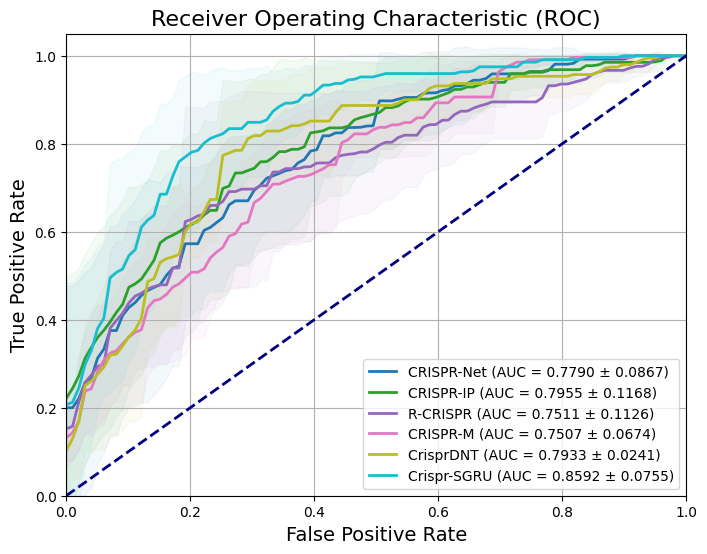

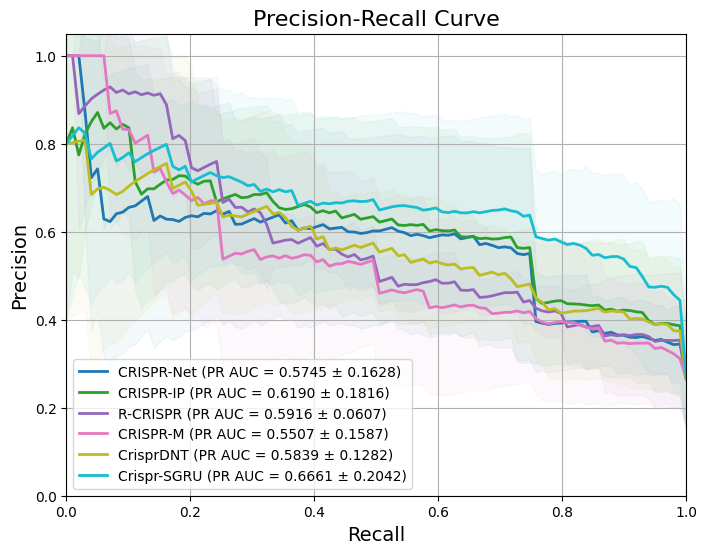

         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1    CRISPR-IP  0.0963 ± 0.1926  0.0684 ± 0.1368  0.0800 ± 0.1600   
2     R-CRISPR  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
3     CRISPR-M  0.1784 ± 0.2188  0.3789 ± 0.4653  0.2421 ± 0.2965   
4    CrisprDNT  0.4319 ± 0.1023  0.7586 ± 0.1521  0.5456 ± 0.1142   
5  Crispr-SGRU  0.5185 ± 0.3522  0.2639 ± 0.3255  0.2801 ± 0.2816   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.7790 ± 0.0867  0.5745 ± 0.1628       0.2256  
1  0.0313 ± 0.0627  0.7955 ± 0.1168  0.6190 ± 0.1816       0.2818  
2  0.0000 ± 0.0000  0.7511 ± 0.1126  0.5916 ± 0.0607       0.2238  
3  0.0992 ± 0.1360  0.7507 ± 0.0674  0.5507 ± 0.1587       0.3667  
4  0.3622 ± 0.0954  0.7933 ± 0.0241  0.5839 ± 0.1282       0.5793  
5  0.2430 ± 0.2256  0.8592 ± 0.0755  0.6661 ± 0.2042       0.4718  
Metrics table saved to CRISPR_Val_only.c

In [12]:
##Visualiza evaluation for the validation datasets only (5 sgRNA out testing)

import pandas as pd

label_test = []

testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing2.csv',
                 './Datasets/real_testing/Testing3.csv',
                 './Datasets/real_testing/Testing4.csv'
]

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

pred_scores_crispr_net_0 = np.load('./Predictions/Val_only/crispr_net_Val_only0.npy')
pred_scores_crispr_net_1 = np.load('./Predictions/Val_only/crispr_net_Val_only1.npy')
pred_scores_crispr_net_2 = np.load('./Predictions/Val_only/crispr_net_Val_only2.npy')
pred_scores_crispr_net_3 = np.load('./Predictions/Val_only/crispr_net_Val_only3.npy')
pred_scores_crispr_net_4 = np.load('./Predictions/Val_only/crispr_net_Val_only4.npy')

pred_scores_crispr_ip_0 = np.load('./Predictions/Val_only/crispr_ip_scores_5sgRNA_Val_only0.npy')
pred_scores_crispr_ip_1 = np.load('./Predictions/Val_only/crispr_ip_scores_5sgRNA_Val_only1.npy')
pred_scores_crispr_ip_2 = np.load('./Predictions/Val_only/crispr_ip_scores_5sgRNA_Val_only2.npy')
pred_scores_crispr_ip_3 = np.load('./Predictions/Val_only/crispr_ip_scores_5sgRNA_Val_only3.npy')
pred_scores_crispr_ip_4 = np.load('./Predictions/Val_only/crispr_ip_scores_5sgRNA_Val_only4.npy')

pred_scores_r_crispr_0 = np.load('./Predictions/Val_only/r_crispr_scores5sgRNA_Val_only0.npy')
pred_scores_r_crispr_1 = np.load('./Predictions/Val_only/r_crispr_scores5sgRNA_Val_only1.npy')
pred_scores_r_crispr_2 = np.load('./Predictions/Val_only/r_crispr_scores5sgRNA_Val_only2.npy')
pred_scores_r_crispr_3 = np.load('./Predictions/Val_only/r_crispr_scores5sgRNA_Val_only3.npy')
pred_scores_r_crispr_4 = np.load('./Predictions/Val_only/r_crispr_scores5sgRNA_Val_only4.npy')

pred_scores_crispr_m_0 = np.load('./Predictions/Val_only/crispr_m_scores_5sgRNA_Val_only0.npy')
pred_scores_crispr_m_1 = np.load('./Predictions/Val_only/crispr_m_scores_5sgRNA_Val_only1.npy')
pred_scores_crispr_m_2 = np.load('./Predictions/Val_only/crispr_m_scores_5sgRNA_Val_only2.npy')
pred_scores_crispr_m_3 = np.load('./Predictions/Val_only/crispr_m_scores_5sgRNA_Val_only3.npy')
pred_scores_crispr_m_4 = np.load('./Predictions/Val_only/crispr_m_scores_5sgRNA_Val_only4.npy')

pred_scores_crisprDNT_0 = np.load('./Predictions/Val_only/crisprDNT_scores_5sgRNA_Val_only0.npy')
pred_scores_crisprDNT_1 = np.load('./Predictions/Val_only/crisprDNT_scores_5sgRNA_Val_only1.npy')
pred_scores_crisprDNT_2 = np.load('./Predictions/Val_only/crisprDNT_scores_5sgRNA_Val_only2.npy')
pred_scores_crisprDNT_3 = np.load('./Predictions/Val_only/crisprDNT_scores_5sgRNA_Val_only3.npy')
pred_scores_crisprDNT_4 = np.load('./Predictions/Val_only/crisprDNT_scores_5sgRNA_Val_only4.npy')

pred_scores_crispr_sgru_0 = np.load('./Predictions/Val_only/crispr_sgru_scores_5sgRNA_Val_only0.npy')
pred_scores_crispr_sgru_1 = np.load('./Predictions/Val_only/crispr_sgru_scores_5sgRNA_Val_only1.npy')
pred_scores_crispr_sgru_2 = np.load('./Predictions/Val_only/crispr_sgru_scores_5sgRNA_Val_only2.npy')
pred_scores_crispr_sgru_3 = np.load('./Predictions/Val_only/crispr_sgru_scores_5sgRNA_Val_only3.npy')
pred_scores_crispr_sgru_4 = np.load('./Predictions/Val_only/crispr_sgru_scores_5sgRNA_Val_only4.npy')

predictions_dict = {
    "CRISPR-Net": [pred_scores_crispr_net_0,pred_scores_crispr_net_1,pred_scores_crispr_net_2,
                   pred_scores_crispr_net_3,pred_scores_crispr_net_4],
    "CRISPR-IP": [pred_scores_crispr_ip_0,pred_scores_crispr_ip_1,pred_scores_crispr_ip_2,
                   pred_scores_crispr_ip_3,pred_scores_crispr_ip_4],
    "R-CRISPR" : [pred_scores_r_crispr_0,pred_scores_r_crispr_1,pred_scores_r_crispr_2,
                   pred_scores_r_crispr_3,pred_scores_r_crispr_4],
    "CRISPR-M" : [pred_scores_crispr_m_0,pred_scores_crispr_m_1,pred_scores_crispr_m_2,
                   pred_scores_crispr_m_3,pred_scores_crispr_m_4],
    "CrisprDNT": [pred_scores_crisprDNT_0,pred_scores_crisprDNT_1,pred_scores_crisprDNT_2,
                   pred_scores_crisprDNT_3,pred_scores_crisprDNT_4],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0,pred_scores_crispr_sgru_1,pred_scores_crispr_sgru_2,
                   pred_scores_crispr_sgru_3,pred_scores_crispr_sgru_4],
}


ROC_with_metrics(label_test, predictions_dict, 'CRISPR_Val_only.csv')

In [16]:
##Visualiza evaluation for the validation datasets only (5 sgRNA out testing)
## 2025-03-26
import pandas as pd

label_test = []

testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing2.csv',
                 './Datasets/real_testing/Testing3.csv',
                 './Datasets/real_testing/Testing4.csv'
]

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
batch_size_list = [256]
epochs_list = [200]    

for batch_size in batch_size_list:
    for epochs in epochs_list:  
    
        pred_scores_crispr_net_0 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_net_1 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_net_2 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_net_3 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_net_4 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_ip_0 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_ip_1 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_ip_2 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_ip_3 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_ip_4 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_r_crispr_0 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_r_crispr_1 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_r_crispr_2 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_r_crispr_3 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_r_crispr_4 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_m_0 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_m_1 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_m_2 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_m_3 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_m_4 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crisprDNT_0 = np.load('./New_evaluation/crisprdnt_rev/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crisprDNT_1 = np.load('./New_evaluation/crisprdnt_rev/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crisprDNT_2 = np.load('./New_evaluation/crisprdnt_rev/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crisprDNT_3 = np.load('./New_evaluation/crisprdnt_rev/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crisprDNT_4 = np.load('./New_evaluation/crisprdnt_rev/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_sgru_0 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_sgru_1 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_sgru_2 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_sgru_3 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_sgru_4 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        predictions_dict = {
            "CRISPR-Net": [pred_scores_crispr_net_0,pred_scores_crispr_net_1,pred_scores_crispr_net_2,
                           pred_scores_crispr_net_3,pred_scores_crispr_net_4],
            "CRISPR-IP": [pred_scores_crispr_ip_0,pred_scores_crispr_ip_1,pred_scores_crispr_ip_2,
                           pred_scores_crispr_ip_3,pred_scores_crispr_ip_4],
            "R-CRISPR" : [pred_scores_r_crispr_0,pred_scores_r_crispr_1,pred_scores_r_crispr_2,
                           pred_scores_r_crispr_3,pred_scores_r_crispr_4],
            "CRISPR-M" : [pred_scores_crispr_m_0,pred_scores_crispr_m_1,pred_scores_crispr_m_2,
                           pred_scores_crispr_m_3,pred_scores_crispr_m_4],
#             "CrisprDNT": [pred_scores_crisprDNT_0,pred_scores_crisprDNT_1,pred_scores_crisprDNT_2,
#                            pred_scores_crisprDNT_3,pred_scores_crisprDNT_4],
            "Crispr-SGRU": [pred_scores_crispr_sgru_0,pred_scores_crispr_sgru_1,pred_scores_crispr_sgru_2,
                           pred_scores_crispr_sgru_3,pred_scores_crispr_sgru_4],
        }

        ROC_with_metrics(label_test, predictions_dict, 
                         output_csv='metrics_table_val_only_b' + str(batch_size) + '_e' + str(epochs) + '.csv', 
                         output_dir='val_only_figures_b' + str(batch_size) + '_e' + str(epochs))

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to val_only_figures_b256_e200/ROC_curve.png
Precision-Recall curve saved to val_only_figures_b256_e200/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.5999 ± 0.1321  0.4684 ± 0.2007  0.4902 ± 0.1365   
1    CRISPR-IP  0.5849 ± 0.2876  0.3813 ± 0.1790  0.4258 ± 0.1634   
2     R-CRISPR  0.5200 ± 0.0532  0.5409 ± 0.1114  0.5234 ± 0.0620   
3     CRISPR-M  0.5005 ± 0.2734  0.5753 ± 0.3087  0.4403 ± 0.1311   
4  Crispr-SGRU  0.4259 ± 0.1531  0.5595 ± 0.2557  0.4497 ± 0.1374   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.4410 ± 0.1151  0.7878 ± 0.1084  0.5139 ± 0.1346       0.5502  
1  0.3862 ± 0.1460  0.8238 ± 0.0430  0.5061 ± 0.1365       0.5180  
2  0.4476 ± 0.0539  0.7843 ± 0.1050  0.5173 ± 0.1203       0.5556  
3  0.3861 ± 0.1478  0.7895 ± 0.1203  0.4633 ± 0.1992       0.5258  
4  0.3892 ± 0.1132  0.8113 ± 0.0877  0.5312 ± 0.1425       0.5278  
Metrics table saved to metrics_

In [9]:
##Visualiza evaluation for the validation datasets only (5 sgRNA out testing)
## 2025-03-26
import pandas as pd

label_test = []

testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing2.csv',
                 './Datasets/real_testing/Testing3.csv',
                 './Datasets/real_testing/Testing4.csv'
]

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
batch_size_list = [256]
epochs_list = [200]    

for batch_size in batch_size_list:
    for epochs in epochs_list:  
    
        pred_scores_crispr_net_0 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_net_1 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_net_2 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_net_3 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_net_4 = np.load('./New_evaluation/crispr_net/crispr_net_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_ip_0 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_ip_1 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_ip_2 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_ip_3 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_ip_4 = np.load('./New_evaluation/crispr_ip/crispr_ip_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_r_crispr_0 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_r_crispr_1 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_r_crispr_2 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_r_crispr_3 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_r_crispr_4 = np.load('./New_evaluation/r_crispr/r_crispr_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_m_0 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_m_1 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_m_2 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_m_3 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_m_4 = np.load('./New_evaluation/crispr_m/crispr_m_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')
        
        pred_scores_crisprDNT_0 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crisprDNT_1 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crisprDNT_2 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crisprDNT_3 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crisprDNT_4 = np.load('./New_evaluation/crisprdnt/crisprdnt_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        pred_scores_crispr_sgru_0 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_0.npy')
        pred_scores_crispr_sgru_1 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_1.npy')
        pred_scores_crispr_sgru_2 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_2.npy')
        pred_scores_crispr_sgru_3 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_3.npy')
        pred_scores_crispr_sgru_4 = np.load('./New_evaluation/crispr_sgru/crispr_sgru_val_only_b' + str(batch_size) + '_e' + str(epochs) + '_4.npy')

        predictions_dict = {
            "CRISPR-Net": [pred_scores_crispr_net_0,pred_scores_crispr_net_1,pred_scores_crispr_net_2,
                           pred_scores_crispr_net_3,pred_scores_crispr_net_4],
            "CRISPR-IP": [pred_scores_crispr_ip_0,pred_scores_crispr_ip_1,pred_scores_crispr_ip_2,
                           pred_scores_crispr_ip_3,pred_scores_crispr_ip_4],
            "R-CRISPR" : [pred_scores_r_crispr_0,pred_scores_r_crispr_1,pred_scores_r_crispr_2,
                           pred_scores_r_crispr_3,pred_scores_r_crispr_4],
            "CRISPR-M" : [pred_scores_crispr_m_0,pred_scores_crispr_m_1,pred_scores_crispr_m_2,
                           pred_scores_crispr_m_3,pred_scores_crispr_m_4],
            "CrisprDNT": [pred_scores_crisprDNT_0,pred_scores_crisprDNT_1,pred_scores_crisprDNT_2,
                           pred_scores_crisprDNT_3,pred_scores_crisprDNT_4],
            "Crispr-SGRU": [pred_scores_crispr_sgru_0,pred_scores_crispr_sgru_1,pred_scores_crispr_sgru_2,
                           pred_scores_crispr_sgru_3,pred_scores_crispr_sgru_4],
        }

        ROC_with_metrics(label_test, predictions_dict, 
                         output_csv='metrics_table_val_only_b' + str(batch_size) + '_e' + str(epochs) + '.csv', 
                         output_dir='val_only_figures_b' + str(batch_size) + '_e' + str(epochs))

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC curve saved to val_only_figures_b256_e200/ROC_curve.png
Precision-Recall curve saved to val_only_figures_b256_e200/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.5999 ± 0.1321  0.4684 ± 0.2007  0.4902 ± 0.1365   
1    CRISPR-IP  0.5849 ± 0.2876  0.3813 ± 0.1790  0.4258 ± 0.1634   
2     R-CRISPR  0.5200 ± 0.0532  0.5409 ± 0.1114  0.5234 ± 0.0620   
3     CRISPR-M  0.5005 ± 0.2734  0.5753 ± 0.3087  0.4403 ± 0.1311   
4    CrisprDNT  0.2429 ± 0.2056  0.2520 ± 0.2149  0.2440 ± 0.2033   
5  Crispr-SGRU  0.4259 ± 0.1531  0.5595 ± 0.2557  0.4497 ± 0.1374   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.4410 ± 0.1151  0.7878 ± 0.1084  0.5139 ± 0.1346       0.5502  
1  0.3862 ± 0.1460  0.8238 ± 0.0430  0.5061 ± 0.1365       0.5180  
2  0.4476 ± 0.0539  0.7843 ± 0.1050  0.5173 ± 0.1203       0.5556  
3  0.3861 ± 0.1478  0.7895 ± 0.1203  0.4633 ± 0.1992       0.5258  
4  0.2058 ± 0.1711  0.7035 ± 0

In [4]:
##Visualiza evaluation for the validation datasets only (5 sgRNA out testing)
## 2025-03-26
import pandas as pd

label_test = []

testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing2.csv',
                 './Datasets/real_testing/Testing3.csv',
                 './Datasets/real_testing/Testing4.csv'
]

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

name_list = ['crispr_net','crispr_ip','r_crispr','crispr_m','crisprdnt','crispr_sgru']
    
batch_size_list = [16, 64, 256, 1024, 2048] #fixed on 256
epochs_list = [10, 50, 100, 200, 300, 500]    # fixed on 200

## fix batch_size

for model in name_list:
    batch_size = 256
    pred_scores_crispr_net_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[0]) + '_0.npy')
    pred_scores_crispr_net_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[0]) + '_1.npy')
    pred_scores_crispr_net_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[0]) + '_2.npy')
    pred_scores_crispr_net_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[0]) + '_3.npy')
    pred_scores_crispr_net_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[0]) + '_4.npy')

    pred_scores_crispr_ip_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[1]) + '_0.npy')
    pred_scores_crispr_ip_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[1]) + '_1.npy')
    pred_scores_crispr_ip_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[1]) + '_2.npy')
    pred_scores_crispr_ip_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[1]) + '_3.npy')
    pred_scores_crispr_ip_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[1]) + '_4.npy')

    pred_scores_r_crispr_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[2]) + '_0.npy')
    pred_scores_r_crispr_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[2]) + '_1.npy')
    pred_scores_r_crispr_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[2]) + '_2.npy')
    pred_scores_r_crispr_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[2]) + '_3.npy')
    pred_scores_r_crispr_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[2]) + '_4.npy')

    pred_scores_crispr_m_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[3]) + '_0.npy')
    pred_scores_crispr_m_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[3]) + '_1.npy')
    pred_scores_crispr_m_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[3]) + '_2.npy')
    pred_scores_crispr_m_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[3]) + '_3.npy')
    pred_scores_crispr_m_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[3]) + '_4.npy')

    pred_scores_crisprDNT_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[4]) + '_0.npy')
    pred_scores_crisprDNT_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[4]) + '_1.npy')
    pred_scores_crisprDNT_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[4]) + '_2.npy')
    pred_scores_crisprDNT_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[4]) + '_3.npy')
    pred_scores_crisprDNT_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[4]) + '_4.npy')

    pred_scores_crispr_sgru_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[5]) + '_0.npy')
    pred_scores_crispr_sgru_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[5]) + '_1.npy')
    pred_scores_crispr_sgru_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[5]) + '_2.npy')
    pred_scores_crispr_sgru_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[5]) + '_3.npy')
    pred_scores_crispr_sgru_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size) + '_e' + str(epochs_list[5]) + '_4.npy')

    predictions_dict = {
        model + " B=256 E=10": [pred_scores_crispr_net_0,pred_scores_crispr_net_1,pred_scores_crispr_net_2,
                       pred_scores_crispr_net_3,pred_scores_crispr_net_4],
        model + " B=256 E=50": [pred_scores_crispr_ip_0,pred_scores_crispr_ip_1,pred_scores_crispr_ip_2,
                       pred_scores_crispr_ip_3,pred_scores_crispr_ip_4],
        model + " B=256 E=100" : [pred_scores_r_crispr_0,pred_scores_r_crispr_1,pred_scores_r_crispr_2,
                       pred_scores_r_crispr_3,pred_scores_r_crispr_4],
        model + " B=256 E=200" : [pred_scores_crispr_m_0,pred_scores_crispr_m_1,pred_scores_crispr_m_2,
                       pred_scores_crispr_m_3,pred_scores_crispr_m_4],
        model + " B=256 E=300": [pred_scores_crisprDNT_0,pred_scores_crisprDNT_1,pred_scores_crisprDNT_2,
                       pred_scores_crisprDNT_3,pred_scores_crisprDNT_4],
        model + " B=256 E=500": [pred_scores_crispr_sgru_0,pred_scores_crispr_sgru_1,pred_scores_crispr_sgru_2,
                       pred_scores_crispr_sgru_3,pred_scores_crispr_sgru_4],
    }

    ROC_with_metrics(label_test, predictions_dict, 
                         output_csv='metrics_table_val_only_b256_varied_e' + model + '.csv', 
                         output_dir='val_only_figures_b256_varied_e' + model)

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_b256_varied_ecrispr_net/ROC_curve.png
Precision-Recall curve saved to val_only_figures_b256_varied_ecrispr_net/Precision_Recall_curve.png
                    Model        Precision           Recall               F1  \
0   crispr_net B=256 E=10  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1   crispr_net B=256 E=50  0.5404 ± 0.1925  0.1873 ± 0.1603  0.2264 ± 0.1291   
2  crispr_net B=256 E=100  0.6174 ± 0.1465  0.3733 ± 0.2265  0.4165 ± 0.1489   
3  crispr_net B=256 E=200  0.5999 ± 0.1321  0.4684 ± 0.2007  0.4902 ± 0.1365   
4  crispr_net B=256 E=300  0.4640 ± 0.1492  0.5935 ± 0.2025  0.4832 ± 0.1357   
5  crispr_net B=256 E=500  0.4759 ± 0.1996  0.5789 ± 0.1512  0.4788 ± 0.1317   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.6396 ± 0.2190  0.3644 ± 0.1164       0.1673  
1  0.2155 ± 0.0422  0.7336 ± 0.1295  0.3821 ± 0.1213       0.3809  
2  0.3925 ± 0.0907  0.7944 ± 0.1046  0.4945 ± 0.1421       0.

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_b256_varied_ecrispr_ip/ROC_curve.png
Precision-Recall curve saved to val_only_figures_b256_varied_ecrispr_ip/Precision_Recall_curve.png
                   Model        Precision           Recall               F1  \
0   crispr_ip B=256 E=10  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1   crispr_ip B=256 E=50  0.4667 ± 0.4522  0.0767 ± 0.0757  0.1206 ± 0.1160   
2  crispr_ip B=256 E=100  0.5614 ± 0.2382  0.4025 ± 0.2427  0.4271 ± 0.1714   
3  crispr_ip B=256 E=200  0.5849 ± 0.2876  0.3813 ± 0.1790  0.4258 ± 0.1634   
4  crispr_ip B=256 E=300  0.4638 ± 0.1750  0.4580 ± 0.1398  0.4372 ± 0.1410   
5  crispr_ip B=256 E=500  0.3987 ± 0.1373  0.5427 ± 0.2041  0.4438 ± 0.1418   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.7481 ± 0.1559  0.4554 ± 0.2176       0.2006  
1  0.1584 ± 0.1389  0.7840 ± 0.1180  0.5182 ± 0.1939       0.3541  
2  0.3890 ± 0.1488  0.8252 ± 0.0695  0.4673 ± 0.1958       0.5121  
3 

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_b256_varied_er_crispr/ROC_curve.png
Precision-Recall curve saved to val_only_figures_b256_varied_er_crispr/Precision_Recall_curve.png
                  Model        Precision           Recall               F1  \
0   r_crispr B=256 E=10  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1   r_crispr B=256 E=50  0.6267 ± 0.1583  0.1980 ± 0.1568  0.2686 ± 0.1595   
2  r_crispr B=256 E=100  0.6279 ± 0.2452  0.3559 ± 0.2374  0.3671 ± 0.1919   
3  r_crispr B=256 E=200  0.5200 ± 0.0532  0.5409 ± 0.1114  0.5234 ± 0.0620   
4  r_crispr B=256 E=300  0.5263 ± 0.1195  0.5292 ± 0.2299  0.4868 ± 0.1280   
5  r_crispr B=256 E=500  0.4162 ± 0.1390  0.4998 ± 0.2197  0.4316 ± 0.1672   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.6932 ± 0.2132  0.3999 ± 0.2027       0.1822  
1  0.2784 ± 0.0948  0.7290 ± 0.1938  0.4420 ± 0.1960       0.4238  
2  0.3644 ± 0.1213  0.7734 ± 0.1350  0.5432 ± 0.1571       0.5053  
3  0.4476 ±

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_b256_varied_ecrispr_m/ROC_curve.png
Precision-Recall curve saved to val_only_figures_b256_varied_ecrispr_m/Precision_Recall_curve.png
                  Model        Precision           Recall               F1  \
0   crispr_m B=256 E=10  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1   crispr_m B=256 E=50  0.3636 ± 0.4491  0.0900 ± 0.1114  0.1433 ± 0.1762   
2  crispr_m B=256 E=100  0.2497 ± 0.0915  0.7432 ± 0.2052  0.3722 ± 0.1284   
3  crispr_m B=256 E=200  0.5005 ± 0.2734  0.5753 ± 0.3087  0.4403 ± 0.1311   
4  crispr_m B=256 E=300  0.3733 ± 0.1626  0.5446 ± 0.2335  0.3948 ± 0.0972   
5  crispr_m B=256 E=500  0.3522 ± 0.2497  0.4657 ± 0.2122  0.3202 ± 0.1432   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.5586 ± 0.0513  0.2117 ± 0.1261       0.1284  
1  0.1621 ± 0.1987  0.7430 ± 0.1512  0.3957 ± 0.2995       0.3163  
2  0.2935 ± 0.0835  0.7801 ± 0.0797  0.4777 ± 0.1265       0.4861  
3  0.3861 ±

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_b256_varied_ecrisprdnt/ROC_curve.png
Precision-Recall curve saved to val_only_figures_b256_varied_ecrisprdnt/Precision_Recall_curve.png
                   Model        Precision           Recall               F1  \
0   crisprdnt B=256 E=10  0.0444 ± 0.0889  0.0031 ± 0.0061  0.0057 ± 0.0114   
1   crisprdnt B=256 E=50  0.4226 ± 0.2158  0.1291 ± 0.0994  0.1909 ± 0.1340   
2  crisprdnt B=256 E=100  0.4176 ± 0.2137  0.1931 ± 0.1417  0.2309 ± 0.1336   
3  crisprdnt B=256 E=200  0.2429 ± 0.2056  0.2520 ± 0.2149  0.2440 ± 0.2033   
4  crisprdnt B=256 E=300  0.2346 ± 0.3054  0.0872 ± 0.1302  0.1102 ± 0.1488   
5  crisprdnt B=256 E=500  0.0699 ± 0.1398  0.1420 ± 0.2840  0.0937 ± 0.1874   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0031 ± 0.0061  0.6121 ± 0.1963  0.2733 ± 0.1477       0.1569  
1  0.1741 ± 0.1323  0.7101 ± 0.1795  0.3651 ± 0.2001       0.3320  
2  0.2003 ± 0.1127  0.7623 ± 0.0856  0.3620 ± 0.1710       0.3611  
3 

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_b256_varied_ecrispr_sgru/ROC_curve.png
Precision-Recall curve saved to val_only_figures_b256_varied_ecrispr_sgru/Precision_Recall_curve.png
                     Model        Precision           Recall               F1  \
0   crispr_sgru B=256 E=10  0.2750 ± 0.3571  0.0567 ± 0.0904  0.0919 ± 0.1427   
1   crispr_sgru B=256 E=50  0.5017 ± 0.1231  0.5664 ± 0.2348  0.4921 ± 0.1396   
2  crispr_sgru B=256 E=100  0.4623 ± 0.0685  0.5451 ± 0.2251  0.4766 ± 0.1462   
3  crispr_sgru B=256 E=200  0.4259 ± 0.1531  0.5595 ± 0.2557  0.4497 ± 0.1374   
4  crispr_sgru B=256 E=300  0.4059 ± 0.1856  0.4837 ± 0.2557  0.4204 ± 0.1987   
5  crispr_sgru B=256 E=500  0.3425 ± 0.2207  0.4905 ± 0.2954  0.3956 ± 0.2401   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.1033 ± 0.1477  0.7267 ± 0.1855  0.4284 ± 0.1958       0.2803  
1  0.4390 ± 0.0948  0.7986 ± 0.1033  0.5312 ± 0.1193       0.5548  
2  0.4048 ± 0.1166  0.8110 ± 0.0805  0.5187 ± 0.1481

In [7]:
pred_scores_crisprDNT_0

array([[9.99999881e-01],
       [4.16750520e-01],
       [9.98228729e-01],
       [1.00000000e+00],
       [9.99609292e-01],
       [1.00000000e+00],
       [9.99992013e-01],
       [9.99999881e-01],
       [9.99105990e-01],
       [9.99999523e-01],
       [6.77912384e-02],
       [8.83156598e-01],
       [9.76605177e-01],
       [8.65787491e-02],
       [5.31229198e-01],
       [9.99893188e-01],
       [1.00000000e+00],
       [9.99998212e-01],
       [8.46816056e-06],
       [1.00000000e+00],
       [9.90153968e-01],
       [9.99691129e-01],
       [2.65981129e-04],
       [1.00000000e+00],
       [5.52971996e-02],
       [5.26397234e-05],
       [9.75358963e-01],
       [2.36404114e-04],
       [9.49394237e-03],
       [7.34014332e-01],
       [9.02429110e-06],
       [9.97408926e-01],
       [8.27514827e-01],
       [9.95729983e-01],
       [9.99377072e-01],
       [2.68681069e-05],
       [8.13703358e-01],
       [6.48131049e-07],
       [2.32693076e-01],
       [9.92946923e-01],


In [8]:
##Visualiza evaluation for the validation datasets only (5 sgRNA out testing)
## 2025-03-26
import pandas as pd

label_test = []

testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing2.csv',
                 './Datasets/real_testing/Testing3.csv',
                 './Datasets/real_testing/Testing4.csv'
]

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

name_list = ['crispr_net','crispr_ip','r_crispr','crispr_m','crisprdnt','crispr_sgru']
    
batch_size_list = [16, 64, 256, 1024, 2048] #fixed on 256
epochs_list = [10, 50, 100, 200, 300, 500]    # fixed on 200

for model in name_list:
    epochs = 200
    pred_scores_crispr_net_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[0]) + '_e' + str(epochs) + '_0.npy')
    pred_scores_crispr_net_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[0]) + '_e' + str(epochs) + '_1.npy')
    pred_scores_crispr_net_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[0]) + '_e' + str(epochs) + '_2.npy')
    pred_scores_crispr_net_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[0]) + '_e' + str(epochs) + '_3.npy')
    pred_scores_crispr_net_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[0]) + '_e' + str(epochs) + '_4.npy')

    pred_scores_crispr_ip_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[1]) + '_e' + str(epochs) + '_0.npy')
    pred_scores_crispr_ip_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[1]) + '_e' + str(epochs) + '_1.npy')
    pred_scores_crispr_ip_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[1]) + '_e' + str(epochs) + '_2.npy')
    pred_scores_crispr_ip_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[1]) + '_e' + str(epochs) + '_3.npy')
    pred_scores_crispr_ip_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[1]) + '_e' + str(epochs) + '_4.npy')

    pred_scores_r_crispr_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[2]) + '_e' + str(epochs) + '_0.npy')
    pred_scores_r_crispr_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[2]) + '_e' + str(epochs) + '_1.npy')
    pred_scores_r_crispr_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[2]) + '_e' + str(epochs) + '_2.npy')
    pred_scores_r_crispr_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[2]) + '_e' + str(epochs) + '_3.npy')
    pred_scores_r_crispr_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[2]) + '_e' + str(epochs) + '_4.npy')

    pred_scores_crispr_m_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[3]) + '_e' + str(epochs) + '_0.npy')
    pred_scores_crispr_m_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[3])+ '_e' + str(epochs) + '_1.npy')
    pred_scores_crispr_m_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[3])+ '_e' + str(epochs) + '_2.npy')
    pred_scores_crispr_m_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[3]) + '_e' + str(epochs) + '_3.npy')
    pred_scores_crispr_m_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[3]) + '_e' + str(epochs) + '_4.npy')

    pred_scores_crisprDNT_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[4]) + '_e' + str(epochs) + '_0.npy')
    pred_scores_crisprDNT_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[4]) + '_e' + str(epochs) + '_1.npy')
    pred_scores_crisprDNT_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[4]) + '_e' + str(epochs) + '_2.npy')
    pred_scores_crisprDNT_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[4]) + '_e' + str(epochs) + '_3.npy')
    pred_scores_crisprDNT_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[4]) + '_e' + str(epochs) + '_4.npy')

#     pred_scores_crispr_sgru_0 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[5]) + '_e' + str(epochs) + '_0.npy')
#     pred_scores_crispr_sgru_1 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[5]) + '_e' + str(epochs) + '_1.npy')
#     pred_scores_crispr_sgru_2 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[5]) + '_e' + str(epochs) + '_2.npy')
#     pred_scores_crispr_sgru_3 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[5]) + '_e' + str(epochs) + '_3.npy')
#     pred_scores_crispr_sgru_4 = np.load('./New_evaluation/' + model + '/' + model + '_val_only_b' + str(batch_size_list[5]) + '_e' + str(epochs) + '_4.npy')

    predictions_dict = {
        model + " B=16 E=200": [pred_scores_crispr_net_0,pred_scores_crispr_net_1,pred_scores_crispr_net_2,
                       pred_scores_crispr_net_3,pred_scores_crispr_net_4],
        model + " B=64 E=200": [pred_scores_crispr_ip_0,pred_scores_crispr_ip_1,pred_scores_crispr_ip_2,
                       pred_scores_crispr_ip_3,pred_scores_crispr_ip_4],
        model + " B=256 E=200" : [pred_scores_r_crispr_0,pred_scores_r_crispr_1,pred_scores_r_crispr_2,
                       pred_scores_r_crispr_3,pred_scores_r_crispr_4],
        model + " B=1024 E=200" : [pred_scores_crispr_m_0,pred_scores_crispr_m_1,pred_scores_crispr_m_2,
                       pred_scores_crispr_m_3,pred_scores_crispr_m_4],
        model + " B=2048 E=200": [pred_scores_crisprDNT_0,pred_scores_crisprDNT_1,pred_scores_crisprDNT_2,
                       pred_scores_crisprDNT_3,pred_scores_crisprDNT_4],
    }

    ROC_with_metrics(label_test, predictions_dict, 
                         output_csv='metrics_table_val_only_varied_b_e200' + model + '.csv', 
                         output_dir='val_only_figures_varied_b_e200' + model)

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to val_only_figures_varied_b_e200crispr_net/ROC_curve.png
Precision-Recall curve saved to val_only_figures_varied_b_e200crispr_net/Precision_Recall_curve.png
                     Model        Precision           Recall               F1  \
0    crispr_net B=16 E=200  0.3351 ± 0.2083  0.3125 ± 0.2595  0.2908 ± 0.2055   
1    crispr_net B=64 E=200  0.4570 ± 0.1475  0.6173 ± 0.2037  0.4963 ± 0.1418   
2   crispr_net B=256 E=200  0.5999 ± 0.1321  0.4684 ± 0.2007  0.4902 ± 0.1365   
3  crispr_net B=1024 E=200  0.6664 ± 0.1768  0.3164 ± 0.1682  0.3990 ± 0.1379   
4  crispr_net B=2048 E=200  0.4902 ± 0.2080  0.3274 ± 0.2258  0.3625 ± 0.2120   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2237 ± 0.1635  0.7991 ± 0.0624  0.4078 ± 0.1580       0.3948  
1  0.4311 ± 0.1258  0.7954 ± 0.0872  0.4915 ± 0.0900       0.5481  
2  0.4410 ± 0.1151  0.7878 ± 0.1084  0.5139 ± 0.1346       0.5502  
3  0.3807 ± 0.0925  0.7895 ± 0.1256  0.4725 ± 0.2145       0.5041  

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_varied_b_e200crispr_ip/ROC_curve.png
Precision-Recall curve saved to val_only_figures_varied_b_e200crispr_ip/Precision_Recall_curve.png
                    Model        Precision           Recall               F1  \
0    crispr_ip B=16 E=200  0.5012 ± 0.1453  0.3751 ± 0.1440  0.4043 ± 0.1255   
1    crispr_ip B=64 E=200  0.4892 ± 0.1141  0.4244 ± 0.0770  0.4385 ± 0.0663   
2   crispr_ip B=256 E=200  0.5849 ± 0.2876  0.3813 ± 0.1790  0.4258 ± 0.1634   
3  crispr_ip B=1024 E=200  0.3292 ± 0.3580  0.1567 ± 0.1428  0.2011 ± 0.1974   
4  crispr_ip B=2048 E=200  0.2000 ± 0.4000  0.0067 ± 0.0133  0.0129 ± 0.0258   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3500 ± 0.0800  0.8142 ± 0.0582  0.4631 ± 0.1040       0.4847  
1  0.3721 ± 0.0472  0.7748 ± 0.0635  0.4617 ± 0.0987       0.4935  
2  0.3862 ± 0.1460  0.8238 ± 0.0430  0.5061 ± 0.1365       0.5180  
3  0.1871 ± 0.1869  0.8322 ± 0.0684  0.5034 ± 0.1401       0.3683  
4  0.03

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC curve saved to val_only_figures_varied_b_e200r_crispr/ROC_curve.png
Precision-Recall curve saved to val_only_figures_varied_b_e200r_crispr/Precision_Recall_curve.png
                   Model        Precision           Recall               F1  \
0    r_crispr B=16 E=200  0.4119 ± 0.1474  0.4004 ± 0.0825  0.3790 ± 0.0943   
1    r_crispr B=64 E=200  0.3802 ± 0.2058  0.4866 ± 0.2662  0.4185 ± 0.2217   
2   r_crispr B=256 E=200  0.5200 ± 0.0532  0.5409 ± 0.1114  0.5234 ± 0.0620   
3  r_crispr B=1024 E=200  0.7044 ± 0.1766  0.2327 ± 0.1411  0.3175 ± 0.1291   
4  r_crispr B=2048 E=200  0.6029 ± 0.3282  0.1765 ± 0.2320  0.2156 ± 0.2206   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3027 ± 0.0739  0.7646 ± 0.0663  0.4184 ± 0.0893       0.4462  
1  0.3381 ± 0.1895  0.7861 ± 0.0868  0.4378 ± 0.2049       0.4745  
2  0.4476 ± 0.0539  0.7843 ± 0.1050  0.5173 ± 0.1203       0.5556  
3  0.3253 ± 0.0526  0.7717 ± 0.1194  0.4938 ± 0.1756       0.4742  
4  0.2356 ± 0.1

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_varied_b_e200crispr_m/ROC_curve.png
Precision-Recall curve saved to val_only_figures_varied_b_e200crispr_m/Precision_Recall_curve.png
                   Model        Precision           Recall               F1  \
0    crispr_m B=16 E=200  0.4799 ± 0.0897  0.3891 ± 0.1736  0.3971 ± 0.0650   
1    crispr_m B=64 E=200  0.3292 ± 0.2035  0.4938 ± 0.3216  0.3735 ± 0.2277   
2   crispr_m B=256 E=200  0.5005 ± 0.2734  0.5753 ± 0.3087  0.4403 ± 0.1311   
3  crispr_m B=1024 E=200  0.3290 ± 0.2660  0.5425 ± 0.3091  0.2589 ± 0.2115   
4  crispr_m B=2048 E=200  0.0889 ± 0.1778  0.1333 ± 0.2667  0.1067 ± 0.2133   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3255 ± 0.0843  0.7209 ± 0.1217  0.4492 ± 0.1086       0.4603  
1  0.3035 ± 0.1885  0.7858 ± 0.0955  0.4336 ± 0.2139       0.4532  
2  0.3861 ± 0.1478  0.7895 ± 0.1203  0.4633 ± 0.1992       0.5258  
3  0.1766 ± 0.1895  0.7782 ± 0.1348  0.4576 ± 0.2549       0.4238  
4  0.0642 ± 0.1

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/

ROC curve saved to val_only_figures_varied_b_e200crisprdnt/ROC_curve.png
Precision-Recall curve saved to val_only_figures_varied_b_e200crisprdnt/Precision_Recall_curve.png
                    Model        Precision           Recall               F1  \
0    crisprdnt B=16 E=200  0.4082 ± 0.1814  0.1897 ± 0.1016  0.2360 ± 0.1204   
1    crisprdnt B=64 E=200  0.3636 ± 0.3487  0.3096 ± 0.2503  0.2909 ± 0.2129   
2   crisprdnt B=256 E=200  0.2429 ± 0.2056  0.2520 ± 0.2149  0.2440 ± 0.2033   
3  crisprdnt B=1024 E=200  0.4415 ± 0.2507  0.2563 ± 0.2189  0.2883 ± 0.1885   
4  crisprdnt B=2048 E=200  0.4028 ± 0.2783  0.1808 ± 0.1730  0.1949 ± 0.1219   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.1907 ± 0.1264  0.7586 ± 0.0869  0.3292 ± 0.1345       0.3521  
1  0.2152 ± 0.2095  0.6955 ± 0.0356  0.3617 ± 0.1167       0.3727  
2  0.2058 ± 0.1711  0.7035 ± 0.1266  0.3474 ± 0.1142       0.3326  
3  0.2505 ± 0.1542  0.7424 ± 0.1277  0.4092 ± 0.2333       0.3980  
4  0.18

/tmp/ipykernel_1765772/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to val_only_figures_varied_b_e200crispr_sgru/ROC_curve.png
Precision-Recall curve saved to val_only_figures_varied_b_e200crispr_sgru/Precision_Recall_curve.png
                      Model        Precision           Recall  \
0    crispr_sgru B=16 E=200  0.5204 ± 0.1638  0.4484 ± 0.1690   
1    crispr_sgru B=64 E=200  0.4851 ± 0.1435  0.5491 ± 0.1580   
2   crispr_sgru B=256 E=200  0.4259 ± 0.1531  0.5595 ± 0.2557   
3  crispr_sgru B=1024 E=200  0.6119 ± 0.1452  0.4591 ± 0.1784   
4  crispr_sgru B=2048 E=200  0.5329 ± 0.1404  0.5038 ± 0.2456   

                F1              MCC            AUROC            PRAUC  \
0  0.4448 ± 0.0851  0.3804 ± 0.0512  0.8068 ± 0.0724  0.4871 ± 0.1472   
1  0.4915 ± 0.0886  0.4180 ± 0.0780  0.8064 ± 0.0881  0.5183 ± 0.1574   
2  0.4497 ± 0.1374  0.3892 ± 0.1132  0.8113 ± 0.0877  0.5312 ± 0.1425   
3  0.4964 ± 0.1292  0.4460 ± 0.1191  0.7980 ± 0.0872  0.5099 ± 0.1386   
4  0.4908 ± 0.1793  0.4296 ± 0.1602  0.7991 ± 0.0947  0.5054 ± 0.154

In [6]:
##2.5 Visualiza evaluation
#2 Pre-testing, only with validated OTS

## General modules
import numpy as np
import pandas as pd
import random 
import time
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import sklearn
import pickle

## Dataset preparation
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import ( 
    roc_curve,
    roc_auc_score,
    auc,
    precision_recall_curve,
    average_precision_score,
)

""" Codes Path: Programs.Evaluation."""

"""
Randomly select 80% from the posive data and 80% from the nagative data for traning, leaving the remaining
20% for testing.

(1) 5-Fold Cross-Validation
Use 5-fold or 10-fold cross-validation for balanced and moderate-sized datasets.

(2) Monte Carlo Cross-Validation. 
Use Repeated Random Sampling (e.g., 30 rounds) for robustness with small datasets.

Calculate the average scores.

"""
validated_onlyMis_df_sgRNA_DNA = pd.read_csv('validated_onlyMis_df_sgRNA_DNA.csv', sep=',')

##2.1 Sampling 

X = validated_onlyMis_df_sgRNA_DNA['Guide_sequence'].to_numpy()
y = validated_onlyMis_df_sgRNA_DNA['Target_sequence'].to_numpy()
labels = validated_onlyMis_df_sgRNA_DNA['Validation']

training_sets = []
testing_sets = []
label_sets_train = []
label_sets_test = []
N = 5
randoms = [42,43,44,45,46]
training_sets_sub1 = []
training_sets_sub2 = []
label_sets_train_sub1 = []
label_sets_train_sub2 = []

for i in range(N):
    X_train, X_test, y_train, y_test, label_train, label_test = train_test_split(X, y, labels, test_size=0.2, random_state=randoms[i])
    training_sets.append([X_train, y_train])
    testing_sets.append([X_test, y_test])
    label_sets_train.append(label_train)
    label_sets_test.append(label_test)
    
    # for models who need validation data to fit the model
    X_train_, X_test_, y_train_, y_test_, label_train_, label_test_ = train_test_split(X_train, y_train, label_train, test_size=0.2, random_state=randoms[i])
    training_sets_sub1.append([X_train_, y_train_])
    training_sets_sub2.append([X_test_, y_test_])
    label_sets_train_sub1.append(label_train_)
    label_sets_train_sub2.append(label_test_)

label_train = np.array(label_sets_train)  
label_test = np.array(label_sets_test)

label_train_sub1 = np.array(label_sets_train_sub1) 
label_train_sub2 = np.array(label_sets_train_sub2) 


pred_scores_crispr_net = np.load('crispr_net_CRISPRoffT_val.npy')
pred_scores_crispr_ip = np.load('crispr_ip_scores_CRISPRoffT_val.npy')
pred_scores_r_crispr = np.load('r_crispr_ip_scores_CRISPRoffT_val.npy')
pred_scores_crispr_m = np.load('crispr_m_scores_CRISPRoffT_val.npy')
pred_scores_crisprDNT = np.load('crisprDNT_scores_CRISPRoffT_val.npy')
pred_scores_crispr_sgru = np.load('crispr_sgru_scores_CRISPRoffT_val.npy')

predictions_dict = {
    "CRISPR-Net": pred_scores_crispr_net,
    "CRISPR-IP": pred_scores_crispr_ip,
    "R-CRISPR" : pred_scores_r_crispr,
    "CRISPR-M" : pred_scores_crispr_m,
    "CrisprDNT": pred_scores_crisprDNT,
    "Crispr-SGRU": pred_scores_crispr_sgru
}

ROC_with_metrics(label_test, predictions_dict, 'CRISPRoffT_val.csv')


2025-03-30 23:09:30.355731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 23:09:30.361759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743394170.368793 1765772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743394170.371253 1765772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 23:09:30.380215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

FileNotFoundError: [Errno 2] No such file or directory: 'crispr_net_CRISPRoffT_val.npy'

In [19]:
# Non validated datasets

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing3.csv',
                ]
pre_fix = "5sgRNA_noVal"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

## set 1
pred_scores_crispr_net_0 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_net_1 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal1.npy')
pred_scores_crispr_net_2 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal2.npy')
pred_scores_crispr_net_3 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal3.npy')
pred_scores_crispr_net_4 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal4.npy')
pred_scores_crispr_net_5 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_ip_0 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_ip_1 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal1.npy')
pred_scores_crispr_ip_2 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal2.npy')
pred_scores_crispr_ip_3 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal3.npy')
pred_scores_crispr_ip_4 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal4.npy')
pred_scores_crispr_ip_5 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal4.npy')

pred_scores_r_crispr_0 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal0.npy')
pred_scores_r_crispr_1 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal1.npy')
pred_scores_r_crispr_2 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal2.npy')
pred_scores_r_crispr_3 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal3.npy')
pred_scores_r_crispr_4 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal4.npy')
pred_scores_r_crispr_5 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_m_0 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_m_1 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal1.npy')
pred_scores_crispr_m_2 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal2.npy')
pred_scores_crispr_m_3 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal3.npy')
pred_scores_crispr_m_4 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal4.npy')
pred_scores_crispr_m_5 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_sgru_0 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_sgru_1 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal1.npy')
pred_scores_crispr_sgru_2 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal2.npy')
pred_scores_crispr_sgru_3 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal3.npy')
pred_scores_crispr_sgru_4 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal4.npy')
pred_scores_crispr_sgru_5 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal5.npy')

## set 2

pred_scores_crispr_net_0_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_net_1_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal1.npy')
pred_scores_crispr_net_2_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal2.npy')
pred_scores_crispr_net_3_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal3.npy')
pred_scores_crispr_net_4_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal4.npy')
pred_scores_crispr_net_5_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal5.npy')

pred_scores_crispr_ip_0_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_ip_1_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal1.npy')
pred_scores_crispr_ip_2_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal2.npy')
pred_scores_crispr_ip_3_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal3.npy')
pred_scores_crispr_ip_4_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal4.npy')
pred_scores_crispr_ip_5_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal4.npy')

pred_scores_r_crispr_0_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal0.npy')
pred_scores_r_crispr_1_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal1.npy')
pred_scores_r_crispr_2_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal2.npy')
pred_scores_r_crispr_3_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal3.npy')
pred_scores_r_crispr_4_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal4.npy')
pred_scores_r_crispr_5_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal5.npy')

pred_scores_crispr_m_0_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_m_1_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal1.npy')
pred_scores_crispr_m_2_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal2.npy')
pred_scores_crispr_m_3_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal3.npy')
pred_scores_crispr_m_4_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal4.npy')
pred_scores_crispr_m_5_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal5.npy')

pred_scores_crisprDNT_0_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crisprDNT_1_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal1.npy')
pred_scores_crisprDNT_2_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal2.npy')
pred_scores_crisprDNT_3_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal3.npy')
pred_scores_crisprDNT_4_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal4.npy')
pred_scores_crisprDNT_5_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal5.npy')

pred_scores_crispr_sgru_0_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_sgru_1_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal1.npy')
pred_scores_crispr_sgru_2_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal2.npy')
pred_scores_crispr_sgru_3_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal3.npy')
pred_scores_crispr_sgru_4_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal4.npy')
pred_scores_crispr_sgru_5_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal5.npy')


# ## set 3

# pred_scores_crispr_net_0_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal0.npy')
# pred_scores_crispr_net_1_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal1.npy')
# pred_scores_crispr_net_2_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal2.npy')
# pred_scores_crispr_net_3_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal3.npy')
# pred_scores_crispr_net_4_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal4.npy')
# pred_scores_crispr_net_5_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal5.npy')

# pred_scores_crispr_ip_0_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_crispr_ip_1_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_crispr_ip_2_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_crispr_ip_3_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_crispr_ip_4_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_crispr_ip_5_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal4.npy')

# pred_scores_r_crispr_0_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_r_crispr_1_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_r_crispr_2_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_r_crispr_3_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_r_crispr_4_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_r_crispr_5_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal5.npy')

# pred_scores_crispr_m_0_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_crispr_m_1_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_crispr_m_2_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_crispr_m_3_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_crispr_m_4_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_crispr_m_5_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal5.npy')

# pred_scores_crisprDNT_0_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_crisprDNT_1_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_crisprDNT_2_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_crisprDNT_3_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_crisprDNT_4_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_crisprDNT_5_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal5.npy')

# pred_scores_crispr_sgru_0_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_crispr_sgru_1_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_crispr_sgru_2_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_crispr_sgru_3_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_crispr_sgru_4_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_crispr_sgru_5_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal5.npy')

predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1, pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1, pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1, pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1, pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1,pred_scores_crispr_sgru_0_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1, pred_scores_crispr_net_1_2],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1, pred_scores_crispr_ip_1_2],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1, pred_scores_r_crispr_1_2],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1, pred_scores_crispr_m_1_2],
    "CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1,pred_scores_crispr_sgru_1_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1, pred_scores_crispr_net_2_2],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1, pred_scores_crispr_ip_2_2],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1, pred_scores_r_crispr_2_2],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1, pred_scores_crispr_m_2_2],
    "CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1,pred_scores_crispr_sgru_2_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1, pred_scores_crispr_net_3_2],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1, pred_scores_crispr_ip_3_2],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1, pred_scores_r_crispr_3_2],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1, pred_scores_crispr_m_3_2],
    "CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1,pred_scores_crispr_sgru_3_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1, pred_scores_crispr_net_4_2],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1, pred_scores_crispr_ip_4_2],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1, pred_scores_r_crispr_4_2],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1, pred_scores_crispr_m_4_2],
    "CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1,pred_scores_crispr_sgru_4_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1, pred_scores_crispr_net_5_2],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1, pred_scores_crispr_ip_5_2],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1, pred_scores_r_crispr_5_2],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1, pred_scores_crispr_m_5_2],
    "CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1,pred_scores_crispr_sgru_5_2]
})



datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


110 110 CRISPR-Net
294 294 CRISPR-Net
225 225 CRISPR-Net
110 110 CRISPR-IP
294 294 CRISPR-IP
225 225 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
225 225 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
225 225 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
225 225 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
225 225 Crispr-SGRU
ROC curve saved to 5sgRNA_noValHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.3004 ± 0.1989  0.6481 ± 0.3523  0.4011 ± 0.2545   
1    CRISPR-IP  0.2184 ± 0.1375  0.8333 ± 0.1361  0.3298 ± 0.1983   
2     R-CRISPR  0.3117 ± 0.2085  0.5463 ± 0.2799  0.3830 ± 0.2380   
3     CRISPR-M  0.2762 ± 0.1625  0.8426 ± 0.1249  0.3912 ± 0.2091   
4    CrisprDNT  0.3311 ± 0.1684  0.4648 ± 0.1667  0.3567 ± 0.1360   
5  Crispr-SGRU  0.2823 ± 0.1762  0.6630 ± 0.2485  0.3812 ± 0.2247   

               MCC            AUROC            PRAUC Over

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/p

110 110 CRISPR-Net
294 294 CRISPR-Net
225 225 CRISPR-Net
110 110 CRISPR-IP
294 294 CRISPR-IP
225 225 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
225 225 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
225 225 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
225 225 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
225 225 Crispr-SGRU
ROC curve saved to 5sgRNA_noValK562/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValK562/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.1788 ± 0.1368  0.5963 ± 0.3123  0.2696 ± 0.1942   
1    CRISPR-IP  0.2456 ± 0.1427  0.5685 ± 0.0567  0.3202 ± 0.1273   
2     R-CRISPR  0.3373 ± 0.2779  0.5389 ± 0.2640  0.3815 ± 0.2489   
3     CRISPR-M  0.0909 ± 0.1286  0.3333 ± 0.4714  0.1429 ± 0.2020   
4    CrisprDNT  0.3022 ± 0.2140  0.1870 ± 0.1498  0.2248 ± 0.1670   
5  Crispr-SGRU  0.2661 ± 0.1775  0.6426 ± 0.3369  0.3705 ± 0.2424   

               MCC            AUROC            PRAUC Overall_Me

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


110 110 CRISPR-Net
294 294 CRISPR-Net
225 225 CRISPR-Net
110 110 CRISPR-IP
294 294 CRISPR-IP
225 225 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
225 225 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
225 225 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
225 225 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
225 225 Crispr-SGRU
ROC curve saved to 5sgRNA_noValII3/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValII3/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.1898 ± 0.1351  0.7833 ± 0.2005  0.2914 ± 0.1960   
1    CRISPR-IP  0.1959 ± 0.1359  0.7204 ± 0.1578  0.2907 ± 0.1909   
2     R-CRISPR  0.1866 ± 0.1310  0.7889 ± 0.0875  0.2834 ± 0.1847   
3     CRISPR-M  0.1973 ± 0.1292  0.7315 ± 0.0917  0.2867 ± 0.1771   
4    CrisprDNT  0.1545 ± 0.1193  0.9667 ± 0.0471  0.2454 ± 0.1697   
5  Crispr-SGRU  0.2111 ± 0.1417  0.8926 ± 0.0457  0.3181 ± 0.1985   

               MCC            AUROC            PRAUC Overall_Mean

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


110 110 CRISPR-Net
294 294 CRISPR-Net
225 225 CRISPR-Net
110 110 CRISPR-IP
294 294 CRISPR-IP
225 225 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
225 225 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
225 225 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
225 225 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
225 225 Crispr-SGRU
ROC curve saved to 5sgRNA_noValII4/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValII4/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.3744 ± 0.2450  0.5111 ± 0.2859  0.4158 ± 0.2686   
1    CRISPR-IP  0.3282 ± 0.2140  0.4704 ± 0.2820  0.3274 ± 0.2536   
2     R-CRISPR  0.4246 ± 0.1998  0.3759 ± 0.2765  0.3615 ± 0.2041   
3     CRISPR-M  0.4725 ± 0.2987  0.2722 ± 0.2110  0.3405 ± 0.2516   
4    CrisprDNT  0.2899 ± 0.1769  0.3241 ± 0.1367  0.2869 ± 0.1540   
5  Crispr-SGRU  0.3236 ± 0.2151  0.4111 ± 0.3457  0.2957 ± 0.2321   

               MCC            AUROC            PRAUC Overall_Mean

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


294 294 CRISPR-Net
225 225 CRISPR-Net
110 110 CRISPR-IP
294 294 CRISPR-IP
225 225 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
225 225 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
225 225 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
225 225 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
225 225 Crispr-SGRU
ROC curve saved to 5sgRNA_noValII6/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValII6/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2667 ± 0.2494  0.1519 ± 0.1769  0.1890 ± 0.2088   
1    CRISPR-IP  0.1918 ± 0.1829  0.2019 ± 0.0930  0.1211 ± 0.0703   
2     R-CRISPR  0.3397 ± 0.2563  0.1630 ± 0.1925  0.2025 ± 0.2209   
3     CRISPR-M  0.2350 ± 0.2119  0.2278 ± 0.1057  0.1845 ± 0.1210   
4    CrisprDNT  0.1157 ± 0.1275  0.4519 ± 0.3813  0.1778 ± 0.1947   
5  Crispr-SGRU  0.2730 ± 0.2648  0.1611 ± 0.1723  0.2017 ± 0.2091   

                MCC            AUROC            PRAUC Overall_Mean  
0   0.1303 ± 0.

/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
# Non validated datasets

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                ]
pre_fix = "5sgRNA_noVal"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

## set 1
pred_scores_crispr_net_0 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_net_1 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal1.npy')
pred_scores_crispr_net_2 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal2.npy')
pred_scores_crispr_net_3 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal3.npy')
pred_scores_crispr_net_4 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal4.npy')
pred_scores_crispr_net_5 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_ip_0 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_ip_1 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal1.npy')
pred_scores_crispr_ip_2 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal2.npy')
pred_scores_crispr_ip_3 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal3.npy')
pred_scores_crispr_ip_4 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal4.npy')
pred_scores_crispr_ip_5 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal4.npy')

pred_scores_r_crispr_0 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal0.npy')
pred_scores_r_crispr_1 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal1.npy')
pred_scores_r_crispr_2 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal2.npy')
pred_scores_r_crispr_3 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal3.npy')
pred_scores_r_crispr_4 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal4.npy')
pred_scores_r_crispr_5 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_m_0 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_m_1 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal1.npy')
pred_scores_crispr_m_2 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal2.npy')
pred_scores_crispr_m_3 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal3.npy')
pred_scores_crispr_m_4 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal4.npy')
pred_scores_crispr_m_5 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_sgru_0 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_sgru_1 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal1.npy')
pred_scores_crispr_sgru_2 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal2.npy')
pred_scores_crispr_sgru_3 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal3.npy')
pred_scores_crispr_sgru_4 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal4.npy')
pred_scores_crispr_sgru_5 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal5.npy')

## set 2

pred_scores_crispr_net_0_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_net_1_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal1.npy')
pred_scores_crispr_net_2_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal2.npy')
pred_scores_crispr_net_3_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal3.npy')
pred_scores_crispr_net_4_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal4.npy')
pred_scores_crispr_net_5_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal5.npy')

pred_scores_crispr_ip_0_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_ip_1_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal1.npy')
pred_scores_crispr_ip_2_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal2.npy')
pred_scores_crispr_ip_3_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal3.npy')
pred_scores_crispr_ip_4_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal4.npy')
pred_scores_crispr_ip_5_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal4.npy')

pred_scores_r_crispr_0_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal0.npy')
pred_scores_r_crispr_1_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal1.npy')
pred_scores_r_crispr_2_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal2.npy')
pred_scores_r_crispr_3_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal3.npy')
pred_scores_r_crispr_4_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal4.npy')
pred_scores_r_crispr_5_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal5.npy')

pred_scores_crispr_m_0_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_m_1_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal1.npy')
pred_scores_crispr_m_2_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal2.npy')
pred_scores_crispr_m_3_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal3.npy')
pred_scores_crispr_m_4_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal4.npy')
pred_scores_crispr_m_5_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal5.npy')

pred_scores_crisprDNT_0_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crisprDNT_1_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal1.npy')
pred_scores_crisprDNT_2_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal2.npy')
pred_scores_crisprDNT_3_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal3.npy')
pred_scores_crisprDNT_4_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal4.npy')
pred_scores_crisprDNT_5_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal5.npy')

pred_scores_crispr_sgru_0_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_sgru_1_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal1.npy')
pred_scores_crispr_sgru_2_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal2.npy')
pred_scores_crispr_sgru_3_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal3.npy')
pred_scores_crispr_sgru_4_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal4.npy')
pred_scores_crispr_sgru_5_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal5.npy')


# ## set 3

# pred_scores_crispr_net_0_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal0.npy')
# pred_scores_crispr_net_1_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal1.npy')
# pred_scores_crispr_net_2_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal2.npy')
# pred_scores_crispr_net_3_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal3.npy')
# pred_scores_crispr_net_4_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal4.npy')
# pred_scores_crispr_net_5_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal5.npy')

# pred_scores_crispr_ip_0_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_crispr_ip_1_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_crispr_ip_2_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_crispr_ip_3_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_crispr_ip_4_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_crispr_ip_5_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal4.npy')

# pred_scores_r_crispr_0_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_r_crispr_1_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_r_crispr_2_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_r_crispr_3_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_r_crispr_4_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_r_crispr_5_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal5.npy')

# pred_scores_crispr_m_0_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_crispr_m_1_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_crispr_m_2_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_crispr_m_3_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_crispr_m_4_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_crispr_m_5_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal5.npy')

# pred_scores_crisprDNT_0_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_crisprDNT_1_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_crisprDNT_2_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_crisprDNT_3_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_crisprDNT_4_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_crisprDNT_5_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal5.npy')

# pred_scores_crispr_sgru_0_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal0.npy')
# pred_scores_crispr_sgru_1_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal1.npy')
# pred_scores_crispr_sgru_2_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal2.npy')
# pred_scores_crispr_sgru_3_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal3.npy')
# pred_scores_crispr_sgru_4_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal4.npy')
# pred_scores_crispr_sgru_5_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal5.npy')

predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1],
    "CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1],
    "CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1],
    "CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1],
    "CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1],
    "CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1],
    "CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1]
})



datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


110 110 CRISPR-Net
294 294 CRISPR-Net
110 110 CRISPR-IP
294 294 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
ROC curve saved to 5sgRNA_noValHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.4387 ± 0.0440  0.8889 ± 0.1111  0.5809 ± 0.0149   
1    CRISPR-IP  0.3128 ± 0.0401  0.9167 ± 0.0833  0.4663 ± 0.0554   
2     R-CRISPR  0.4537 ± 0.0691  0.7361 ± 0.0972  0.5507 ± 0.0243   
3     CRISPR-M  0.3814 ± 0.0802  0.8472 ± 0.1528  0.5259 ± 0.1057   
4    CrisprDNT  0.4410 ± 0.0790  0.5306 ± 0.1694  0.4518 ± 0.0255   
5  Crispr-SGRU  0.4059 ± 0.0275  0.8278 ± 0.1056  0.5401 ± 0.0016   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.4772 ± 0.0677  0.8549 ± 0.0338  0.5422 ± 0.0498       0.6305  
1  0.3433 ± 0.0112  0.7708 ± 0

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_noValII3/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValII3/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2766 ± 0.0691  0.9250 ± 0.0083  0.4215 ± 0.0830   
1    CRISPR-IP  0.2862 ± 0.0566  0.8306 ± 0.0306  0.4213 ± 0.0587   
2     R-CRISPR  0.2691 ± 0.0730  0.8500 ± 0.0167  0.4040 ± 0.0866   
3     CRISPR-M  0.2863 ± 0.0363  0.7639 ± 0.0972  0.4111 ± 0.0236   
4    CrisprDNT  0.2182 ± 0.0958  0.9500 ± 0.0500  0.3418 ± 0.1237   
5  Crispr-SGRU  0.3038 ± 0.0661  0.9222 ± 0.0222  0.4521 ± 0.0722   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2777 ± 0.0040  0.7122 ± 0.0043  0.3011 ± 0.1203       0.4857  
1  0.2548 ± 0.0465  0.6632 ± 0.0432  0.2554 ± 0.0775       0.4519  
2  0.2334 ± 0.0005  0.6855 ± 0.0114  0.3214 ± 0.1574       0.4606  
3  0.2298 ± 0.1025  0.6674 ± 0.0582  0.2795 ± 0.0726       0.4397  
4  0.0876 ± 0.0876  0.5815 ± 0.0321  0.2671 ± 0.0491

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


294 294 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
ROC curve saved to 5sgRNA_noValII6/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValII6/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.4000 ± 0.2000  0.2278 ± 0.1722  0.2835 ± 0.1965   
1    CRISPR-IP  0.2790 ± 0.1654  0.1361 ± 0.0028  0.1651 ± 0.0401   
2     R-CRISPR  0.5095 ± 0.1095  0.2444 ± 0.1889  0.3037 ± 0.2061   
3     CRISPR-M  0.3222 ± 0.2111  0.1750 ± 0.0917  0.2254 ± 0.1302   
4    CrisprDNT  0.1620 ± 0.1339  0.5111 ± 0.4556  0.2453 ± 0.2079   
5  Crispr-SGRU  0.4095 ± 0.2220  0.2417 ± 0.1583  0.3026 ± 0.1872   

                MCC            AUROC            PRAUC Overall_Mean  
0   0.1954 ± 0.1510  0.8302 ± 0.0152  0.4531 ± 0.1752       0.3983  
1   0.0519 ± 0.0632  0.6516 ± 0.0032  0.3166 ± 0.1515       0.2667  
2   0.2445 ± 0.1332  0.8658 ± 0.0090  0.5184 ± 0.1414       0.4477  
3   0.1108 ± 0.1218  0.

In [39]:
# Non validated datasets

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                ]
pre_fix = "5sgRNA_Val"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

## set 1
pred_scores_crispr_net_0 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val0.npy')
pred_scores_crispr_net_1 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val1.npy')
pred_scores_crispr_net_2 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val2.npy')
pred_scores_crispr_net_3 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val3.npy')
pred_scores_crispr_net_4 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val4.npy')
pred_scores_crispr_net_5 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val5.npy')

pred_scores_crispr_ip_0 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val0.npy')
pred_scores_crispr_ip_1 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val1.npy')
pred_scores_crispr_ip_2 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val2.npy')
pred_scores_crispr_ip_3 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val3.npy')
pred_scores_crispr_ip_4 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val4.npy')
pred_scores_crispr_ip_5 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val4.npy')

pred_scores_r_crispr_0 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val0.npy')
pred_scores_r_crispr_1 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val1.npy')
pred_scores_r_crispr_2 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val2.npy')
pred_scores_r_crispr_3 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val3.npy')
pred_scores_r_crispr_4 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val4.npy')
pred_scores_r_crispr_5 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val5.npy')

pred_scores_crispr_m_0 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val0.npy')
pred_scores_crispr_m_1 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val1.npy')
pred_scores_crispr_m_2 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val2.npy')
pred_scores_crispr_m_3 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val3.npy')
pred_scores_crispr_m_4 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val4.npy')
pred_scores_crispr_m_5 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val5.npy')

pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val0.npy')
pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val1.npy')
pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val2.npy')
pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val3.npy')
pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val4.npy')
pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val5.npy')

pred_scores_crispr_sgru_0 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val0.npy')
pred_scores_crispr_sgru_1 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val1.npy')
pred_scores_crispr_sgru_2 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val2.npy')
pred_scores_crispr_sgru_3 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val3.npy')
pred_scores_crispr_sgru_4 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val4.npy')
pred_scores_crispr_sgru_5 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val5.npy')

## set 2

pred_scores_crispr_net_0_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val0.npy')
pred_scores_crispr_net_1_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val1.npy')
pred_scores_crispr_net_2_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val2.npy')
pred_scores_crispr_net_3_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val3.npy')
pred_scores_crispr_net_4_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val4.npy')
pred_scores_crispr_net_5_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val5.npy')

pred_scores_crispr_ip_0_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val0.npy')
pred_scores_crispr_ip_1_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val1.npy')
pred_scores_crispr_ip_2_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val2.npy')
pred_scores_crispr_ip_3_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val3.npy')
pred_scores_crispr_ip_4_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val4.npy')
pred_scores_crispr_ip_5_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val4.npy')

pred_scores_r_crispr_0_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val0.npy')
pred_scores_r_crispr_1_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val1.npy')
pred_scores_r_crispr_2_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val2.npy')
pred_scores_r_crispr_3_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val3.npy')
pred_scores_r_crispr_4_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val4.npy')
pred_scores_r_crispr_5_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val5.npy')

pred_scores_crispr_m_0_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val0.npy')
pred_scores_crispr_m_1_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val1.npy')
pred_scores_crispr_m_2_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val2.npy')
pred_scores_crispr_m_3_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val3.npy')
pred_scores_crispr_m_4_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val4.npy')
pred_scores_crispr_m_5_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val5.npy')

pred_scores_crisprDNT_0_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val0.npy')
pred_scores_crisprDNT_1_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val1.npy')
pred_scores_crisprDNT_2_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val2.npy')
pred_scores_crisprDNT_3_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val3.npy')
pred_scores_crisprDNT_4_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val4.npy')
pred_scores_crisprDNT_5_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val5.npy')

pred_scores_crispr_sgru_0_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val0.npy')
pred_scores_crispr_sgru_1_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val1.npy')
pred_scores_crispr_sgru_2_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val2.npy')
pred_scores_crispr_sgru_3_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val3.npy')
pred_scores_crispr_sgru_4_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val4.npy')
pred_scores_crispr_sgru_5_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val5.npy')


# ## set 3

# pred_scores_crispr_net_0_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_Val0.npy')
# pred_scores_crispr_net_1_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_Val1.npy')
# pred_scores_crispr_net_2_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_Val2.npy')
# pred_scores_crispr_net_3_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_Val3.npy')
# pred_scores_crispr_net_4_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_Val4.npy')
# pred_scores_crispr_net_5_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_Val5.npy')

# pred_scores_crispr_ip_0_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_Val0.npy')
# pred_scores_crispr_ip_1_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_Val1.npy')
# pred_scores_crispr_ip_2_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_Val2.npy')
# pred_scores_crispr_ip_3_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_Val3.npy')
# pred_scores_crispr_ip_4_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_Val4.npy')
# pred_scores_crispr_ip_5_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_Val4.npy')

# pred_scores_r_crispr_0_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_Val0.npy')
# pred_scores_r_crispr_1_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_Val1.npy')
# pred_scores_r_crispr_2_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_Val2.npy')
# pred_scores_r_crispr_3_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_Val3.npy')
# pred_scores_r_crispr_4_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_Val4.npy')
# pred_scores_r_crispr_5_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_Val5.npy')

# pred_scores_crispr_m_0_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_Val0.npy')
# pred_scores_crispr_m_1_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_Val1.npy')
# pred_scores_crispr_m_2_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_Val2.npy')
# pred_scores_crispr_m_3_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_Val3.npy')
# pred_scores_crispr_m_4_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_Val4.npy')
# pred_scores_crispr_m_5_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_Val5.npy')

# pred_scores_crisprDNT_0_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_Val0.npy')
# pred_scores_crisprDNT_1_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_Val1.npy')
# pred_scores_crisprDNT_2_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_Val2.npy')
# pred_scores_crisprDNT_3_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_Val3.npy')
# pred_scores_crisprDNT_4_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_Val4.npy')
# pred_scores_crisprDNT_5_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_Val5.npy')

# pred_scores_crispr_sgru_0_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_Val0.npy')
# pred_scores_crispr_sgru_1_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_Val1.npy')
# pred_scores_crispr_sgru_2_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_Val2.npy')
# pred_scores_crispr_sgru_3_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_Val3.npy')
# pred_scores_crispr_sgru_4_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_Val4.npy')
# pred_scores_crispr_sgru_5_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_Val5.npy')

predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1],
    "CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1],
    "CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1],
    "CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1],
    "CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1],
    "CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1],
    "CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1]
})



datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


110 110 CRISPR-Net
294 294 CRISPR-Net
110 110 CRISPR-IP
294 294 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
ROC curve saved to 5sgRNA_ValHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_ValHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2921 ± 0.0783  0.8889 ± 0.1111  0.4379 ± 0.1026   
1    CRISPR-IP  0.3326 ± 0.0086  0.8028 ± 0.1639  0.4671 ± 0.0372   
2     R-CRISPR  0.3212 ± 0.0634  0.8472 ± 0.1528  0.4657 ± 0.0898   
3     CRISPR-M  0.3623 ± 0.1123  0.5639 ± 0.3694  0.4240 ± 0.2052   
4    CrisprDNT  0.2127 ± 0.0758  1.0000 ± 0.0000  0.3443 ± 0.1035   
5  Crispr-SGRU  0.3804 ± 0.0433  0.8472 ± 0.1528  0.5153 ± 0.0111   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3080 ± 0.0584  0.7787 ± 0.0089  0.4606 ± 0.0169       0.5277  
1  0.3151 ± 0.0317  0.7931 ± 0.018

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_ValII3/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_ValII3/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2606 ± 0.0437  0.9667 ± 0.0333  0.4077 ± 0.0513   
1    CRISPR-IP  0.2542 ± 0.0576  0.9694 ± 0.0028  0.3993 ± 0.0722   
2     R-CRISPR  0.2901 ± 0.0471  0.9694 ± 0.0028  0.4444 ± 0.0556   
3     CRISPR-M  0.3404 ± 0.0706  0.9722 ± 0.0278  0.5011 ± 0.0814   
4    CrisprDNT  0.2286 ± 0.0505  0.7611 ± 0.0389  0.3498 ± 0.0640   
5  Crispr-SGRU  0.2745 ± 0.0550  0.9833 ± 0.0167  0.4258 ± 0.0658   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2443 ± 0.0837  0.6423 ± 0.1092  0.2726 ± 0.0686       0.4657  
1  0.2428 ± 0.0375  0.8145 ± 0.0128  0.4922 ± 0.1492       0.5287  
2  0.3173 ± 0.0432  0.7706 ± 0.0374  0.3750 ± 0.1138       0.5278  
3  0.4127 ± 0.0233  0.8291 ± 0.0229  0.4124 ± 0.1571       0.5780  
4  0.0978 ± 0.0708  0.5566 ± 0.0822  0.2071 ± 0.0409    

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


294 294 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
ROC curve saved to 5sgRNA_ValII6/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_ValII6/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.3546 ± 0.1142  0.8472 ± 0.1528  0.4977 ± 0.1406   
1    CRISPR-IP  0.3073 ± 0.0042  0.7639 ± 0.2361  0.4284 ± 0.0367   
2     R-CRISPR  0.3631 ± 0.0506  0.6778 ± 0.1222  0.4727 ± 0.0727   
3     CRISPR-M  0.3691 ± 0.0309  0.7528 ± 0.1139  0.4948 ± 0.0525   
4    CrisprDNT  0.2565 ± 0.0162  0.9306 ± 0.0694  0.4022 ± 0.0264   
5  Crispr-SGRU  0.3703 ± 0.0332  0.8000 ± 0.0333  0.5044 ± 0.0244   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3927 ± 0.1265  0.8308 ± 0.0239  0.4555 ± 0.1438       0.5631  
1  0.2496 ± 0.0455  0.7338 ± 0.0405  0.3642 ± 0.0256       0.4745  
2  0.3202 ± 0.0143  0.7776 ± 0.0164  0.4116 ± 0.0721       0.5038  
3  0.3523 ± 0.0088  0.7927 ± 0.

ROC curve saved to 5sgRNA_noValHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noValHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2895 ± 0.1892  0.6389 ± 0.3492  0.3901 ± 0.2464   
1    CRISPR-IP  0.2162 ± 0.1332  0.8685 ± 0.0703  0.3262 ± 0.1890   
2     R-CRISPR  0.3304 ± 0.2283  0.4352 ± 0.2872  0.3246 ± 0.2026   
3     CRISPR-M  0.3796 ± 0.2298  0.6389 ± 0.3987  0.3026 ± 0.2425   
4    CrisprDNT  0.2462 ± 0.1033  0.5852 ± 0.1783  0.3440 ± 0.1306   
5  Crispr-SGRU  0.2983 ± 0.1908  0.6630 ± 0.2485  0.3932 ± 0.2337   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3024 ± 0.2233  0.7892 ± 0.1068  0.4016 ± 0.2313       0.4686  
1  0.2370 ± 0.1158  0.7168 ± 0.0650  0.2520 ± 0.1789       0.4361  
2  0.2237 ± 0.1582  0.7743 ± 0.0731  0.3895 ± 0.1249       0.4130  
3  0.2953 ± 0.1656  0.8538 ± 0.0250  0.4094 ± 0.2288       0.4799  
4  0.2249 ± 0.0634  0.7608 ± 0.0625  0.3003 ± 0.1477       0.4102  
5  0.2967 ± 0.2020  0.7500 ± 0.0816  0.3954 ± 0.1341       0.4661  

Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2028 ± 0.1415  0.7037 ± 0.2772  0.3071 ± 0.2031   
1    CRISPR-IP  0.2329 ± 0.1501  0.7315 ± 0.2058  0.3346 ± 0.2102   
2     R-CRISPR  0.2218 ± 0.1498  0.6759 ± 0.2725  0.3248 ± 0.2123   
3     CRISPR-M  0.2818 ± 0.1600  0.5204 ± 0.2748  0.3282 ± 0.2041   
4    CrisprDNT  0.1751 ± 0.0816  0.7222 ± 0.3928  0.2712 ± 0.1335   
5  Crispr-SGRU  0.2638 ± 0.1686  0.7315 ± 0.2058  0.3627 ± 0.2159   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2018 ± 0.1576  0.6987 ± 0.1133  0.3306 ± 0.1843       0.4075  
1  0.2163 ± 0.1869  0.6758 ± 0.1733  0.3490 ± 0.2066       0.4233  
2  0.2212 ± 0.1744  0.6880 ± 0.1419  0.3726 ± 0.1226       0.4174  
3  0.2509 ± 0.1401  0.7149 ± 0.0641  0.3451 ± 0.1643       0.4069  
4  0.1245 ± 0.0201  0.6935 ± 0.0063  0.2593 ± 0.0826       0.3743  
5  0.2598 ± 0.1812  0.7187 ± 0.1426  0.3476 ± 0.2157       0.4474 

In [41]:
# With validated datasets

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing3.csv',
                ]
pre_fix = "5sgRNA_Val_set_1_2_4"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

## set 1
pred_scores_crispr_net_0 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val0.npy')
pred_scores_crispr_net_1 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val1.npy')
pred_scores_crispr_net_2 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val2.npy')
pred_scores_crispr_net_3 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val3.npy')
pred_scores_crispr_net_4 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val4.npy')
pred_scores_crispr_net_5 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val5.npy')

pred_scores_crispr_ip_0 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val0.npy')
pred_scores_crispr_ip_1 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val1.npy')
pred_scores_crispr_ip_2 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val2.npy')
pred_scores_crispr_ip_3 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val3.npy')
pred_scores_crispr_ip_4 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val4.npy')
pred_scores_crispr_ip_5 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val4.npy')

pred_scores_r_crispr_0 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val0.npy')
pred_scores_r_crispr_1 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val1.npy')
pred_scores_r_crispr_2 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val2.npy')
pred_scores_r_crispr_3 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val3.npy')
pred_scores_r_crispr_4 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val4.npy')
pred_scores_r_crispr_5 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val5.npy')

pred_scores_crispr_m_0 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val0.npy')
pred_scores_crispr_m_1 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val1.npy')
pred_scores_crispr_m_2 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val2.npy')
pred_scores_crispr_m_3 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val3.npy')
pred_scores_crispr_m_4 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val4.npy')
pred_scores_crispr_m_5 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val5.npy')

pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val0.npy')
pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val1.npy')
pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val2.npy')
pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val3.npy')
pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val4.npy')
pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val5.npy')

pred_scores_crispr_sgru_0 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val0.npy')
pred_scores_crispr_sgru_1 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val1.npy')
pred_scores_crispr_sgru_2 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val2.npy')
pred_scores_crispr_sgru_3 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val3.npy')
pred_scores_crispr_sgru_4 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val4.npy')
pred_scores_crispr_sgru_5 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val5.npy')

## set 2

pred_scores_crispr_net_0_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val0.npy')
pred_scores_crispr_net_1_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val1.npy')
pred_scores_crispr_net_2_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val2.npy')
pred_scores_crispr_net_3_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val3.npy')
pred_scores_crispr_net_4_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val4.npy')
pred_scores_crispr_net_5_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val5.npy')

pred_scores_crispr_ip_0_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val0.npy')
pred_scores_crispr_ip_1_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val1.npy')
pred_scores_crispr_ip_2_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val2.npy')
pred_scores_crispr_ip_3_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val3.npy')
pred_scores_crispr_ip_4_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val4.npy')
pred_scores_crispr_ip_5_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val4.npy')

pred_scores_r_crispr_0_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val0.npy')
pred_scores_r_crispr_1_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val1.npy')
pred_scores_r_crispr_2_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val2.npy')
pred_scores_r_crispr_3_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val3.npy')
pred_scores_r_crispr_4_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val4.npy')
pred_scores_r_crispr_5_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val5.npy')

pred_scores_crispr_m_0_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val0.npy')
pred_scores_crispr_m_1_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val1.npy')
pred_scores_crispr_m_2_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val2.npy')
pred_scores_crispr_m_3_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val3.npy')
pred_scores_crispr_m_4_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val4.npy')
pred_scores_crispr_m_5_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val5.npy')

pred_scores_crisprDNT_0_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val0.npy')
pred_scores_crisprDNT_1_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val1.npy')
pred_scores_crisprDNT_2_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val2.npy')
pred_scores_crisprDNT_3_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val3.npy')
pred_scores_crisprDNT_4_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val4.npy')
pred_scores_crisprDNT_5_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val5.npy')

pred_scores_crispr_sgru_0_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val0.npy')
pred_scores_crispr_sgru_1_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val1.npy')
pred_scores_crispr_sgru_2_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val2.npy')
pred_scores_crispr_sgru_3_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val3.npy')
pred_scores_crispr_sgru_4_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val4.npy')
pred_scores_crispr_sgru_5_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val5.npy')


## set 4

pred_scores_crispr_net_0_2 = np.load('./Predictions/set4/crispr_net_5sgRNA_set4_Val0.npy')
pred_scores_crispr_net_1_2 = np.load('./Predictions/set4/crispr_net_5sgRNA_set4_Val1.npy')
pred_scores_crispr_net_2_2 = np.load('./Predictions/set4/crispr_net_5sgRNA_set4_Val2.npy')
pred_scores_crispr_net_3_2 = np.load('./Predictions/set4/crispr_net_5sgRNA_set4_Val3.npy')
pred_scores_crispr_net_4_2 = np.load('./Predictions/set4/crispr_net_5sgRNA_set4_Val4.npy')
pred_scores_crispr_net_5_2 = np.load('./Predictions/set4/crispr_net_5sgRNA_set4_Val5.npy')

pred_scores_crispr_ip_0_2 = np.load('./Predictions/set4/crispr_ip_scores_5sgRNA_set4_Val0.npy')
pred_scores_crispr_ip_1_2 = np.load('./Predictions/set4/crispr_ip_scores_5sgRNA_set4_Val1.npy')
pred_scores_crispr_ip_2_2 = np.load('./Predictions/set4/crispr_ip_scores_5sgRNA_set4_Val2.npy')
pred_scores_crispr_ip_3_2 = np.load('./Predictions/set4/crispr_ip_scores_5sgRNA_set4_Val3.npy')
pred_scores_crispr_ip_4_2 = np.load('./Predictions/set4/crispr_ip_scores_5sgRNA_set4_Val4.npy')
pred_scores_crispr_ip_5_2 = np.load('./Predictions/set4/crispr_ip_scores_5sgRNA_set4_Val4.npy')

pred_scores_r_crispr_0_2 = np.load('./Predictions/set4/r_crispr_scores_5sgRNA_set4_Val0.npy')
pred_scores_r_crispr_1_2 = np.load('./Predictions/set4/r_crispr_scores_5sgRNA_set4_Val1.npy')
pred_scores_r_crispr_2_2 = np.load('./Predictions/set4/r_crispr_scores_5sgRNA_set4_Val2.npy')
pred_scores_r_crispr_3_2 = np.load('./Predictions/set4/r_crispr_scores_5sgRNA_set4_Val3.npy')
pred_scores_r_crispr_4_2 = np.load('./Predictions/set4/r_crispr_scores_5sgRNA_set4_Val4.npy')
pred_scores_r_crispr_5_2 = np.load('./Predictions/set4/r_crispr_scores_5sgRNA_set4_Val5.npy')

pred_scores_crispr_m_0_2 = np.load('./Predictions/set4/crispr_m_scores_5sgRNA_set4_Val0.npy')
pred_scores_crispr_m_1_2 = np.load('./Predictions/set4/crispr_m_scores_5sgRNA_set4_Val1.npy')
pred_scores_crispr_m_2_2 = np.load('./Predictions/set4/crispr_m_scores_5sgRNA_set4_Val2.npy')
pred_scores_crispr_m_3_2 = np.load('./Predictions/set4/crispr_m_scores_5sgRNA_set4_Val3.npy')
pred_scores_crispr_m_4_2 = np.load('./Predictions/set4/crispr_m_scores_5sgRNA_set4_Val4.npy')
pred_scores_crispr_m_5_2 = np.load('./Predictions/set4/crispr_m_scores_5sgRNA_set4_Val5.npy')

pred_scores_crisprDNT_0_2 = np.load('./Predictions/set4/crisprDNT_scores_5sgRNA_set4_Val0.npy')
pred_scores_crisprDNT_1_2 = np.load('./Predictions/set4/crisprDNT_scores_5sgRNA_set4_Val1.npy')
pred_scores_crisprDNT_2_2 = np.load('./Predictions/set4/crisprDNT_scores_5sgRNA_set4_Val2.npy')
pred_scores_crisprDNT_3_2 = np.load('./Predictions/set4/crisprDNT_scores_5sgRNA_set4_Val3.npy')
pred_scores_crisprDNT_4_2 = np.load('./Predictions/set4/crisprDNT_scores_5sgRNA_set4_Val4.npy')
pred_scores_crisprDNT_5_2 = np.load('./Predictions/set4/crisprDNT_scores_5sgRNA_set4_Val5.npy')

pred_scores_crispr_sgru_0_2 = np.load('./Predictions/set4/crispr_sgru_scores_5sgRNA_set4_Val0.npy')
pred_scores_crispr_sgru_1_2 = np.load('./Predictions/set4/crispr_sgru_scores_5sgRNA_set4_Val1.npy')
pred_scores_crispr_sgru_2_2 = np.load('./Predictions/set4/crispr_sgru_scores_5sgRNA_set4_Val2.npy')
pred_scores_crispr_sgru_3_2 = np.load('./Predictions/set4/crispr_sgru_scores_5sgRNA_set4_Val3.npy')
pred_scores_crispr_sgru_4_2 = np.load('./Predictions/set4/crispr_sgru_scores_5sgRNA_set4_Val4.npy')
pred_scores_crispr_sgru_5_2 = np.load('./Predictions/set4/crispr_sgru_scores_5sgRNA_set4_Val5.npy')

predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1, pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1, pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1, pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1, pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1,pred_scores_crispr_sgru_0_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1, pred_scores_crispr_net_1_2],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1, pred_scores_crispr_ip_1_2],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1, pred_scores_r_crispr_1_2],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1, pred_scores_crispr_m_1_2],
    "CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1,pred_scores_crispr_sgru_1_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1, pred_scores_crispr_net_2_2],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1, pred_scores_crispr_ip_2_2],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1, pred_scores_r_crispr_2_2],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1, pred_scores_crispr_m_2_2],
    "CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1,pred_scores_crispr_sgru_2_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1, pred_scores_crispr_net_3_2],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1, pred_scores_crispr_ip_3_2],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1, pred_scores_r_crispr_3_2],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1, pred_scores_crispr_m_3_2],
    "CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1,pred_scores_crispr_sgru_3_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1, pred_scores_crispr_net_4_2],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1, pred_scores_crispr_ip_4_2],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1, pred_scores_r_crispr_4_2],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1, pred_scores_crispr_m_4_2],
    "CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1,pred_scores_crispr_sgru_4_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1, pred_scores_crispr_net_5_2],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1, pred_scores_crispr_ip_5_2],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1, pred_scores_r_crispr_5_2],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1, pred_scores_crispr_m_5_2],
    "CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1,pred_scores_crispr_sgru_5_2]
})



datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


110 110 CRISPR-Net
294 294 CRISPR-Net
234 234 CRISPR-Net
110 110 CRISPR-IP
294 294 CRISPR-IP
234 234 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
234 234 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
234 234 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
234 234 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
234 234 Crispr-SGRU
ROC curve saved to 5sgRNA_Val_set_1_2_4HEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4HEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2328 ± 0.1054  0.8593 ± 0.0999  0.3586 ± 0.1400   
1    CRISPR-IP  0.2585 ± 0.1049  0.8352 ± 0.1414  0.3770 ± 0.1310   
2     R-CRISPR  0.2491 ± 0.1143  0.8481 ± 0.1247  0.3728 ± 0.1506   
3     CRISPR-M  0.2964 ± 0.1307  0.5926 ± 0.3044  0.3702 ± 0.1840   
4    CrisprDNT  0.1934 ± 0.0676  0.8833 ± 0.1650  0.3129 ± 0.0955   
5  Crispr-SGRU  0.2949 ± 0.1259  0.8315 ± 0.1267  0.4151 ± 0.1419   

               MCC            AUROC      

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


110 110 CRISPR-IP
294 294 CRISPR-IP
234 234 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
234 234 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
234 234 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
234 234 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
234 234 Crispr-SGRU
ROC curve saved to 5sgRNA_Val_set_1_2_4II3/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4II3/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2069 ± 0.0839  0.9778 ± 0.0314  0.3321 ± 0.1148   
1    CRISPR-IP  0.2032 ± 0.0862  0.9796 ± 0.0146  0.3274 ± 0.1176   
2     R-CRISPR  0.2256 ± 0.0990  0.9796 ± 0.0146  0.3550 ± 0.1343   
3     CRISPR-M  0.2681 ± 0.1174  0.9815 ± 0.0262  0.4074 ± 0.1483   
4    CrisprDNT  0.1811 ± 0.0788  0.8407 ± 0.1170  0.2861 ± 0.1041   
5  Crispr-SGRU  0.2152 ± 0.0951  0.9889 ± 0.0157  0.3426 ± 0.1293   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2041 ± 0.0889  0.6048 ± 0.1037  0

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


294 294 CRISPR-IP
234 234 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
234 234 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
234 234 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
234 234 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
234 234 Crispr-SGRU
ROC curve saved to 5sgRNA_Val_set_1_2_4II5/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4II5/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2177 ± 0.0819  0.7907 ± 0.1730  0.3373 ± 0.1120   
1    CRISPR-IP  0.2396 ± 0.0957  0.8259 ± 0.2118  0.3483 ± 0.1172   
2     R-CRISPR  0.2323 ± 0.0586  0.7611 ± 0.1455  0.3557 ± 0.0846   
3     CRISPR-M  0.2620 ± 0.0328  0.6537 ± 0.2636  0.3625 ± 0.0677   
4    CrisprDNT  0.1948 ± 0.0786  0.6759 ± 0.2478  0.3005 ± 0.1180   
5  Crispr-SGRU  0.2530 ± 0.0757  0.8519 ± 0.1072  0.3865 ± 0.1018   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2022 ± 0.0670  0.7132 ± 0.0762  0.4188 ± 0.1515    

/tmp/ipykernel_703624/1254026954.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


294 294 CRISPR-IP
234 234 CRISPR-IP
110 110 R-CRISPR
294 294 R-CRISPR
234 234 R-CRISPR
110 110 CRISPR-M
294 294 CRISPR-M
234 234 CRISPR-M
110 110 CrisprDNT
294 294 CrisprDNT
234 234 CrisprDNT
110 110 Crispr-SGRU
294 294 Crispr-SGRU
234 234 Crispr-SGRU
ROC curve saved to 5sgRNA_Val_set_1_2_4II6/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4II6/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2793 ± 0.1415  0.7815 ± 0.1556  0.4034 ± 0.1759   
1    CRISPR-IP  0.2396 ± 0.0957  0.8259 ± 0.2118  0.3483 ± 0.1172   
2     R-CRISPR  0.2746 ± 0.1319  0.7019 ± 0.1054  0.3726 ± 0.1535   
3     CRISPR-M  0.2891 ± 0.1160  0.6352 ± 0.1905  0.3949 ± 0.1477   
4    CrisprDNT  0.2007 ± 0.0801  0.9037 ± 0.0682  0.3218 ± 0.1156   
5  Crispr-SGRU  0.2834 ± 0.1258  0.6833 ± 0.1672  0.3951 ± 0.1558   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3067 ± 0.1595  0.7734 ± 0.0836  0.3578 ± 0.1814    

In [22]:
# Non validated datasets
# update 03-29-25

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing3.csv',
                 './Datasets/real_testing/Testing4.csv',
                ]
pre_fix = "5sgRNA_noVal_set_1_4_5_new"
datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
PATH_cripsr_net = './New_evaluation/Testing/crispr_net_'
PATH_cripsr_ip  = './New_evaluation/Testing/crispr_ip_'
PATH_r_cripsr  = './New_evaluation/Testing/r_crispr_'
PATH_cripsr_m  = './New_evaluation/Testing/crispr_m_'
PATH_cripsr_sgru  = './New_evaluation/Testing/crispr_sgru_'

## set 1
pred_scores_crispr_net_0 = np.load(PATH_cripsr_net + datasets[0] + '_0.npy')
pred_scores_crispr_net_1 = np.load(PATH_cripsr_net + datasets[1] + '_0.npy')
pred_scores_crispr_net_2 = np.load(PATH_cripsr_net + datasets[2] + '_0.npy')
pred_scores_crispr_net_3 = np.load(PATH_cripsr_net + datasets[3] + '_0.npy')
pred_scores_crispr_net_4 = np.load(PATH_cripsr_net + datasets[4] + '_0.npy')
pred_scores_crispr_net_5 = np.load(PATH_cripsr_net + datasets[5] + '_0.npy')

pred_scores_crispr_ip_0 = np.load(PATH_cripsr_ip + datasets[0] + '_0.npy')
pred_scores_crispr_ip_1 = np.load(PATH_cripsr_ip + datasets[1] + '_0.npy')
pred_scores_crispr_ip_2 = np.load(PATH_cripsr_ip + datasets[2] + '_0.npy')
pred_scores_crispr_ip_3 = np.load(PATH_cripsr_ip + datasets[3] + '_0.npy')
pred_scores_crispr_ip_4 = np.load(PATH_cripsr_ip + datasets[4] + '_0.npy')
pred_scores_crispr_ip_5 = np.load(PATH_cripsr_ip + datasets[5] + '_0.npy')

pred_scores_r_crispr_0 = np.load(PATH_r_cripsr + datasets[0] + '_0.npy')
pred_scores_r_crispr_1 = np.load(PATH_r_cripsr + datasets[1] + '_0.npy')
pred_scores_r_crispr_2 = np.load(PATH_r_cripsr + datasets[2] + '_0.npy')
pred_scores_r_crispr_3 = np.load(PATH_r_cripsr + datasets[3] + '_0.npy')
pred_scores_r_crispr_4 = np.load(PATH_r_cripsr + datasets[4] + '_0.npy')
pred_scores_r_crispr_5 = np.load(PATH_r_cripsr + datasets[5] + '_0.npy')

pred_scores_crispr_m_0 = np.load(PATH_cripsr_m + datasets[0] + '_0.npy')
pred_scores_crispr_m_1 = np.load(PATH_cripsr_m + datasets[1] + '_0.npy')
pred_scores_crispr_m_2 = np.load(PATH_cripsr_m + datasets[2] + '_0.npy')
pred_scores_crispr_m_3 = np.load(PATH_cripsr_m + datasets[3] + '_0.npy')
pred_scores_crispr_m_4 = np.load(PATH_cripsr_m + datasets[4] + '_0.npy')
pred_scores_crispr_m_5 = np.load(PATH_cripsr_m + datasets[5] + '_0.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

# pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + '_0.npy')
# pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_0.npy')
# pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + '_0.npy')
# pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + '_0.npy')
# pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + '_0.npy')
# pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + '_0.npy')

## set 4

pred_scores_crispr_net_0_1 = np.load(PATH_cripsr_net + datasets[0] + '_6.npy')
pred_scores_crispr_net_1_1 = np.load(PATH_cripsr_net + datasets[1] + '_6.npy')
pred_scores_crispr_net_2_1 = np.load(PATH_cripsr_net + datasets[2] + '_6.npy')
pred_scores_crispr_net_3_1 = np.load(PATH_cripsr_net + datasets[3] + '_6.npy')
pred_scores_crispr_net_4_1 = np.load(PATH_cripsr_net + datasets[4] + '_6.npy')
pred_scores_crispr_net_5_1 = np.load(PATH_cripsr_net + datasets[5] + '_6.npy')

pred_scores_crispr_ip_0_1 = np.load(PATH_cripsr_ip + datasets[0] + '_6.npy')
pred_scores_crispr_ip_1_1 = np.load(PATH_cripsr_ip + datasets[1] + '_6.npy')
pred_scores_crispr_ip_2_1 = np.load(PATH_cripsr_ip + datasets[2] + '_6.npy')
pred_scores_crispr_ip_3_1 = np.load(PATH_cripsr_ip + datasets[3] + '_6.npy')
pred_scores_crispr_ip_4_1 = np.load(PATH_cripsr_ip + datasets[4] + '_6.npy')
pred_scores_crispr_ip_5_1 = np.load(PATH_cripsr_ip + datasets[5] + '_6.npy')

pred_scores_r_crispr_0_1 = np.load(PATH_r_cripsr + datasets[0] + '_6.npy')
pred_scores_r_crispr_1_1 = np.load(PATH_r_cripsr + datasets[1] + '_6.npy')
pred_scores_r_crispr_2_1 = np.load(PATH_r_cripsr + datasets[2] + '_6.npy')
pred_scores_r_crispr_3_1 = np.load(PATH_r_cripsr + datasets[3] + '_6.npy')
pred_scores_r_crispr_4_1 = np.load(PATH_r_cripsr + datasets[4] + '_6.npy')
pred_scores_r_crispr_5_1 = np.load(PATH_r_cripsr + datasets[5] + '_6.npy')

pred_scores_crispr_m_0_1 = np.load(PATH_cripsr_m + datasets[0] + '_6.npy')
pred_scores_crispr_m_1_1 = np.load(PATH_cripsr_m + datasets[1] + '_6.npy')
pred_scores_crispr_m_2_1 = np.load(PATH_cripsr_m + datasets[2] + '_6.npy')
pred_scores_crispr_m_3_1 = np.load(PATH_cripsr_m + datasets[3] + '_6.npy')
pred_scores_crispr_m_4_1 = np.load(PATH_cripsr_m + datasets[4] + '_6.npy')
pred_scores_crispr_m_5_1 = np.load(PATH_cripsr_m + datasets[5] + '_6.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

# pred_scores_crispr_sgru_0_1 = np.load(PATH_cripsr_sgru + datasets[0] + '_6.npy')
# pred_scores_crispr_sgru_1_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_6.npy')
# pred_scores_crispr_sgru_2_1 = np.load(PATH_cripsr_sgru + datasets[2] + '_6.npy')
# pred_scores_crispr_sgru_3_1 = np.load(PATH_cripsr_sgru + datasets[3] + '_6.npy')
# pred_scores_crispr_sgru_4_1 = np.load(PATH_cripsr_sgru + datasets[4] + '_6.npy')
# pred_scores_crispr_sgru_5_1 = np.load(PATH_cripsr_sgru + datasets[5] + '_6.npy')



## set 5

pred_scores_crispr_net_0_2 = np.load(PATH_cripsr_net + datasets[0] + '_8.npy')
pred_scores_crispr_net_1_2 = np.load(PATH_cripsr_net + datasets[1] + '_8.npy')
pred_scores_crispr_net_2_2= np.load(PATH_cripsr_net + datasets[2] + '_8.npy')
pred_scores_crispr_net_3_2 = np.load(PATH_cripsr_net + datasets[3] + '_8.npy')
pred_scores_crispr_net_4_2 = np.load(PATH_cripsr_net + datasets[4] + '_8.npy')
pred_scores_crispr_net_5_2 = np.load(PATH_cripsr_net + datasets[5] + '_8.npy')

pred_scores_crispr_ip_0_2 = np.load(PATH_cripsr_ip + datasets[0] + '_8.npy')
pred_scores_crispr_ip_1_2 = np.load(PATH_cripsr_ip + datasets[1] + '_8.npy')
pred_scores_crispr_ip_2_2 = np.load(PATH_cripsr_ip + datasets[2] + '_8.npy')
pred_scores_crispr_ip_3_2 = np.load(PATH_cripsr_ip + datasets[3] + '_8.npy')
pred_scores_crispr_ip_4_2 = np.load(PATH_cripsr_ip + datasets[4] + '_8.npy')
pred_scores_crispr_ip_5_2 = np.load(PATH_cripsr_ip + datasets[5] + '_8.npy')

pred_scores_r_crispr_0_2 = np.load(PATH_r_cripsr + datasets[0] + '_8.npy')
pred_scores_r_crispr_1_2 = np.load(PATH_r_cripsr + datasets[1] + '_8.npy')
pred_scores_r_crispr_2_2 = np.load(PATH_r_cripsr + datasets[2] + '_8.npy')
pred_scores_r_crispr_3_2 = np.load(PATH_r_cripsr + datasets[3] + '_8.npy')
pred_scores_r_crispr_4_2 = np.load(PATH_r_cripsr + datasets[4] + '_8.npy')
pred_scores_r_crispr_5_2 = np.load(PATH_r_cripsr + datasets[5] + '_8.npy')

pred_scores_crispr_m_0_2 = np.load(PATH_cripsr_m + datasets[0] + '_8.npy')
pred_scores_crispr_m_1_2 = np.load(PATH_cripsr_m + datasets[1] + '_8.npy')
pred_scores_crispr_m_2_2 = np.load(PATH_cripsr_m + datasets[2] + '_8.npy')
pred_scores_crispr_m_3_2 = np.load(PATH_cripsr_m + datasets[3] + '_8.npy')
pred_scores_crispr_m_4_2 = np.load(PATH_cripsr_m + datasets[4] + '_8.npy')
pred_scores_crispr_m_5_2 = np.load(PATH_cripsr_m + datasets[5] + '_8.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

# pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + '_8.npy')
# pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_8.npy')
# pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + '_8.npy')
# pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + '_8.npy')
# pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + '_8.npy')
# pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + '_8.npy')



predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1, pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1, pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1, pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1, pred_scores_crispr_m_0_2],
    #"CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    #"Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1,pred_scores_crispr_sgru_0_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1, pred_scores_crispr_net_1_2],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1, pred_scores_crispr_ip_1_2],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1, pred_scores_r_crispr_1_2],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1, pred_scores_crispr_m_1_2],
    #"CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    #"Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1,pred_scores_crispr_sgru_1_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1, pred_scores_crispr_net_2_2],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1, pred_scores_crispr_ip_2_2],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1, pred_scores_r_crispr_2_2],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1, pred_scores_crispr_m_2_2],
    #"CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    #"Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1,pred_scores_crispr_sgru_2_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1, pred_scores_crispr_net_3_2],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1, pred_scores_crispr_ip_3_2],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1, pred_scores_r_crispr_3_2],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1, pred_scores_crispr_m_3_2],
    #"CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    #"Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1,pred_scores_crispr_sgru_3_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1, pred_scores_crispr_net_4_2],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1, pred_scores_crispr_ip_4_2],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1, pred_scores_r_crispr_4_2],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1, pred_scores_crispr_m_4_2],
    #"CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    #"Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1,pred_scores_crispr_sgru_4_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1, pred_scores_crispr_net_5_2],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1, pred_scores_crispr_ip_5_2],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1, pred_scores_r_crispr_5_2],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1, pred_scores_crispr_m_5_2],
    #"CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    #"Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1,pred_scores_crispr_sgru_5_2]
})




all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_noVal_set_1_4_5_newHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noVal_set_1_4_5_newHEK293T/Precision_Recall_curve.png
        Model        Precision           Recall               F1  \
0  CRISPR-Net  0.3401 ± 0.0785  0.7274 ± 0.1470  0.4608 ± 0.0979   
1   CRISPR-IP  0.2145 ± 0.1104  0.7061 ± 0.0743  0.3171 ± 0.1378   
2    R-CRISPR  0.4250 ± 0.1550  0.5615 ± 0.3262  0.3999 ± 0.1596   
3    CRISPR-M  0.3269 ± 0.1618  0.6840 ± 0.3162  0.3611 ± 0.1606   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3436 ± 0.0495  0.7590 ± 0.0187  0.4658 ± 0.0440       0.5161  
1  0.1120 ± 0.0928  0.5752 ± 0.0767  0.2142 ± 0.1309       0.3565  
2  0.3309 ± 0.1109  0.7552 ± 0.0373  0.4612 ± 0.0525       0.4889  
3  0.2542 ± 0.1355  0.6683 ± 0.1319  0.3379 ± 0.1904       0.4387  
Metrics table saved to 5sgRNA_noVal_set_1_4_5_newHEK293T.csv
ROC curve saved to 5sgRNA_noVal_set_1_4_5_newK562/ROC_curve.png
Precision-Recall curve saved to 5s

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_noVal_set_1_4_5_newII4/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noVal_set_1_4_5_newII4/Precision_Recall_curve.png
        Model        Precision           Recall               F1  \
0  CRISPR-Net  0.6387 ± 0.1688  0.4414 ± 0.2234  0.4835 ± 0.1894   
1   CRISPR-IP  0.3475 ± 0.2862  0.3212 ± 0.0787  0.2952 ± 0.1607   
2    R-CRISPR  0.6385 ± 0.0794  0.4627 ± 0.2270  0.5013 ± 0.1537   
3    CRISPR-M  0.7315 ± 0.0472  0.2690 ± 0.1677  0.3652 ± 0.1731   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.4426 ± 0.1487  0.7999 ± 0.0626  0.5437 ± 0.1830       0.5583  
1  0.1708 ± 0.1923  0.7017 ± 0.1210  0.3446 ± 0.2685       0.3635  
2  0.4516 ± 0.1021  0.8223 ± 0.0667  0.5958 ± 0.1269       0.5787  
3  0.3643 ± 0.1058  0.7348 ± 0.1220  0.4718 ± 0.1680       0.4894  
Metrics table saved to 5sgRNA_noVal_set_1_4_5_newII4.csv
ROC curve saved to 5sgRNA_noVal_set_1_4_5_newII5/ROC_curve.png


/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


Precision-Recall curve saved to 5sgRNA_noVal_set_1_4_5_newII5/Precision_Recall_curve.png
        Model        Precision           Recall               F1  \
0  CRISPR-Net  0.3889 ± 0.2833  0.1435 ± 0.1818  0.1676 ± 0.1972   
1   CRISPR-IP  0.2420 ± 0.2531  0.2113 ± 0.1689  0.1191 ± 0.0416   
2    R-CRISPR  0.5865 ± 0.2405  0.1599 ± 0.0295  0.2444 ± 0.0572   
3    CRISPR-M  0.3119 ± 0.3101  0.1192 ± 0.0999  0.1019 ± 0.0669   

                MCC            AUROC            PRAUC Overall_Mean  
0   0.1023 ± 0.1431  0.6910 ± 0.0675  0.3554 ± 0.1950       0.3081  
1  -0.0276 ± 0.1374  0.4640 ± 0.0983  0.2087 ± 0.1532       0.2029  
2   0.2414 ± 0.0791  0.6935 ± 0.0404  0.3897 ± 0.1430       0.3859  
3   0.0556 ± 0.1080  0.5126 ± 0.1413  0.2428 ± 0.1814       0.2240  
Metrics table saved to 5sgRNA_noVal_set_1_4_5_newII5.csv
ROC curve saved to 5sgRNA_noVal_set_1_4_5_newII6/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noVal_set_1_4_5_newII6/Precision_Recall_curve.png
        Model   

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ValueError: Found input variables with inconsistent numbers of samples: [773, 234]

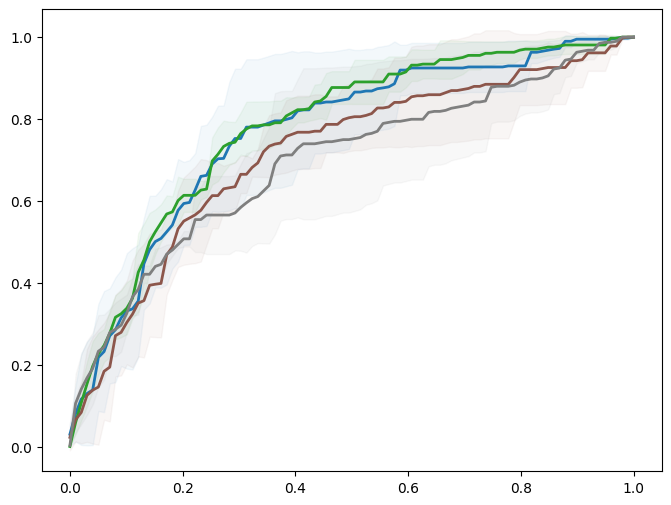

In [28]:
# With validated datasets
# update 03-29-25

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing3.csv',
                 './Datasets/real_testing/Testing4.csv',
                ]
pre_fix = "5sgRNA_Val_set_1_4_5_new"
datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
PATH_cripsr_net = './New_evaluation/Testing/crispr_net_'
PATH_cripsr_ip  = './New_evaluation/Testing/crispr_ip_'
PATH_r_cripsr  = './New_evaluation/Testing/r_crispr_'
PATH_cripsr_m  = './New_evaluation/Testing/crispr_m_'
PATH_cripsr_sgru  = './New_evaluation/Testing/crispr_sgru_'

## set 1
pred_scores_crispr_net_0 = np.load(PATH_cripsr_net + datasets[0] + '_1.npy')
pred_scores_crispr_net_1 = np.load(PATH_cripsr_net + datasets[1] + '_1.npy')
pred_scores_crispr_net_2 = np.load(PATH_cripsr_net + datasets[2] + '_1.npy')
pred_scores_crispr_net_3 = np.load(PATH_cripsr_net + datasets[3] + '_1.npy')
pred_scores_crispr_net_4 = np.load(PATH_cripsr_net + datasets[4] + '_1.npy')
pred_scores_crispr_net_5 = np.load(PATH_cripsr_net + datasets[5] + '_1.npy')

pred_scores_crispr_ip_0 = np.load(PATH_cripsr_ip + datasets[0] + '_1.npy')
pred_scores_crispr_ip_1 = np.load(PATH_cripsr_ip + datasets[1] + '_1.npy')
pred_scores_crispr_ip_2 = np.load(PATH_cripsr_ip + datasets[2] + '_1.npy')
pred_scores_crispr_ip_3 = np.load(PATH_cripsr_ip + datasets[3] + '_1.npy')
pred_scores_crispr_ip_4 = np.load(PATH_cripsr_ip + datasets[4] + '_1.npy')
pred_scores_crispr_ip_5 = np.load(PATH_cripsr_ip + datasets[5] + '_1.npy')

pred_scores_r_crispr_0 = np.load(PATH_r_cripsr + datasets[0] + '_1.npy')
pred_scores_r_crispr_1 = np.load(PATH_r_cripsr + datasets[1] + '_1.npy')
pred_scores_r_crispr_2 = np.load(PATH_r_cripsr + datasets[2] + '_1.npy')
pred_scores_r_crispr_3 = np.load(PATH_r_cripsr + datasets[3] + '_1.npy')
pred_scores_r_crispr_4 = np.load(PATH_r_cripsr + datasets[4] + '_1.npy')
pred_scores_r_crispr_5 = np.load(PATH_r_cripsr + datasets[5] + '_1.npy')

pred_scores_crispr_m_0 = np.load(PATH_cripsr_m + datasets[0] + '_1.npy')
pred_scores_crispr_m_1 = np.load(PATH_cripsr_m + datasets[1] + '_1.npy')
pred_scores_crispr_m_2 = np.load(PATH_cripsr_m + datasets[2] + '_1.npy')
pred_scores_crispr_m_3 = np.load(PATH_cripsr_m + datasets[3] + '_1.npy')
pred_scores_crispr_m_4 = np.load(PATH_cripsr_m + datasets[4] + '_1.npy')
pred_scores_crispr_m_5 = np.load(PATH_cripsr_m + datasets[5] + '_1.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

# pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + '_1.npy')
# pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_1.npy')
# pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + '_1.npy')
# pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + '_1.npy')
# pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + '_1.npy')
# pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + '_1.npy')

## set 4

pred_scores_crispr_net_0_1 = np.load(PATH_cripsr_net + datasets[0] + '_7.npy')
pred_scores_crispr_net_1_1 = np.load(PATH_cripsr_net + datasets[1] + '_7.npy')
pred_scores_crispr_net_2_1 = np.load(PATH_cripsr_net + datasets[2] + '_7.npy')
pred_scores_crispr_net_3_1 = np.load(PATH_cripsr_net + datasets[3] + '_7.npy')
pred_scores_crispr_net_4_1 = np.load(PATH_cripsr_net + datasets[4] + '_7.npy')
pred_scores_crispr_net_5_1 = np.load(PATH_cripsr_net + datasets[5] + '_7.npy')

pred_scores_crispr_ip_0_1 = np.load(PATH_cripsr_ip + datasets[0] + '_7.npy')
pred_scores_crispr_ip_1_1 = np.load(PATH_cripsr_ip + datasets[1] + '_7.npy')
pred_scores_crispr_ip_2_1 = np.load(PATH_cripsr_ip + datasets[2] + '_7.npy')
pred_scores_crispr_ip_3_1 = np.load(PATH_cripsr_ip + datasets[3] + '_7.npy')
pred_scores_crispr_ip_4_1 = np.load(PATH_cripsr_ip + datasets[4] + '_7.npy')
pred_scores_crispr_ip_5_1 = np.load(PATH_cripsr_ip + datasets[5] + '_7.npy')

pred_scores_r_crispr_0_1 = np.load(PATH_r_cripsr + datasets[0] + '_7.npy')
pred_scores_r_crispr_1_1 = np.load(PATH_r_cripsr + datasets[1] + '_7.npy')
pred_scores_r_crispr_2_1 = np.load(PATH_r_cripsr + datasets[2] + '_7.npy')
pred_scores_r_crispr_3_1 = np.load(PATH_r_cripsr + datasets[3] + '_7.npy')
pred_scores_r_crispr_4_1 = np.load(PATH_r_cripsr + datasets[4] + '_7.npy')
pred_scores_r_crispr_5_1 = np.load(PATH_r_cripsr + datasets[5] + '_7.npy')

pred_scores_crispr_m_0_1 = np.load(PATH_cripsr_m + datasets[0] + '_7.npy')
pred_scores_crispr_m_1_1 = np.load(PATH_cripsr_m + datasets[1] + '_7.npy')
pred_scores_crispr_m_2_1 = np.load(PATH_cripsr_m + datasets[2] + '_7.npy')
pred_scores_crispr_m_3_1 = np.load(PATH_cripsr_m + datasets[3] + '_7.npy')
pred_scores_crispr_m_4_1 = np.load(PATH_cripsr_m + datasets[4] + '_7.npy')
pred_scores_crispr_m_5_1 = np.load(PATH_cripsr_m + datasets[5] + '_7.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_sgru_0_1 = np.load(PATH_cripsr_sgru + datasets[0] + '_7.npy')
pred_scores_crispr_sgru_1_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_7.npy')
pred_scores_crispr_sgru_2_1 = np.load(PATH_cripsr_sgru + datasets[2] + '_7.npy')
pred_scores_crispr_sgru_3_1 = np.load(PATH_cripsr_sgru + datasets[3] + '_7.npy')
pred_scores_crispr_sgru_4_1 = np.load(PATH_cripsr_sgru + datasets[4] + '_7.npy')
pred_scores_crispr_sgru_5_1 = np.load(PATH_cripsr_sgru + datasets[5] + '_7.npy')



## set 5

pred_scores_crispr_net_0_2 = np.load(PATH_cripsr_net + datasets[0] + '_9.npy')
pred_scores_crispr_net_1_2 = np.load(PATH_cripsr_net + datasets[1] + '_9.npy')
pred_scores_crispr_net_2_2= np.load(PATH_cripsr_net + datasets[2] + '_9.npy')
pred_scores_crispr_net_3_2 = np.load(PATH_cripsr_net + datasets[3] + '_9.npy')
pred_scores_crispr_net_4_2 = np.load(PATH_cripsr_net + datasets[4] + '_9.npy')
pred_scores_crispr_net_5_2 = np.load(PATH_cripsr_net + datasets[5] + '_9.npy')

pred_scores_crispr_ip_0_2 = np.load(PATH_cripsr_ip + datasets[0] + '_9.npy')
pred_scores_crispr_ip_1_2 = np.load(PATH_cripsr_ip + datasets[1] + '_9.npy')
pred_scores_crispr_ip_2_2 = np.load(PATH_cripsr_ip + datasets[2] + '_9.npy')
pred_scores_crispr_ip_3_2 = np.load(PATH_cripsr_ip + datasets[3] + '_9.npy')
pred_scores_crispr_ip_4_2 = np.load(PATH_cripsr_ip + datasets[4] + '_9.npy')
pred_scores_crispr_ip_5_2 = np.load(PATH_cripsr_ip + datasets[5] + '_9.npy')

pred_scores_r_crispr_0_2 = np.load(PATH_r_cripsr + datasets[0] + '_9.npy')
pred_scores_r_crispr_1_2 = np.load(PATH_r_cripsr + datasets[1] + '_9.npy')
pred_scores_r_crispr_2_2 = np.load(PATH_r_cripsr + datasets[2] + '_9.npy')
pred_scores_r_crispr_3_2 = np.load(PATH_r_cripsr + datasets[3] + '_9.npy')
pred_scores_r_crispr_4_2 = np.load(PATH_r_cripsr + datasets[4] + '_9.npy')
pred_scores_r_crispr_5_2 = np.load(PATH_r_cripsr + datasets[5] + '_9.npy')

pred_scores_crispr_m_0_2 = np.load(PATH_cripsr_m + datasets[0] + '_9.npy')
pred_scores_crispr_m_1_2 = np.load(PATH_cripsr_m + datasets[1] + '_9.npy')
pred_scores_crispr_m_2_2 = np.load(PATH_cripsr_m + datasets[2] + '_9.npy')
pred_scores_crispr_m_3_2 = np.load(PATH_cripsr_m + datasets[3] + '_9.npy')
pred_scores_crispr_m_4_2 = np.load(PATH_cripsr_m + datasets[4] + '_9.npy')
pred_scores_crispr_m_5_2 = np.load(PATH_cripsr_m + datasets[5] + '_9.npy')


predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1, pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1, pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1, pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1, pred_scores_crispr_m_0_2],
    #"CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1,pred_scores_crispr_sgru_0_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1, pred_scores_crispr_net_1_2],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1, pred_scores_crispr_ip_1_2],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1, pred_scores_r_crispr_1_2],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1, pred_scores_crispr_m_1_2],
    #"CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1,pred_scores_crispr_sgru_1_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1, pred_scores_crispr_net_2_2],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1, pred_scores_crispr_ip_2_2],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1, pred_scores_r_crispr_2_2],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1, pred_scores_crispr_m_2_2],
    #"CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1,pred_scores_crispr_sgru_2_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1, pred_scores_crispr_net_3_2],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1, pred_scores_crispr_ip_3_2],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1, pred_scores_r_crispr_3_2],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1, pred_scores_crispr_m_3_2],
    #"CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1,pred_scores_crispr_sgru_3_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1, pred_scores_crispr_net_4_2],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1, pred_scores_crispr_ip_4_2],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1, pred_scores_r_crispr_4_2],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1, pred_scores_crispr_m_4_2],
    #"CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1,pred_scores_crispr_sgru_4_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1, pred_scores_crispr_net_5_2],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1, pred_scores_crispr_ip_5_2],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1, pred_scores_r_crispr_5_2],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1, pred_scores_crispr_m_5_2],
    #"CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1,pred_scores_crispr_sgru_5_2]
})




all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

In [36]:
# With validated datasets
# update 03-29-25

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing3.csv',
                 #'./Datasets/real_testing/Testing4.csv',
                ]
pre_fix = "5sgRNA_Val_set_1_4_new"
datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
PATH_cripsr_net = './New_evaluation/Testing/crispr_net_'
PATH_cripsr_ip  = './New_evaluation/Testing/crispr_ip_'
PATH_r_cripsr  = './New_evaluation/Testing/r_crispr_'
PATH_cripsr_m  = './New_evaluation/Testing/crispr_m_'
PATH_cripsr_sgru  = './New_evaluation/Testing/crispr_sgru_'

## set 1
pred_scores_crispr_net_0 = np.load(PATH_cripsr_net + datasets[0] + '_1.npy')
pred_scores_crispr_net_1 = np.load(PATH_cripsr_net + datasets[1] + '_1.npy')
pred_scores_crispr_net_2 = np.load(PATH_cripsr_net + datasets[2] + '_1.npy')
pred_scores_crispr_net_3 = np.load(PATH_cripsr_net + datasets[3] + '_1.npy')
pred_scores_crispr_net_4 = np.load(PATH_cripsr_net + datasets[4] + '_1.npy')
pred_scores_crispr_net_5 = np.load(PATH_cripsr_net + datasets[5] + '_1.npy')

pred_scores_crispr_ip_0 = np.load(PATH_cripsr_ip + datasets[0] + '_1.npy')
pred_scores_crispr_ip_1 = np.load(PATH_cripsr_ip + datasets[1] + '_1.npy')
pred_scores_crispr_ip_2 = np.load(PATH_cripsr_ip + datasets[2] + '_1.npy')
pred_scores_crispr_ip_3 = np.load(PATH_cripsr_ip + datasets[3] + '_1.npy')
pred_scores_crispr_ip_4 = np.load(PATH_cripsr_ip + datasets[4] + '_1.npy')
pred_scores_crispr_ip_5 = np.load(PATH_cripsr_ip + datasets[5] + '_1.npy')

pred_scores_r_crispr_0 = np.load(PATH_r_cripsr + datasets[0] + '_1.npy')
pred_scores_r_crispr_1 = np.load(PATH_r_cripsr + datasets[1] + '_1.npy')
pred_scores_r_crispr_2 = np.load(PATH_r_cripsr + datasets[2] + '_1.npy')
pred_scores_r_crispr_3 = np.load(PATH_r_cripsr + datasets[3] + '_1.npy')
pred_scores_r_crispr_4 = np.load(PATH_r_cripsr + datasets[4] + '_1.npy')
pred_scores_r_crispr_5 = np.load(PATH_r_cripsr + datasets[5] + '_1.npy')

pred_scores_crispr_m_0 = np.load(PATH_cripsr_m + datasets[0] + '_1.npy')
pred_scores_crispr_m_1 = np.load(PATH_cripsr_m + datasets[1] + '_1.npy')
pred_scores_crispr_m_2 = np.load(PATH_cripsr_m + datasets[2] + '_1.npy')
pred_scores_crispr_m_3 = np.load(PATH_cripsr_m + datasets[3] + '_1.npy')
pred_scores_crispr_m_4 = np.load(PATH_cripsr_m + datasets[4] + '_1.npy')
pred_scores_crispr_m_5 = np.load(PATH_cripsr_m + datasets[5] + '_1.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

# pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + '_1.npy')
# pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_1.npy')
# pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + '_1.npy')
# pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + '_1.npy')
# pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + '_1.npy')
# pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + '_1.npy')

## set 4

pred_scores_crispr_net_0_1 = np.load(PATH_cripsr_net + datasets[0] + '_7.npy')
pred_scores_crispr_net_1_1 = np.load(PATH_cripsr_net + datasets[1] + '_7.npy')
pred_scores_crispr_net_2_1 = np.load(PATH_cripsr_net + datasets[2] + '_7.npy')
pred_scores_crispr_net_3_1 = np.load(PATH_cripsr_net + datasets[3] + '_7.npy')
pred_scores_crispr_net_4_1 = np.load(PATH_cripsr_net + datasets[4] + '_7.npy')
pred_scores_crispr_net_5_1 = np.load(PATH_cripsr_net + datasets[5] + '_7.npy')

pred_scores_crispr_ip_0_1 = np.load(PATH_cripsr_ip + datasets[0] + '_7.npy')
pred_scores_crispr_ip_1_1 = np.load(PATH_cripsr_ip + datasets[1] + '_7.npy')
pred_scores_crispr_ip_2_1 = np.load(PATH_cripsr_ip + datasets[2] + '_7.npy')
pred_scores_crispr_ip_3_1 = np.load(PATH_cripsr_ip + datasets[3] + '_7.npy')
pred_scores_crispr_ip_4_1 = np.load(PATH_cripsr_ip + datasets[4] + '_7.npy')
pred_scores_crispr_ip_5_1 = np.load(PATH_cripsr_ip + datasets[5] + '_7.npy')

pred_scores_r_crispr_0_1 = np.load(PATH_r_cripsr + datasets[0] + '_7.npy')
pred_scores_r_crispr_1_1 = np.load(PATH_r_cripsr + datasets[1] + '_7.npy')
pred_scores_r_crispr_2_1 = np.load(PATH_r_cripsr + datasets[2] + '_7.npy')
pred_scores_r_crispr_3_1 = np.load(PATH_r_cripsr + datasets[3] + '_7.npy')
pred_scores_r_crispr_4_1 = np.load(PATH_r_cripsr + datasets[4] + '_7.npy')
pred_scores_r_crispr_5_1 = np.load(PATH_r_cripsr + datasets[5] + '_7.npy')

pred_scores_crispr_m_0_1 = np.load(PATH_cripsr_m + datasets[0] + '_7.npy')
pred_scores_crispr_m_1_1 = np.load(PATH_cripsr_m + datasets[1] + '_7.npy')
pred_scores_crispr_m_2_1 = np.load(PATH_cripsr_m + datasets[2] + '_7.npy')
pred_scores_crispr_m_3_1 = np.load(PATH_cripsr_m + datasets[3] + '_7.npy')
pred_scores_crispr_m_4_1 = np.load(PATH_cripsr_m + datasets[4] + '_7.npy')
pred_scores_crispr_m_5_1 = np.load(PATH_cripsr_m + datasets[5] + '_7.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_sgru_0_1 = np.load(PATH_cripsr_sgru + datasets[0] + '_7.npy')
pred_scores_crispr_sgru_1_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_7.npy')
pred_scores_crispr_sgru_2_1 = np.load(PATH_cripsr_sgru + datasets[2] + '_7.npy')
pred_scores_crispr_sgru_3_1 = np.load(PATH_cripsr_sgru + datasets[3] + '_7.npy')
pred_scores_crispr_sgru_4_1 = np.load(PATH_cripsr_sgru + datasets[4] + '_7.npy')
pred_scores_crispr_sgru_5_1 = np.load(PATH_cripsr_sgru + datasets[5] + '_7.npy')



## set 5

pred_scores_crispr_net_0_2 = np.load(PATH_cripsr_net + datasets[0] + '_9.npy')
pred_scores_crispr_net_1_2 = np.load(PATH_cripsr_net + datasets[1] + '_9.npy')
pred_scores_crispr_net_2_2= np.load(PATH_cripsr_net + datasets[2] + '_9.npy')
pred_scores_crispr_net_3_2 = np.load(PATH_cripsr_net + datasets[3] + '_9.npy')
pred_scores_crispr_net_4_2 = np.load(PATH_cripsr_net + datasets[4] + '_9.npy')
pred_scores_crispr_net_5_2 = np.load(PATH_cripsr_net + datasets[5] + '_9.npy')

pred_scores_crispr_ip_0_2 = np.load(PATH_cripsr_ip + datasets[0] + '_9.npy')
pred_scores_crispr_ip_1_2 = np.load(PATH_cripsr_ip + datasets[1] + '_9.npy')
pred_scores_crispr_ip_2_2 = np.load(PATH_cripsr_ip + datasets[2] + '_9.npy')
pred_scores_crispr_ip_3_2 = np.load(PATH_cripsr_ip + datasets[3] + '_9.npy')
pred_scores_crispr_ip_4_2 = np.load(PATH_cripsr_ip + datasets[4] + '_9.npy')
pred_scores_crispr_ip_5_2 = np.load(PATH_cripsr_ip + datasets[5] + '_9.npy')

pred_scores_r_crispr_0_2 = np.load(PATH_r_cripsr + datasets[0] + '_9.npy')
pred_scores_r_crispr_1_2 = np.load(PATH_r_cripsr + datasets[1] + '_9.npy')
pred_scores_r_crispr_2_2 = np.load(PATH_r_cripsr + datasets[2] + '_9.npy')
pred_scores_r_crispr_3_2 = np.load(PATH_r_cripsr + datasets[3] + '_9.npy')
pred_scores_r_crispr_4_2 = np.load(PATH_r_cripsr + datasets[4] + '_9.npy')
pred_scores_r_crispr_5_2 = np.load(PATH_r_cripsr + datasets[5] + '_9.npy')

pred_scores_crispr_m_0_2 = np.load(PATH_cripsr_m + datasets[0] + '_9.npy')
pred_scores_crispr_m_1_2 = np.load(PATH_cripsr_m + datasets[1] + '_9.npy')
pred_scores_crispr_m_2_2 = np.load(PATH_cripsr_m + datasets[2] + '_9.npy')
pred_scores_crispr_m_3_2 = np.load(PATH_cripsr_m + datasets[3] + '_9.npy')
pred_scores_crispr_m_4_2 = np.load(PATH_cripsr_m + datasets[4] + '_9.npy')
pred_scores_crispr_m_5_2 = np.load(PATH_cripsr_m + datasets[5] + '_9.npy')


predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1],
    #"CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1],
    #"CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1,],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1],
    #"CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1],
    #"CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1],
    #"CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1],
    #"CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1]
})




all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_Val_set_1_4_newHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_4_newHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2674 ± 0.1612  0.9250 ± 0.0750  0.3944 ± 0.2056   
1    CRISPR-IP  0.3208 ± 0.1792  0.8250 ± 0.0250  0.4291 ± 0.1863   
2     R-CRISPR  0.2644 ± 0.1550  0.7833 ± 0.0833  0.3772 ± 0.1880   
3     CRISPR-M  0.2849 ± 0.1979  0.8667 ± 0.0667  0.3966 ± 0.2398   
4  Crispr-SGRU  0.2550 ± 0.1513  0.7833 ± 0.0833  0.3669 ± 0.1863   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2861 ± 0.1768  0.7537 ± 0.0927  0.3624 ± 0.2181       0.4982  
1  0.3276 ± 0.1214  0.7893 ± 0.0297  0.3826 ± 0.1742       0.5124  
2  0.2341 ± 0.1401  0.6877 ± 0.0854  0.3239 ± 0.1846       0.4451  
3  0.2541 ± 0.2439  0.7134 ± 0.1030  0.3760 ± 0.2232       0.4820  
4  0.2149 ± 0.1387  0.6638 ± 0.0864  0.3162 ± 0.2106       0.4334  
Metrics table saved to 5s

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_Val_set_1_4_newII4/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_4_newII4/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2492 ± 0.1427  0.9333 ± 0.0333  0.3741 ± 0.1836   
1    CRISPR-IP  0.2750 ± 0.1614  0.7750 ± 0.0250  0.3810 ± 0.1837   
2     R-CRISPR  0.2648 ± 0.1595  0.8667 ± 0.0667  0.3847 ± 0.1986   
3     CRISPR-M  0.2727 ± 0.1696  0.8083 ± 0.0417  0.3724 ± 0.1886   
4  Crispr-SGRU  0.3872 ± 0.2086  0.8417 ± 0.0917  0.5079 ± 0.2194   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2525 ± 0.1311  0.6883 ± 0.0813  0.3256 ± 0.1951       0.4705  
1  0.2410 ± 0.1264  0.7075 ± 0.0645  0.3092 ± 0.1731       0.4481  
2  0.2565 ± 0.1601  0.7503 ± 0.0993  0.3902 ± 0.2413       0.4855  
3  0.2288 ± 0.1317  0.6948 ± 0.0617  0.3337 ± 0.1976       0.4518  
4  0.4378 ± 0.1886  0.8006 ± 0.0809  0.4578 ± 0.2003       0.5722  
Metrics table saved to 5sgRNA_Val

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


Precision-Recall curve saved to 5sgRNA_Val_set_1_4_newII5/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2636 ± 0.1097  0.8667 ± 0.0667  0.3957 ± 0.1376   
1    CRISPR-IP  0.2446 ± 0.1287  0.9417 ± 0.0083  0.3699 ± 0.1634   
2     R-CRISPR  0.3050 ± 0.1481  0.8833 ± 0.0833  0.4397 ± 0.1774   
3     CRISPR-M  0.2556 ± 0.1506  0.9083 ± 0.0417  0.3711 ± 0.1821   
4  Crispr-SGRU  0.3237 ± 0.1208  0.4833 ± 0.2167  0.3240 ± 0.0094   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2747 ± 0.0560  0.7963 ± 0.0043  0.4479 ± 0.1233       0.5075  
1  0.2485 ± 0.0822  0.7150 ± 0.0282  0.2881 ± 0.1500       0.4680  
2  0.3511 ± 0.1267  0.7636 ± 0.0304  0.4073 ± 0.1211       0.5250  
3  0.2413 ± 0.1124  0.7299 ± 0.0074  0.3081 ± 0.1227       0.4691  
4  0.2211 ± 0.0505  0.7771 ± 0.0007  0.5404 ± 0.0093       0.4449  
Metrics table saved to 5sgRNA_Val_set_1_4_newII5.csv
ROC curve saved to 5sgRNA_Val_set_1_4_n

In [35]:
# With validated datasets
# update 03-29-25

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing3.csv',
                 #'./Datasets/real_testing/Testing4.csv',
                ]
pre_fix = "5sgRNA_noVal_set_1_4_new"
datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
PATH_cripsr_net = './New_evaluation/Testing/crispr_net_'
PATH_cripsr_ip  = './New_evaluation/Testing/crispr_ip_'
PATH_r_cripsr  = './New_evaluation/Testing/r_crispr_'
PATH_cripsr_m  = './New_evaluation/Testing/crispr_m_'
PATH_cripsr_sgru  = './New_evaluation/Testing/crispr_sgru_'

## set 1
pred_scores_crispr_net_0 = np.load(PATH_cripsr_net + datasets[0] + '_0.npy')
pred_scores_crispr_net_1 = np.load(PATH_cripsr_net + datasets[1] + '_0.npy')
pred_scores_crispr_net_2 = np.load(PATH_cripsr_net + datasets[2] + '_0.npy')
pred_scores_crispr_net_3 = np.load(PATH_cripsr_net + datasets[3] + '_0.npy')
pred_scores_crispr_net_4 = np.load(PATH_cripsr_net + datasets[4] + '_0.npy')
pred_scores_crispr_net_5 = np.load(PATH_cripsr_net + datasets[5] + '_0.npy')

pred_scores_crispr_ip_0 = np.load(PATH_cripsr_ip + datasets[0] + '_0.npy')
pred_scores_crispr_ip_1 = np.load(PATH_cripsr_ip + datasets[1] + '_0.npy')
pred_scores_crispr_ip_2 = np.load(PATH_cripsr_ip + datasets[2] + '_0.npy')
pred_scores_crispr_ip_3 = np.load(PATH_cripsr_ip + datasets[3] + '_0.npy')
pred_scores_crispr_ip_4 = np.load(PATH_cripsr_ip + datasets[4] + '_0.npy')
pred_scores_crispr_ip_5 = np.load(PATH_cripsr_ip + datasets[5] + '_0.npy')

pred_scores_r_crispr_0 = np.load(PATH_r_cripsr + datasets[0] + '_0.npy')
pred_scores_r_crispr_1 = np.load(PATH_r_cripsr + datasets[1] + '_0.npy')
pred_scores_r_crispr_2 = np.load(PATH_r_cripsr + datasets[2] + '_0.npy')
pred_scores_r_crispr_3 = np.load(PATH_r_cripsr + datasets[3] + '_0.npy')
pred_scores_r_crispr_4 = np.load(PATH_r_cripsr + datasets[4] + '_0.npy')
pred_scores_r_crispr_5 = np.load(PATH_r_cripsr + datasets[5] + '_0.npy')

pred_scores_crispr_m_0 = np.load(PATH_cripsr_m + datasets[0] + '_0.npy')
pred_scores_crispr_m_1 = np.load(PATH_cripsr_m + datasets[1] + '_0.npy')
pred_scores_crispr_m_2 = np.load(PATH_cripsr_m + datasets[2] + '_0.npy')
pred_scores_crispr_m_3 = np.load(PATH_cripsr_m + datasets[3] + '_0.npy')
pred_scores_crispr_m_4 = np.load(PATH_cripsr_m + datasets[4] + '_0.npy')
pred_scores_crispr_m_5 = np.load(PATH_cripsr_m + datasets[5] + '_0.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + '_0.npy')
pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_0.npy')
pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + '_0.npy')
pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + '_0.npy')
pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + '_0.npy')
pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + '_0.npy')

## set 4

pred_scores_crispr_net_0_1 = np.load(PATH_cripsr_net + datasets[0] + '_6.npy')
pred_scores_crispr_net_1_1 = np.load(PATH_cripsr_net + datasets[1] + '_6.npy')
pred_scores_crispr_net_2_1 = np.load(PATH_cripsr_net + datasets[2] + '_6.npy')
pred_scores_crispr_net_3_1 = np.load(PATH_cripsr_net + datasets[3] + '_6.npy')
pred_scores_crispr_net_4_1 = np.load(PATH_cripsr_net + datasets[4] + '_6.npy')
pred_scores_crispr_net_5_1 = np.load(PATH_cripsr_net + datasets[5] + '_6.npy')

pred_scores_crispr_ip_0_1 = np.load(PATH_cripsr_ip + datasets[0] + '_6.npy')
pred_scores_crispr_ip_1_1 = np.load(PATH_cripsr_ip + datasets[1] + '_6.npy')
pred_scores_crispr_ip_2_1 = np.load(PATH_cripsr_ip + datasets[2] + '_6.npy')
pred_scores_crispr_ip_3_1 = np.load(PATH_cripsr_ip + datasets[3] + '_6.npy')
pred_scores_crispr_ip_4_1 = np.load(PATH_cripsr_ip + datasets[4] + '_6.npy')
pred_scores_crispr_ip_5_1 = np.load(PATH_cripsr_ip + datasets[5] + '_6.npy')

pred_scores_r_crispr_0_1 = np.load(PATH_r_cripsr + datasets[0] + '_6.npy')
pred_scores_r_crispr_1_1 = np.load(PATH_r_cripsr + datasets[1] + '_6.npy')
pred_scores_r_crispr_2_1 = np.load(PATH_r_cripsr + datasets[2] + '_6.npy')
pred_scores_r_crispr_3_1 = np.load(PATH_r_cripsr + datasets[3] + '_6.npy')
pred_scores_r_crispr_4_1 = np.load(PATH_r_cripsr + datasets[4] + '_6.npy')
pred_scores_r_crispr_5_1 = np.load(PATH_r_cripsr + datasets[5] + '_6.npy')

pred_scores_crispr_m_0_1 = np.load(PATH_cripsr_m + datasets[0] + '_6.npy')
pred_scores_crispr_m_1_1 = np.load(PATH_cripsr_m + datasets[1] + '_6.npy')
pred_scores_crispr_m_2_1 = np.load(PATH_cripsr_m + datasets[2] + '_6.npy')
pred_scores_crispr_m_3_1 = np.load(PATH_cripsr_m + datasets[3] + '_6.npy')
pred_scores_crispr_m_4_1 = np.load(PATH_cripsr_m + datasets[4] + '_6.npy')
pred_scores_crispr_m_5_1 = np.load(PATH_cripsr_m + datasets[5] + '_6.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_sgru_0_1 = np.load(PATH_cripsr_sgru + datasets[0] + '_6.npy')
pred_scores_crispr_sgru_1_1 = np.load(PATH_cripsr_sgru + datasets[1] + '_6.npy')
pred_scores_crispr_sgru_2_1 = np.load(PATH_cripsr_sgru + datasets[2] + '_6.npy')
pred_scores_crispr_sgru_3_1 = np.load(PATH_cripsr_sgru + datasets[3] + '_6.npy')
pred_scores_crispr_sgru_4_1 = np.load(PATH_cripsr_sgru + datasets[4] + '_6.npy')
pred_scores_crispr_sgru_5_1 = np.load(PATH_cripsr_sgru + datasets[5] + '_6.npy')



## set 5

pred_scores_crispr_net_0_2 = np.load(PATH_cripsr_net + datasets[0] + '_8.npy')
pred_scores_crispr_net_1_2 = np.load(PATH_cripsr_net + datasets[1] + '_8.npy')
pred_scores_crispr_net_2_2= np.load(PATH_cripsr_net + datasets[2] + '_8.npy')
pred_scores_crispr_net_3_2 = np.load(PATH_cripsr_net + datasets[3] + '_8.npy')
pred_scores_crispr_net_4_2 = np.load(PATH_cripsr_net + datasets[4] + '_8.npy')
pred_scores_crispr_net_5_2 = np.load(PATH_cripsr_net + datasets[5] + '_8.npy')

pred_scores_crispr_ip_0_2 = np.load(PATH_cripsr_ip + datasets[0] + '_8.npy')
pred_scores_crispr_ip_1_2 = np.load(PATH_cripsr_ip + datasets[1] + '_8.npy')
pred_scores_crispr_ip_2_2 = np.load(PATH_cripsr_ip + datasets[2] + '_8.npy')
pred_scores_crispr_ip_3_2 = np.load(PATH_cripsr_ip + datasets[3] + '_8.npy')
pred_scores_crispr_ip_4_2 = np.load(PATH_cripsr_ip + datasets[4] + '_8.npy')
pred_scores_crispr_ip_5_2 = np.load(PATH_cripsr_ip + datasets[5] + '_8.npy')

pred_scores_r_crispr_0_2 = np.load(PATH_r_cripsr + datasets[0] + '_8.npy')
pred_scores_r_crispr_1_2 = np.load(PATH_r_cripsr + datasets[1] + '_8.npy')
pred_scores_r_crispr_2_2 = np.load(PATH_r_cripsr + datasets[2] + '_8.npy')
pred_scores_r_crispr_3_2 = np.load(PATH_r_cripsr + datasets[3] + '_8.npy')
pred_scores_r_crispr_4_2 = np.load(PATH_r_cripsr + datasets[4] + '_8.npy')
pred_scores_r_crispr_5_2 = np.load(PATH_r_cripsr + datasets[5] + '_8.npy')

pred_scores_crispr_m_0_2 = np.load(PATH_cripsr_m + datasets[0] + '_8.npy')
pred_scores_crispr_m_1_2 = np.load(PATH_cripsr_m + datasets[1] + '_8.npy')
pred_scores_crispr_m_2_2 = np.load(PATH_cripsr_m + datasets[2] + '_8.npy')
pred_scores_crispr_m_3_2 = np.load(PATH_cripsr_m + datasets[3] + '_8.npy')
pred_scores_crispr_m_4_2 = np.load(PATH_cripsr_m + datasets[4] + '_8.npy')
pred_scores_crispr_m_5_2 = np.load(PATH_cripsr_m + datasets[5] + '_8.npy')

# pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
# pred_scores_crisprDNT_1 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal1.npy')
# pred_scores_crisprDNT_2 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal2.npy')
# pred_scores_crisprDNT_3 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal3.npy')
# pred_scores_crisprDNT_4 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal4.npy')
# pred_scores_crisprDNT_5 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal5.npy')

pred_scores_crispr_sgru_0_2 = np.load(PATH_cripsr_sgru + datasets[0] + '_8.npy')
pred_scores_crispr_sgru_1_2 = np.load(PATH_cripsr_sgru + datasets[1] + '_8.npy')
pred_scores_crispr_sgru_2_2 = np.load(PATH_cripsr_sgru + datasets[2] + '_8.npy')
pred_scores_crispr_sgru_3_2 = np.load(PATH_cripsr_sgru + datasets[3] + '_8.npy')
pred_scores_crispr_sgru_4_2 = np.load(PATH_cripsr_sgru + datasets[4] + '_8.npy')
pred_scores_crispr_sgru_5_2 = np.load(PATH_cripsr_sgru + datasets[5] + '_8.npy')


predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1],
    #"CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1],
    #"CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1,],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1],
    #"CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1],
    #"CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1],
    #"CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1],
    #"CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1]
})




all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_noVal_set_1_4_newHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noVal_set_1_4_newHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.3213 ± 0.0905  0.7667 ± 0.1667  0.4524 ± 0.1190   
1    CRISPR-IP  0.2240 ± 0.1342  0.7500 ± 0.0500  0.3270 ± 0.1679   
2     R-CRISPR  0.3402 ± 0.1202  0.7583 ± 0.2083  0.4690 ± 0.1547   
3     CRISPR-M  0.2513 ± 0.1487  0.9000 ± 0.1000  0.3766 ± 0.1948   
4  Crispr-SGRU  0.3112 ± 0.0950  0.6333 ± 0.2333  0.4169 ± 0.1362   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3375 ± 0.0597  0.7517 ± 0.0190  0.4762 ± 0.0508       0.5176  
1  0.1306 ± 0.1090  0.6060 ± 0.0773  0.2418 ± 0.1530       0.3799  
2  0.3692 ± 0.1184  0.7516 ± 0.0453  0.4654 ± 0.0639       0.5256  
3  0.2524 ± 0.1659  0.6929 ± 0.1558  0.3374 ± 0.2332       0.4684  
4  0.2782 ± 0.0755  0.7327 ± 0.0175  0.4400 ± 0.0869       0.4687  
Metrics table saved t

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_noVal_set_1_4_newII4/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_noVal_set_1_4_newII4/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.5793 ± 0.1793  0.5667 ± 0.1667  0.5729 ± 0.1729   
1    CRISPR-IP  0.4297 ± 0.3203  0.3750 ± 0.0250  0.3442 ± 0.1775   
2     R-CRISPR  0.5952 ± 0.0619  0.5833 ± 0.1833  0.5824 ± 0.1253   
3     CRISPR-M  0.7083 ± 0.0417  0.3500 ± 0.1500  0.4538 ± 0.1462   
4  Crispr-SGRU  0.3567 ± 0.2390  0.5667 ± 0.3667  0.4377 ± 0.2896   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.4984 ± 0.1544  0.8187 ± 0.0694  0.5703 ± 0.2194       0.6010  
1  0.2473 ± 0.1948  0.7602 ± 0.1081  0.4221 ± 0.3002       0.4298  
2  0.5044 ± 0.0852  0.8414 ± 0.0746  0.6374 ± 0.1378       0.6240  
3  0.4212 ± 0.0840  0.8097 ± 0.0740  0.5258 ± 0.1833       0.5448  
4  0.3370 ± 0.2895  0.7718 ± 0.1097  0.4022 ± 0.2559       0.4787  
Metrics table saved to 5sgRNA

/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_2657170/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


Precision-Recall curve saved to 5sgRNA_noVal_set_1_4_newII5/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2500 ± 0.2500  0.2000 ± 0.2000  0.2222 ± 0.2222   
1    CRISPR-IP  0.3333 ± 0.2667  0.2750 ± 0.1750  0.1438 ± 0.0276   
2     R-CRISPR  0.5649 ± 0.2922  0.1750 ± 0.0250  0.2589 ± 0.0654   
3     CRISPR-M  0.4123 ± 0.3377  0.1750 ± 0.0750  0.1457 ± 0.0308   
4  Crispr-SGRU  0.3131 ± 0.1313  0.1833 ± 0.0833  0.2312 ± 0.1022   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0948 ± 0.1748  0.6787 ± 0.0799  0.3489 ± 0.2385       0.2991  
1  0.0409 ± 0.1194  0.5117 ± 0.0874  0.2504 ± 0.1732       0.2592  
2  0.2454 ± 0.0967  0.6674 ± 0.0199  0.3699 ± 0.1718       0.3803  
3  0.0918 ± 0.1164  0.5573 ± 0.1548  0.2918 ± 0.2053       0.2790  
4  0.1235 ± 0.0470  0.7165 ± 0.0612  0.3492 ± 0.2005       0.3195  
Metrics table saved to 5sgRNA_noVal_set_1_4_newII5.csv
ROC curve saved to 5sgRNA_noVal_set

In [33]:
len(pred_scores_crispr_sgru_0)

773

In [14]:
len(pred_scores_crispr_net_1)

239

In [11]:
len(pred_scores_r_crispr_0)

239

In [12]:
len(label_test[0])

306

In [15]:
len(label_test[0])

306

In [ ]:
len(pred_scores_crispr_net_0)

/tmp/ipykernel_703624/152604135.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


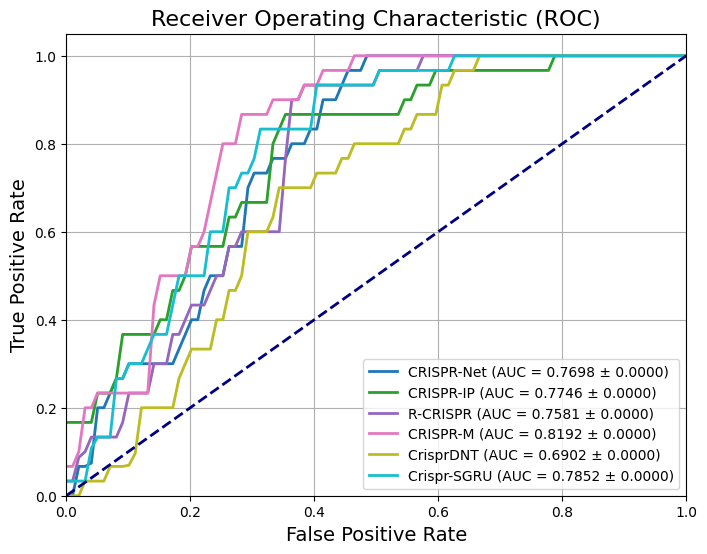

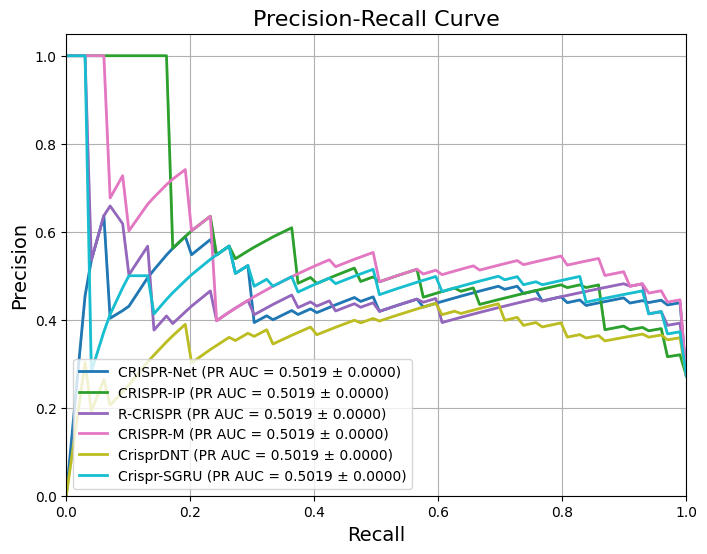

/tmp/ipykernel_703624/152604135.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.3704 ± 0.0000  1.0000 ± 0.0000  0.5405 ± 0.0000   
1    CRISPR-IP  0.3412 ± 0.0000  0.9667 ± 0.0000  0.5043 ± 0.0000   
2     R-CRISPR  0.3846 ± 0.0000  1.0000 ± 0.0000  0.5556 ± 0.0000   
3     CRISPR-M  0.4746 ± 0.0000  0.9333 ± 0.0000  0.6292 ± 0.0000   
4    CrisprDNT  0.2885 ± 0.0000  1.0000 ± 0.0000  0.4478 ± 0.0000   
5  Crispr-SGRU  0.3371 ± 0.0000  1.0000 ± 0.0000  0.5042 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3664 ± 0.0000  0.7698 ± 0.0000  0.4775 ± 0.0000       0.5874  
1  0.2834 ± 0.0000  0.7746 ± 0.0000  0.5769 ± 0.0000       0.5745  
2  0.3922 ± 0.0000  0.7581 ± 0.0000  0.4775 ± 0.0000       0.5947  
3  0.4875 ± 0.0000  0.8192 ± 0.0000  0.5738 ± 0.0000       0.6529  
4  0.1471 ± 0.0000  0.6902 ± 0.0000  0.3760 ± 0.0000       0.4916  
5  0.2975 ± 0.0000  0.7852 ± 0.0000  0.5019 ± 0.0000       0.5710  


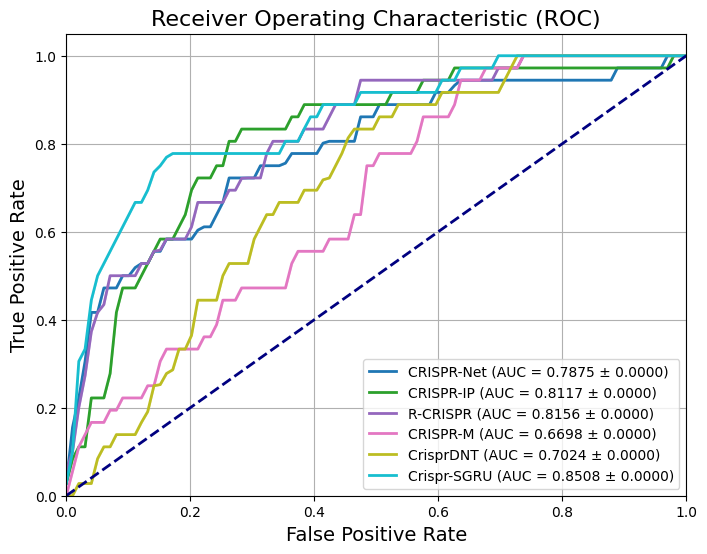

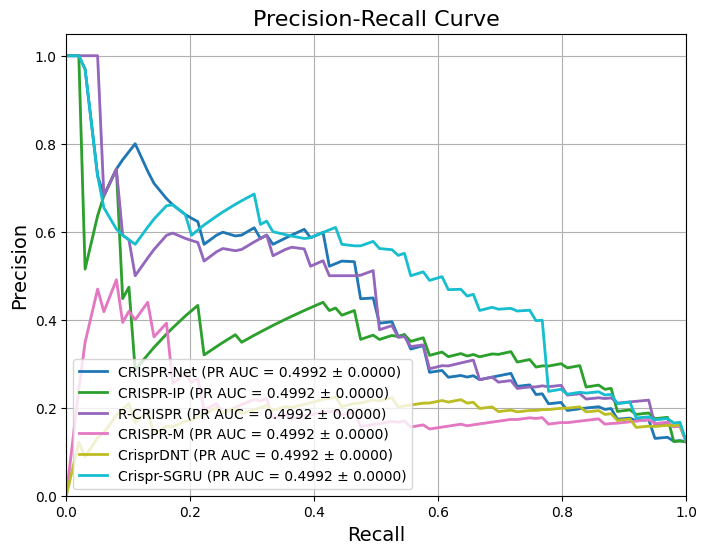

         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2137 ± 0.0000  0.7778 ± 0.0000  0.3353 ± 0.0000   
1    CRISPR-IP  0.3239 ± 0.0000  0.6389 ± 0.0000  0.4299 ± 0.0000   
2     R-CRISPR  0.2577 ± 0.0000  0.6944 ± 0.0000  0.3759 ± 0.0000   
3     CRISPR-M  0.2500 ± 0.0000  0.1944 ± 0.0000  0.2188 ± 0.0000   
4    CrisprDNT  0.1369 ± 0.0000  1.0000 ± 0.0000  0.2408 ± 0.0000   
5  Crispr-SGRU  0.4237 ± 0.0000  0.6944 ± 0.0000  0.5263 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2497 ± 0.0000  0.7875 ± 0.0000  0.4436 ± 0.0000       0.4679  
1  0.3468 ± 0.0000  0.8117 ± 0.0000  0.3770 ± 0.0000       0.4880  
2  0.2896 ± 0.0000  0.8156 ± 0.0000  0.4398 ± 0.0000       0.4789  
3  0.1262 ± 0.0000  0.6698 ± 0.0000  0.2280 ± 0.0000       0.2812  
4  0.1282 ± 0.0000  0.7024 ± 0.0000  0.1964 ± 0.0000       0.4008  
5  0.4605 ± 0.0000  0.8508 ± 0.0000  0.4992 ± 0.0000       0.5758  


/tmp/ipykernel_703624/152604135.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


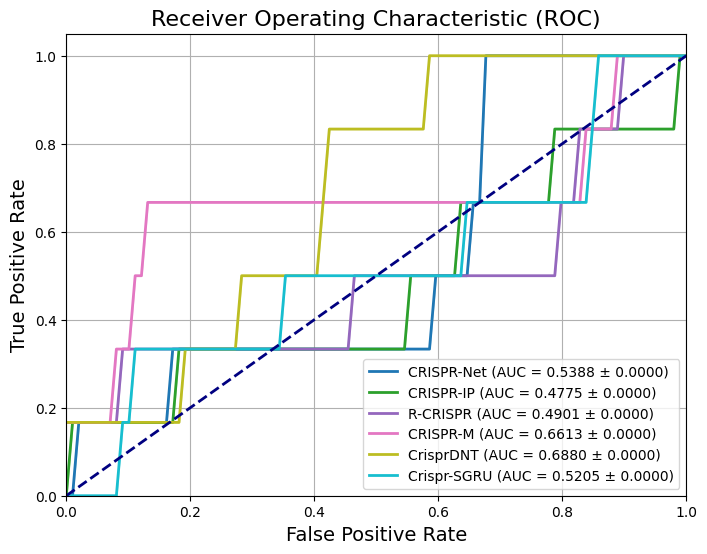

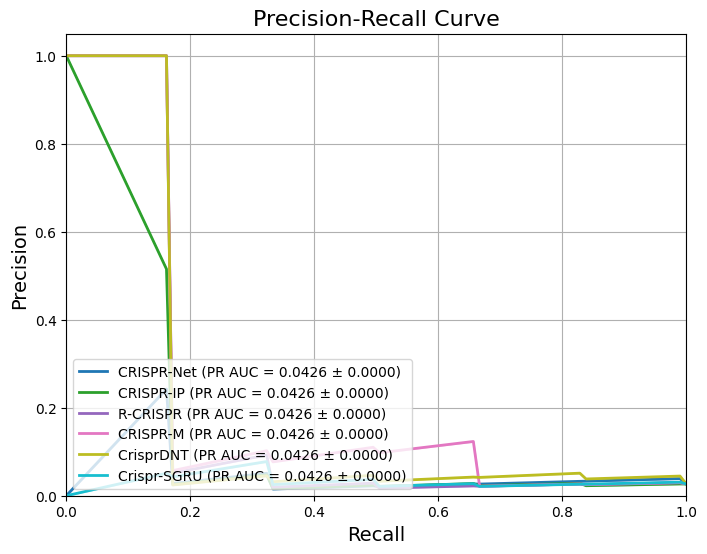

         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0244 ± 0.0000  0.3333 ± 0.0000  0.0455 ± 0.0000   
1    CRISPR-IP  0.0221 ± 0.0000  0.5000 ± 0.0000  0.0423 ± 0.0000   
2     R-CRISPR  0.0230 ± 0.0000  0.3333 ± 0.0000  0.0430 ± 0.0000   
3     CRISPR-M  0.1053 ± 0.0000  0.6667 ± 0.0000  0.1818 ± 0.0000   
4    CrisprDNT  0.1000 ± 0.0000  0.1667 ± 0.0000  0.1250 ± 0.0000   
5  Crispr-SGRU  0.0306 ± 0.0000  0.5000 ± 0.0000  0.0577 ± 0.0000   

                MCC            AUROC            PRAUC Overall_Mean  
0  -0.0107 ± 0.0000  0.5388 ± 0.0000  0.0708 ± 0.0000       0.1670  
1  -0.0354 ± 0.0000  0.4775 ± 0.0000  0.1094 ± 0.0000       0.1860  
2  -0.0181 ± 0.0000  0.4901 ± 0.0000  0.2005 ± 0.0000       0.1786  
3   0.2199 ± 0.0000  0.6613 ± 0.0000  0.2330 ± 0.0000       0.3447  
4   0.0982 ± 0.0000  0.6880 ± 0.0000  0.2055 ± 0.0000       0.2306  
5   0.0215 ± 0.0000  0.5205 ± 0.0000  0.0426 ± 0.0000       0.1955  


In [28]:
def ROC_with_metrics(y_test_list, predictions_dict, output_csv="metrics_table.csv"):
    """
    Plots averaged ROC and Precision-Recall curves for multiple sets of predictions 
    across cross-validation folds and saves a metrics table.

    Parameters:
        y_test_list (list of array-like): List of true binary labels for each fold.
        predictions_dict (dict): Dictionary where keys are labels and values are lists 
                                  of predicted scores for each fold.
        output_csv (str): Path to save the metrics table as a CSV file.
    """
    # Initialize plots
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap("tab10", len(predictions_dict))

    metrics_table = []

    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        roc_aucs = []
        pr_aucs = []

        precision_scores = []
        recall_scores = []
        f1_scores = []
        mcc_scores = []

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]

            # ROC-AUC computation
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            tprs.append(np.interp(mean_fpr, fpr, tpr))

            # Precision-Recall AUC computation
            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            pr_auc = average_precision_score(y_test, y_scores)
            pr_aucs.append(pr_auc)

            # Classification metrics
            binary_predictions = (y_scores >= 0.5).astype(int)
            precision_scores.append(precision_score(y_test, binary_predictions))
            recall_scores.append(recall_score(y_test, binary_predictions))
            f1_scores.append(f1_score(y_test, binary_predictions))
            mcc_scores.append(matthews_corrcoef(y_test, binary_predictions))

        # Compute mean and std for TPRs
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        mean_tpr[-1] = 1.0

        # Plot mean ROC curve
        color = colors(idx)
        plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
                 label=f"{label} (AUC = {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f})")
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=color, alpha=0.2)

        # Aggregate metrics for table
        metrics_table.append([
            label,
            f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
            f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
            f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
            f"{np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}",
            f"{np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}",
            f"{np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}",
            f"{np.mean([np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(mcc_scores), np.mean(roc_aucs), np.mean(pr_aucs)]):.4f}"
        ])

    # Finalize and show ROC plot
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Receiver Operating Characteristic (ROC)", fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        precisions = []
        recalls = []

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]
            precision, recall, _ = precision_recall_curve(y_test, y_scores)

            interpolated_recall = np.linspace(0, 1, 100)
            interpolated_precision = np.interp(interpolated_recall, recall[::-1], precision[::-1])
            precisions.append(interpolated_precision)

        # Compute mean and std for precision-recall
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)

        # Plot mean Precision-Recall curve
        color = colors(idx)
        plt.plot(interpolated_recall, mean_precision, color=color, lw=2,
                 label=f"{label} (PR AUC = {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f})")
        plt.fill_between(interpolated_recall, mean_precision - std_precision, mean_precision + std_precision,
                         color=color, alpha=0.2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # Create metrics DataFrame and save to CSV
    metrics_df = pd.DataFrame(metrics_table, columns=[
        "Model", "Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC", "Overall_Mean"
    ])
    print(metrics_df)
    #metrics_df.to_csv(output_csv, index=False)
    #print(f"Metrics table saved to {output_csv}")


# With validated datasets

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

## set 1
pred_scores_crispr_net_0 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val0.npy')
pred_scores_crispr_ip_0 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val0.npy')
pred_scores_r_crispr_0 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val0.npy')
pred_scores_crispr_m_0 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val0.npy')
pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val0.npy')
pred_scores_crispr_sgru_0 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val0.npy')

## set 2

pred_scores_crispr_net_0_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val0.npy')
pred_scores_crispr_ip_0_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val0.npy')
pred_scores_r_crispr_0_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val0.npy')
pred_scores_crispr_m_0_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val0.npy')
pred_scores_crisprDNT_0_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val0.npy')
pred_scores_crispr_sgru_0_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val0.npy')


## set 3

pred_scores_crispr_net_0_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_Val0.npy')
pred_scores_crispr_ip_0_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_Val0.npy')
pred_scores_r_crispr_0_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_Val0.npy')
pred_scores_crispr_m_0_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_Val0.npy')
pred_scores_crisprDNT_0_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_Val0.npy')
pred_scores_crispr_sgru_0_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_Val0.npy')

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list = {
    "CRISPR-Net": [pred_scores_crispr_net_0],
    "CRISPR-IP": [pred_scores_crispr_ip_0],
    "R-CRISPR" : [pred_scores_r_crispr_0],
    "CRISPR-M" : [pred_scores_crispr_m_0],
    "CrisprDNT": [pred_scores_crisprDNT_0],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0]
}


ROC_with_metrics(label_test, predictions_dict_list, output_csv)




label_test = []
testing_files = ['./Datasets/real_testing/Testing1.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list2 = {
    "CRISPR-Net": [pred_scores_crispr_net_0_1],
    "CRISPR-IP": [pred_scores_crispr_ip_0_1],
    "R-CRISPR" : [pred_scores_r_crispr_0_1],
    "CRISPR-M" : [pred_scores_crispr_m_0_1],
    "CrisprDNT": [pred_scores_crisprDNT_0_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0_1]
}


ROC_with_metrics(label_test, predictions_dict_list2, output_csv)

label_test = []
testing_files = ['./Datasets/real_testing/Testing2.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list3 = {
    "CRISPR-Net": [pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0_2]
}


ROC_with_metrics(label_test, predictions_dict_list3, output_csv)

/tmp/ipykernel_703624/2778815346.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


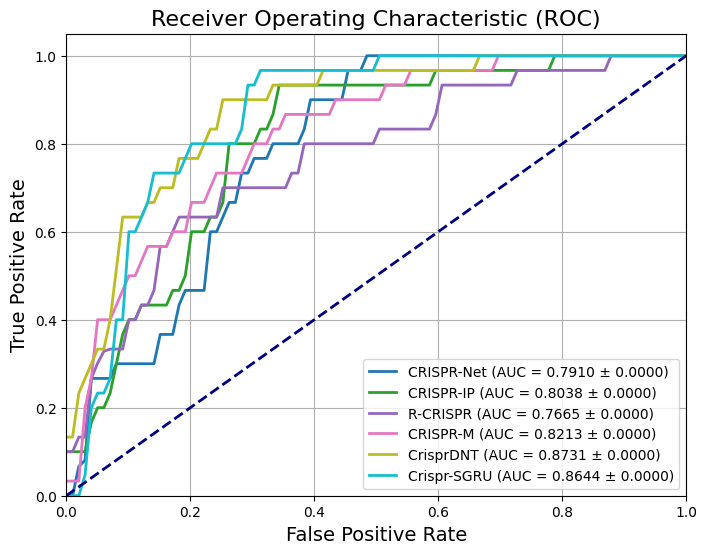

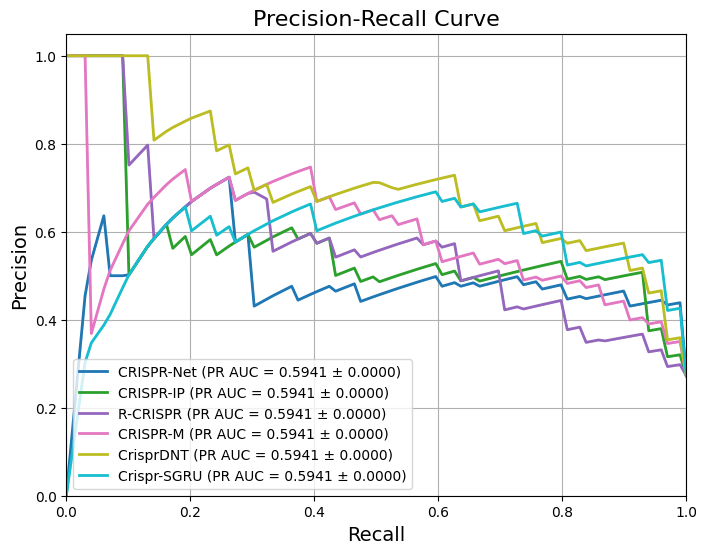

/tmp/ipykernel_703624/2778815346.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.3614 ± 0.0000  1.0000 ± 0.0000  0.5310 ± 0.0000   
1    CRISPR-IP  0.3152 ± 0.0000  0.9667 ± 0.0000  0.4754 ± 0.0000   
2     R-CRISPR  0.3258 ± 0.0000  0.9667 ± 0.0000  0.4874 ± 0.0000   
3     CRISPR-M  0.2727 ± 0.0000  1.0000 ± 0.0000  0.4286 ± 0.0000   
4    CrisprDNT  0.3973 ± 0.0000  0.9667 ± 0.0000  0.5631 ± 0.0000   
5  Crispr-SGRU  0.3659 ± 0.0000  1.0000 ± 0.0000  0.5357 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3493 ± 0.0000  0.7910 ± 0.0000  0.5153 ± 0.0000       0.5913  
1  0.2157 ± 0.0000  0.8038 ± 0.0000  0.5766 ± 0.0000       0.5589  
2  0.2455 ± 0.0000  0.7665 ± 0.0000  0.5834 ± 0.0000       0.5625  
3  0.0000 ± 0.0000  0.8213 ± 0.0000  0.6048 ± 0.0000       0.5212  
4  0.3928 ± 0.0000  0.8731 ± 0.0000  0.7122 ± 0.0000       0.6509  
5  0.3578 ± 0.0000  0.8644 ± 0.0000  0.5941 ± 0.0000       0.6197  


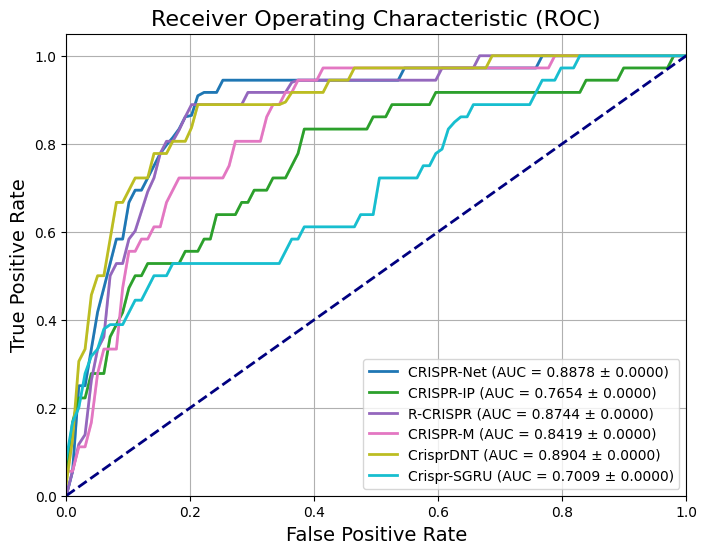

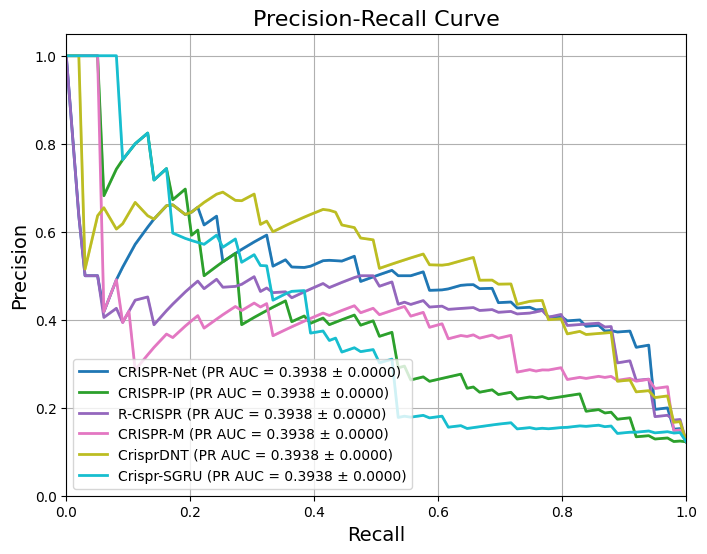

         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2787 ± 0.0000  0.9444 ± 0.0000  0.4304 ± 0.0000   
1    CRISPR-IP  0.1392 ± 0.0000  0.9167 ± 0.0000  0.2418 ± 0.0000   
2     R-CRISPR  0.3404 ± 0.0000  0.8889 ± 0.0000  0.4923 ± 0.0000   
3     CRISPR-M  0.4000 ± 0.0000  0.0556 ± 0.0000  0.0976 ± 0.0000   
4    CrisprDNT  0.2783 ± 0.0000  0.8889 ± 0.0000  0.4238 ± 0.0000   
5  Crispr-SGRU  0.1732 ± 0.0000  0.6111 ± 0.0000  0.2699 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.4014 ± 0.0000  0.8878 ± 0.0000  0.4884 ± 0.0000       0.5719  
1  0.1045 ± 0.0000  0.7654 ± 0.0000  0.4150 ± 0.0000       0.4304  
2  0.4559 ± 0.0000  0.8744 ± 0.0000  0.4289 ± 0.0000       0.5801  
3  0.1114 ± 0.0000  0.8419 ± 0.0000  0.4009 ± 0.0000       0.3179  
4  0.3810 ± 0.0000  0.8904 ± 0.0000  0.5401 ± 0.0000       0.5671  
5  0.1351 ± 0.0000  0.7009 ± 0.0000  0.3938 ± 0.0000       0.3807  


/tmp/ipykernel_703624/2778815346.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


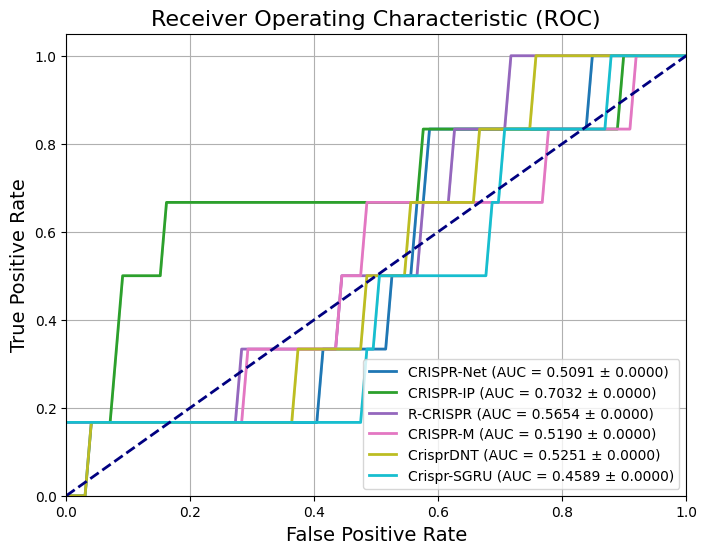

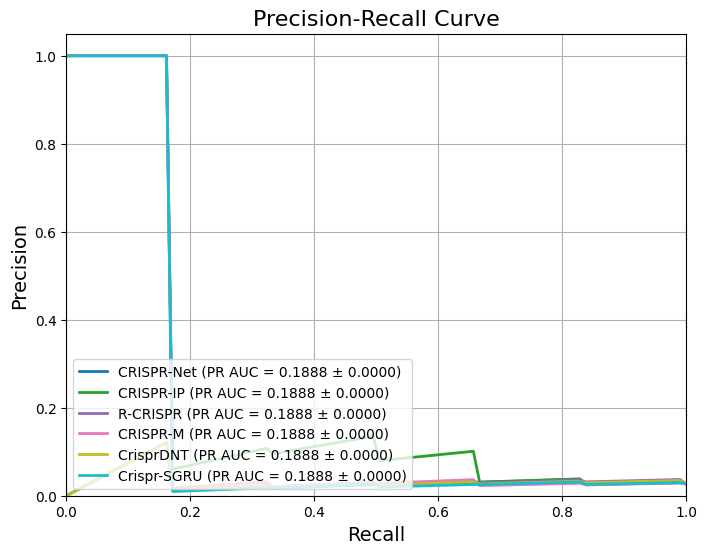

         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0164 ± 0.0000  0.1667 ± 0.0000  0.0299 ± 0.0000   
1    CRISPR-IP  0.0328 ± 0.0000  0.6667 ± 0.0000  0.0625 ± 0.0000   
2     R-CRISPR  0.0294 ± 0.0000  0.1667 ± 0.0000  0.0500 ± 0.0000   
3     CRISPR-M  0.1111 ± 0.0000  0.1667 ± 0.0000  0.1333 ± 0.0000   
4    CrisprDNT  0.0314 ± 0.0000  0.8333 ± 0.0000  0.0606 ± 0.0000   
5  Crispr-SGRU  0.0122 ± 0.0000  0.1667 ± 0.0000  0.0227 ± 0.0000   

                MCC            AUROC            PRAUC Overall_Mean  
0  -0.0389 ± 0.0000  0.5091 ± 0.0000  0.0456 ± 0.0000       0.1215  
1   0.0413 ± 0.0000  0.7032 ± 0.0000  0.2364 ± 0.0000       0.2905  
2   0.0072 ± 0.0000  0.5654 ± 0.0000  0.1944 ± 0.0000       0.1689  
3   0.1070 ± 0.0000  0.5190 ± 0.0000  0.1927 ± 0.0000       0.2050  
4   0.0460 ± 0.0000  0.5251 ± 0.0000  0.0462 ± 0.0000       0.2571  
5  -0.0680 ± 0.0000  0.4589 ± 0.0000  0.1888 ± 0.0000       0.1302  


In [32]:
def ROC_with_metrics(y_test_list, predictions_dict, output_csv="metrics_table.csv"):
    """
    Plots averaged ROC and Precision-Recall curves for multiple sets of predictions 
    across cross-validation folds and saves a metrics table.

    Parameters:
        y_test_list (list of array-like): List of true binary labels for each fold.
        predictions_dict (dict): Dictionary where keys are labels and values are lists 
                                  of predicted scores for each fold.
        output_csv (str): Path to save the metrics table as a CSV file.
    """
    # Initialize plots
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap("tab10", len(predictions_dict))

    metrics_table = []

    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        roc_aucs = []
        pr_aucs = []

        precision_scores = []
        recall_scores = []
        f1_scores = []
        mcc_scores = []

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]

            # ROC-AUC computation
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            tprs.append(np.interp(mean_fpr, fpr, tpr))

            # Precision-Recall AUC computation
            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            pr_auc = average_precision_score(y_test, y_scores)
            pr_aucs.append(pr_auc)

            # Classification metrics
            binary_predictions = (y_scores >= 0.5).astype(int)
            precision_scores.append(precision_score(y_test, binary_predictions))
            recall_scores.append(recall_score(y_test, binary_predictions))
            f1_scores.append(f1_score(y_test, binary_predictions))
            mcc_scores.append(matthews_corrcoef(y_test, binary_predictions))

        # Compute mean and std for TPRs
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        mean_tpr[-1] = 1.0

        # Plot mean ROC curve
        color = colors(idx)
        plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
                 label=f"{label} (AUC = {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f})")
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=color, alpha=0.2)

        # Aggregate metrics for table
        metrics_table.append([
            label,
            f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
            f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
            f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
            f"{np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}",
            f"{np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}",
            f"{np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}",
            f"{np.mean([np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(mcc_scores), np.mean(roc_aucs), np.mean(pr_aucs)]):.4f}"
        ])

    # Finalize and show ROC plot
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Receiver Operating Characteristic (ROC)", fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        precisions = []
        recalls = []

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]
            precision, recall, _ = precision_recall_curve(y_test, y_scores)

            interpolated_recall = np.linspace(0, 1, 100)
            interpolated_precision = np.interp(interpolated_recall, recall[::-1], precision[::-1])
            precisions.append(interpolated_precision)

        # Compute mean and std for precision-recall
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)

        # Plot mean Precision-Recall curve
        color = colors(idx)
        plt.plot(interpolated_recall, mean_precision, color=color, lw=2,
                 label=f"{label} (PR AUC = {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f})")
        plt.fill_between(interpolated_recall, mean_precision - std_precision, mean_precision + std_precision,
                         color=color, alpha=0.2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # Create metrics DataFrame and save to CSV
    metrics_df = pd.DataFrame(metrics_table, columns=[
        "Model", "Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC", "Overall_Mean"
    ])
    print(metrics_df)
    #metrics_df.to_csv(output_csv, index=False)
    #print(f"Metrics table saved to {output_csv}")


# With validated datasets

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

## set 1
pred_scores_crispr_net_0 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_Val1.npy')
pred_scores_crispr_ip_0 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_Val1.npy')
pred_scores_r_crispr_0 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_Val1.npy')
pred_scores_crispr_m_0 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_Val1.npy')
pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_Val1.npy')
pred_scores_crispr_sgru_0 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_Val1.npy')

## set 2

pred_scores_crispr_net_0_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_Val1.npy')
pred_scores_crispr_ip_0_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_Val1.npy')
pred_scores_r_crispr_0_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_Val1.npy')
pred_scores_crispr_m_0_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_Val1.npy')
pred_scores_crisprDNT_0_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_Val1.npy')
pred_scores_crispr_sgru_0_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_Val1.npy')


## set 3

pred_scores_crispr_net_0_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_Val1.npy')
pred_scores_crispr_ip_0_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_Val1.npy')
pred_scores_r_crispr_0_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_Val1.npy')
pred_scores_crispr_m_0_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_Val1.npy')
pred_scores_crisprDNT_0_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_Val1.npy')
pred_scores_crispr_sgru_0_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_Val1.npy')

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list = {
    "CRISPR-Net": [pred_scores_crispr_net_0],
    "CRISPR-IP": [pred_scores_crispr_ip_0],
    "R-CRISPR" : [pred_scores_r_crispr_0],
    "CRISPR-M" : [pred_scores_crispr_m_0],
    "CrisprDNT": [pred_scores_crisprDNT_0],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0]
}


ROC_with_metrics(label_test, predictions_dict_list, output_csv)




label_test = []
testing_files = ['./Datasets/real_testing/Testing1.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list2 = {
    "CRISPR-Net": [pred_scores_crispr_net_0_1],
    "CRISPR-IP": [pred_scores_crispr_ip_0_1],
    "R-CRISPR" : [pred_scores_r_crispr_0_1],
    "CRISPR-M" : [pred_scores_crispr_m_0_1],
    "CrisprDNT": [pred_scores_crisprDNT_0_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0_1]
}


ROC_with_metrics(label_test, predictions_dict_list2, output_csv)

label_test = []
testing_files = ['./Datasets/real_testing/Testing2.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list3 = {
    "CRISPR-Net": [pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0_2]
}


ROC_with_metrics(label_test, predictions_dict_list3, output_csv)

/tmp/ipykernel_703624/297129160.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


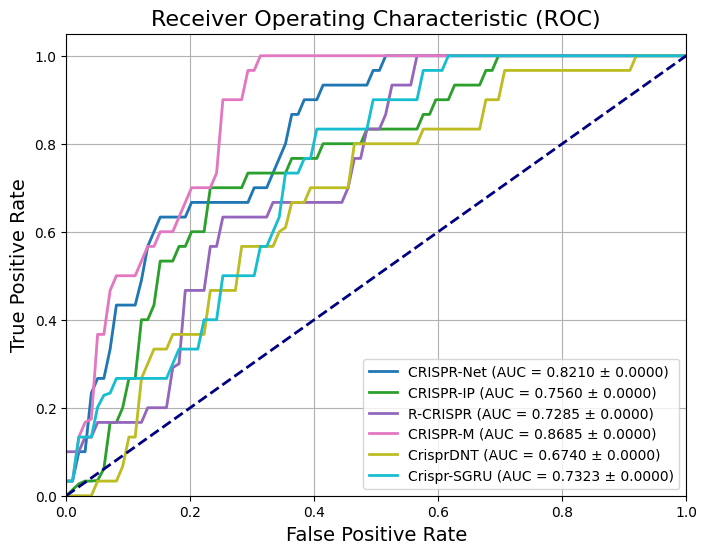

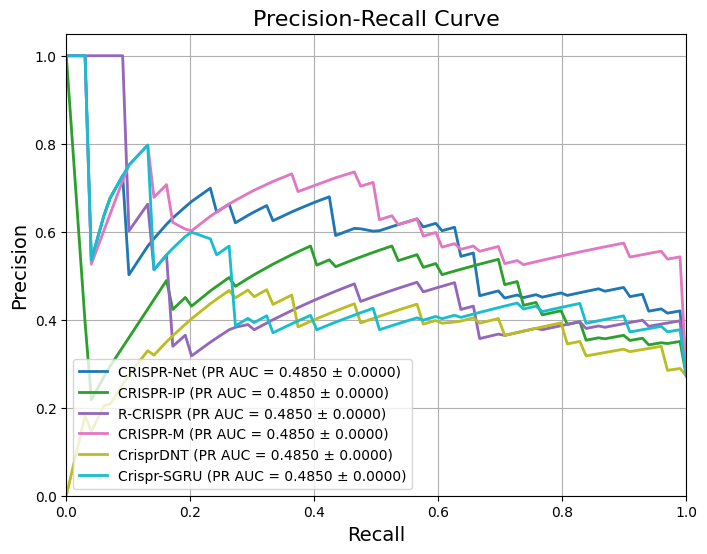

/tmp/ipykernel_703624/297129160.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.3947 ± 0.0000  1.0000 ± 0.0000  0.5660 ± 0.0000   
1    CRISPR-IP  0.3529 ± 0.0000  1.0000 ± 0.0000  0.5217 ± 0.0000   
2     R-CRISPR  0.3846 ± 0.0000  0.8333 ± 0.0000  0.5263 ± 0.0000   
3     CRISPR-M  0.4615 ± 0.0000  1.0000 ± 0.0000  0.6316 ± 0.0000   
4    CrisprDNT  0.3621 ± 0.0000  0.7000 ± 0.0000  0.4773 ± 0.0000   
5  Crispr-SGRU  0.3784 ± 0.0000  0.9333 ± 0.0000  0.5385 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.4096 ± 0.0000  0.8210 ± 0.0000  0.5920 ± 0.0000       0.6306  
1  0.3321 ± 0.0000  0.7560 ± 0.0000  0.4698 ± 0.0000       0.5721  
2  0.3019 ± 0.0000  0.7285 ± 0.0000  0.4873 ± 0.0000       0.5437  
3  0.5095 ± 0.0000  0.8685 ± 0.0000  0.6501 ± 0.0000       0.6869  
4  0.2119 ± 0.0000  0.6740 ± 0.0000  0.3785 ± 0.0000       0.4673  
5  0.3401 ± 0.0000  0.7323 ± 0.0000  0.4850 ± 0.0000       0.5679  


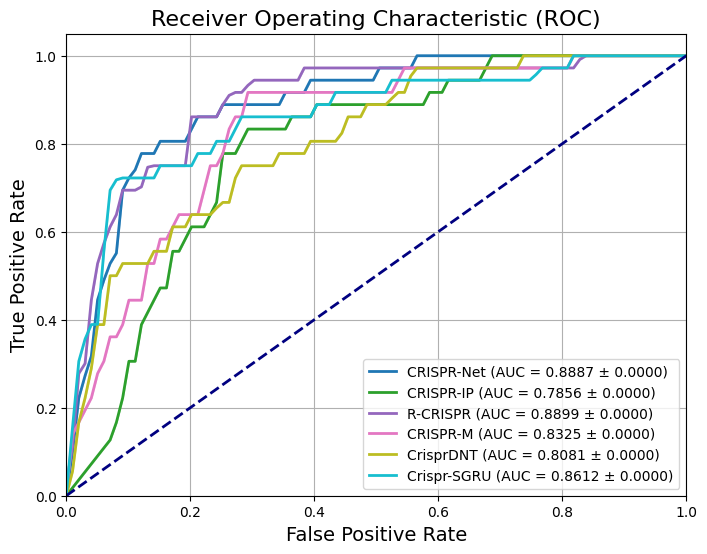

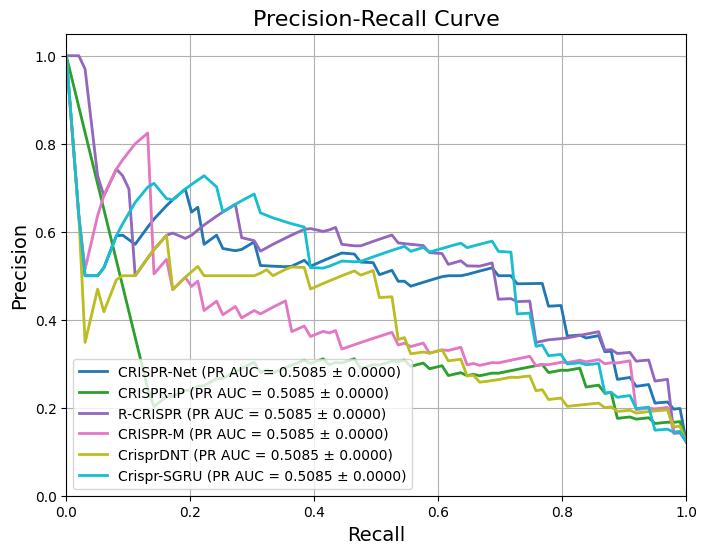

         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.4828 ± 0.0000  0.7778 ± 0.0000  0.5957 ± 0.0000   
1    CRISPR-IP  0.2727 ± 0.0000  0.8333 ± 0.0000  0.4110 ± 0.0000   
2     R-CRISPR  0.5227 ± 0.0000  0.6389 ± 0.0000  0.5750 ± 0.0000   
3     CRISPR-M  0.3012 ± 0.0000  0.6944 ± 0.0000  0.4202 ± 0.0000   
4    CrisprDNT  0.5200 ± 0.0000  0.3611 ± 0.0000  0.4262 ± 0.0000   
5  Crispr-SGRU  0.4333 ± 0.0000  0.7222 ± 0.0000  0.5417 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.5449 ± 0.0000  0.8887 ± 0.0000  0.4924 ± 0.0000       0.6304  
1  0.3545 ± 0.0000  0.7856 ± 0.0000  0.2620 ± 0.0000       0.4865  
2  0.5123 ± 0.0000  0.8899 ± 0.0000  0.5292 ± 0.0000       0.6113  
3  0.3420 ± 0.0000  0.8325 ± 0.0000  0.4028 ± 0.0000       0.4989  
4  0.3697 ± 0.0000  0.8081 ± 0.0000  0.3879 ± 0.0000       0.4788  
5  0.4802 ± 0.0000  0.8612 ± 0.0000  0.5085 ± 0.0000       0.5912  


/tmp/ipykernel_703624/297129160.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


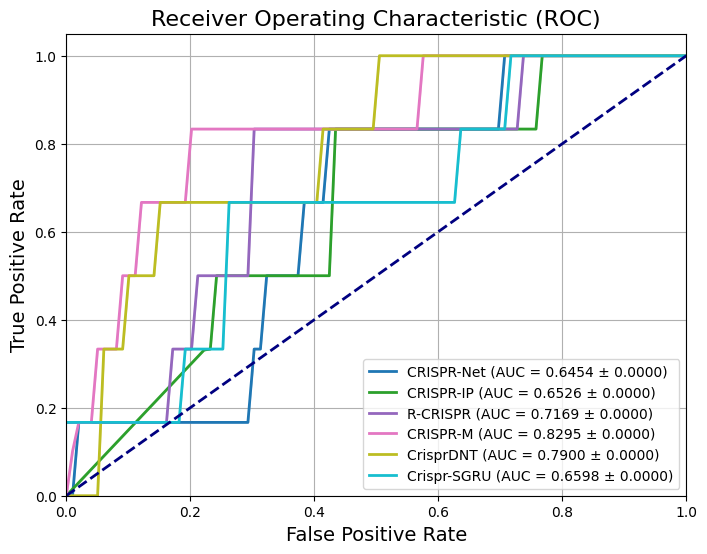

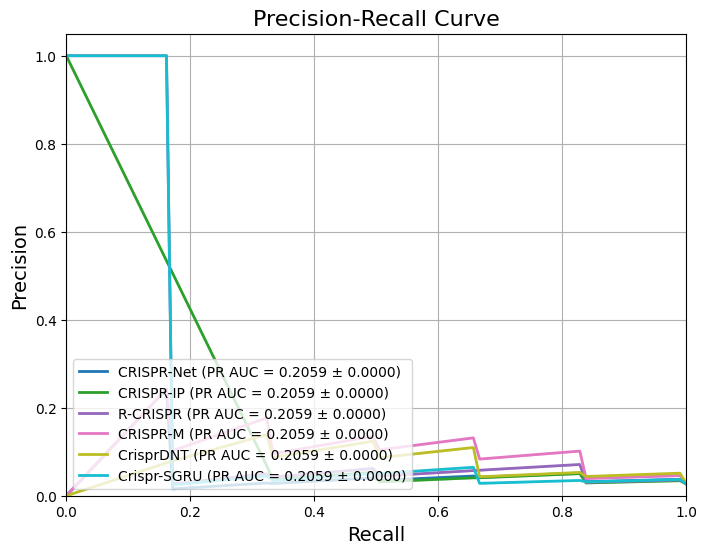

         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0238 ± 0.0000  0.1667 ± 0.0000  0.0417 ± 0.0000   
1    CRISPR-IP  0.0397 ± 0.0000  0.8333 ± 0.0000  0.0758 ± 0.0000   
2     R-CRISPR  0.0278 ± 0.0000  0.1667 ± 0.0000  0.0476 ± 0.0000   
3     CRISPR-M  0.0667 ± 0.0000  0.8333 ± 0.0000  0.1235 ± 0.0000   
4    CrisprDNT  0.1111 ± 0.0000  0.3333 ± 0.0000  0.1667 ± 0.0000   
5  Crispr-SGRU  0.0351 ± 0.0000  0.3333 ± 0.0000  0.0635 ± 0.0000   

                MCC            AUROC            PRAUC Overall_Mean  
0  -0.0085 ± 0.0000  0.6454 ± 0.0000  0.0760 ± 0.0000       0.1575  
1   0.0911 ± 0.0000  0.6526 ± 0.0000  0.0430 ± 0.0000       0.2893  
2   0.0030 ± 0.0000  0.7169 ± 0.0000  0.2132 ± 0.0000       0.1959  
3   0.1756 ± 0.0000  0.8295 ± 0.0000  0.1416 ± 0.0000       0.3617  
4   0.1546 ± 0.0000  0.7900 ± 0.0000  0.0935 ± 0.0000       0.2748  
5   0.0304 ± 0.0000  0.6598 ± 0.0000  0.2059 ± 0.0000       0.2213  


In [33]:
def ROC_with_metrics(y_test_list, predictions_dict, output_csv="metrics_table.csv"):
    """
    Plots averaged ROC and Precision-Recall curves for multiple sets of predictions 
    across cross-validation folds and saves a metrics table.

    Parameters:
        y_test_list (list of array-like): List of true binary labels for each fold.
        predictions_dict (dict): Dictionary where keys are labels and values are lists 
                                  of predicted scores for each fold.
        output_csv (str): Path to save the metrics table as a CSV file.
    """
    # Initialize plots
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap("tab10", len(predictions_dict))

    metrics_table = []

    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        roc_aucs = []
        pr_aucs = []

        precision_scores = []
        recall_scores = []
        f1_scores = []
        mcc_scores = []

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]

            # ROC-AUC computation
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            tprs.append(np.interp(mean_fpr, fpr, tpr))

            # Precision-Recall AUC computation
            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            pr_auc = average_precision_score(y_test, y_scores)
            pr_aucs.append(pr_auc)

            # Classification metrics
            binary_predictions = (y_scores >= 0.5).astype(int)
            precision_scores.append(precision_score(y_test, binary_predictions))
            recall_scores.append(recall_score(y_test, binary_predictions))
            f1_scores.append(f1_score(y_test, binary_predictions))
            mcc_scores.append(matthews_corrcoef(y_test, binary_predictions))

        # Compute mean and std for TPRs
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        mean_tpr[-1] = 1.0

        # Plot mean ROC curve
        color = colors(idx)
        plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
                 label=f"{label} (AUC = {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f})")
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=color, alpha=0.2)

        # Aggregate metrics for table
        metrics_table.append([
            label,
            f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
            f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
            f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
            f"{np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}",
            f"{np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}",
            f"{np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}",
            f"{np.mean([np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(mcc_scores), np.mean(roc_aucs), np.mean(pr_aucs)]):.4f}"
        ])

    # Finalize and show ROC plot
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("Receiver Operating Characteristic (ROC)", fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for idx, (label, y_scores_list) in enumerate(predictions_dict.items()):
        precisions = []
        recalls = []

        for i in range(len(y_test_list)):
            y_test = y_test_list[i]
            y_scores = y_scores_list[i]
            precision, recall, _ = precision_recall_curve(y_test, y_scores)

            interpolated_recall = np.linspace(0, 1, 100)
            interpolated_precision = np.interp(interpolated_recall, recall[::-1], precision[::-1])
            precisions.append(interpolated_precision)

        # Compute mean and std for precision-recall
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)

        # Plot mean Precision-Recall curve
        color = colors(idx)
        plt.plot(interpolated_recall, mean_precision, color=color, lw=2,
                 label=f"{label} (PR AUC = {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f})")
        plt.fill_between(interpolated_recall, mean_precision - std_precision, mean_precision + std_precision,
                         color=color, alpha=0.2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # Create metrics DataFrame and save to CSV
    metrics_df = pd.DataFrame(metrics_table, columns=[
        "Model", "Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC", "Overall_Mean"
    ])
    print(metrics_df)
    #metrics_df.to_csv(output_csv, index=False)
    #print(f"Metrics table saved to {output_csv}")


# With validated datasets

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

## set 1
pred_scores_crispr_net_0 = np.load('./Predictions/set1/crispr_net_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_ip_0 = np.load('./Predictions/set1/crispr_ip_scores_5sgRNA_set1_noVal0.npy')
pred_scores_r_crispr_0 = np.load('./Predictions/set1/r_crispr_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_m_0 = np.load('./Predictions/set1/crispr_m_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crisprDNT_0 = np.load('./Predictions/set1/crisprDNT_scores_5sgRNA_set1_noVal0.npy')
pred_scores_crispr_sgru_0 = np.load('./Predictions/set1/crispr_sgru_scores_5sgRNA_set1_noVal0.npy')

## set 2

pred_scores_crispr_net_0_1 = np.load('./Predictions/set2/crispr_net_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_ip_0_1 = np.load('./Predictions/set2/crispr_ip_scores_5sgRNA_set2_noVal0.npy')
pred_scores_r_crispr_0_1 = np.load('./Predictions/set2/r_crispr_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_m_0_1 = np.load('./Predictions/set2/crispr_m_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crisprDNT_0_1 = np.load('./Predictions/set2/crisprDNT_scores_5sgRNA_set2_noVal0.npy')
pred_scores_crispr_sgru_0_1 = np.load('./Predictions/set2/crispr_sgru_scores_5sgRNA_set2_noVal0.npy')


## set 3

pred_scores_crispr_net_0_2 = np.load('./Predictions/set3/crispr_net_5sgRNA_set3_noVal0.npy')
pred_scores_crispr_ip_0_2 = np.load('./Predictions/set3/crispr_ip_scores_5sgRNA_set3_noVal0.npy')
pred_scores_r_crispr_0_2 = np.load('./Predictions/set3/r_crispr_scores_5sgRNA_set3_noVal0.npy')
pred_scores_crispr_m_0_2 = np.load('./Predictions/set3/crispr_m_scores_5sgRNA_set3_noVal0.npy')
pred_scores_crisprDNT_0_2 = np.load('./Predictions/set3/crisprDNT_scores_5sgRNA_set3_noVal0.npy')
pred_scores_crispr_sgru_0_2 = np.load('./Predictions/set3/crispr_sgru_scores_5sgRNA_set3_noVal0.npy')

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list = {
    "CRISPR-Net": [pred_scores_crispr_net_0],
    "CRISPR-IP": [pred_scores_crispr_ip_0],
    "R-CRISPR" : [pred_scores_r_crispr_0],
    "CRISPR-M" : [pred_scores_crispr_m_0],
    "CrisprDNT": [pred_scores_crisprDNT_0],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0]
}


ROC_with_metrics(label_test, predictions_dict_list, output_csv)




label_test = []
testing_files = ['./Datasets/real_testing/Testing1.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list2 = {
    "CRISPR-Net": [pred_scores_crispr_net_0_1],
    "CRISPR-IP": [pred_scores_crispr_ip_0_1],
    "R-CRISPR" : [pred_scores_r_crispr_0_1],
    "CRISPR-M" : [pred_scores_crispr_m_0_1],
    "CrisprDNT": [pred_scores_crisprDNT_0_1],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0_1]
}


ROC_with_metrics(label_test, predictions_dict_list2, output_csv)

label_test = []
testing_files = ['./Datasets/real_testing/Testing2.csv']
pre_fix = "5sgRNA"

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)

predictions_dict_list3 = {
    "CRISPR-Net": [pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0_2]
}


ROC_with_metrics(label_test, predictions_dict_list3, output_csv)

In [35]:
predictions_dict_list2

{'CRISPR-Net': [array([7.51415014e-01, 9.98915911e-01, 8.18001330e-01, 9.99709070e-01,
         8.69223416e-01, 9.98930395e-01, 9.68499720e-01, 9.94648397e-01,
         9.96965468e-01, 9.97852325e-01, 8.54025066e-01, 8.58790696e-01,
         9.98644054e-01, 9.99121487e-01, 3.13892998e-02, 5.98779530e-04,
         9.94719803e-01, 5.76662719e-01, 9.89954174e-01, 9.98586357e-01,
         9.87441957e-01, 8.46278846e-01, 5.62385857e-01, 3.38786453e-01,
         9.90719795e-01, 9.07954946e-02, 9.62151349e-01, 1.21700333e-03,
         7.71498606e-02, 9.99118984e-01, 9.69137490e-01, 8.60977948e-01,
         9.81841147e-01, 3.84804350e-03, 9.21846569e-01, 7.52753345e-03,
         1.49997622e-01, 8.55963954e-05, 1.54723166e-05, 8.42368354e-06,
         9.99653595e-04, 1.89420104e-03, 2.51488481e-02, 1.04466187e-06,
         9.25858258e-05, 2.65139795e-04, 3.66011081e-04, 3.82470898e-03,
         9.07580616e-05, 1.07105097e-06, 1.10664978e-05, 1.53281435e-01,
         4.43915487e-05, 1.00979105e-

In [4]:
# original datasets
# update 04-06-25

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing3.csv',
                ]
pre_fix = "5sgRNA_Val_set_1_2_4_ori"
datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
ex_fix = ['_ori0.npy','_ori1.npy','_ori2.npy']

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
PATH_cripsr_net = './New_evaluation_final/Testing/crispr_net_'
PATH_cripsr_ip  = './New_evaluation_final/Testing/crispr_ip_'
PATH_r_cripsr  = './New_evaluation_final/Testing/r_crispr_'
PATH_cripsr_m  = './New_evaluation_final/Testing/crispr_m_'
PATH_cripsrdnt  = './New_evaluation_final/Testing/crisprdnt_'
PATH_cripsr_sgru  = './New_evaluation_final/Testing/crispr_sgru_'

## set 1
pred_scores_crispr_net_0 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[0])
pred_scores_crispr_net_1 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[0])
pred_scores_crispr_net_2 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[0])
pred_scores_crispr_net_3 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[0])
pred_scores_crispr_net_4 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[0])
pred_scores_crispr_net_5 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[0])

pred_scores_crispr_ip_0 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[0])
pred_scores_crispr_ip_1 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[0])
pred_scores_crispr_ip_2 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[0])
pred_scores_crispr_ip_3 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[0])
pred_scores_crispr_ip_4 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[0])
pred_scores_crispr_ip_5 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[0])

pred_scores_r_crispr_0 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[0])
pred_scores_r_crispr_1 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[0])
pred_scores_r_crispr_2 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[0])
pred_scores_r_crispr_3 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[0])
pred_scores_r_crispr_4 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[0])
pred_scores_r_crispr_5 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[0])

pred_scores_crispr_m_0 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[0])
pred_scores_crispr_m_1 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[0])
pred_scores_crispr_m_2 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[0])
pred_scores_crispr_m_3 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[0])
pred_scores_crispr_m_4 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[0])
pred_scores_crispr_m_5 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[0])

pred_scores_crisprDNT_0 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[0])
pred_scores_crisprDNT_1 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[0])
pred_scores_crisprDNT_2 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[0])
pred_scores_crisprDNT_3 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[0])
pred_scores_crisprDNT_4 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[0])
pred_scores_crisprDNT_5 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[0])

pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[0])
pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[0])
pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[0])
pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[0])
pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[0])
pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[0])

## set 2

pred_scores_crispr_net_0_1 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[1])
pred_scores_crispr_net_1_1 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[1])
pred_scores_crispr_net_2_1 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[1])
pred_scores_crispr_net_3_1 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[1])
pred_scores_crispr_net_4_1 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[1])
pred_scores_crispr_net_5_1 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[1])

pred_scores_crispr_ip_0_1 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[1])
pred_scores_crispr_ip_1_1 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[1])
pred_scores_crispr_ip_2_1 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[1])
pred_scores_crispr_ip_3_1 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[1])
pred_scores_crispr_ip_4_1 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[1])
pred_scores_crispr_ip_5_1 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[1])

pred_scores_r_crispr_0_1 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[1])
pred_scores_r_crispr_1_1 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[1])
pred_scores_r_crispr_2_1 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[1])
pred_scores_r_crispr_3_1 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[1])
pred_scores_r_crispr_4_1 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[1])
pred_scores_r_crispr_5_1 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[1])

pred_scores_crispr_m_0_1 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[1])
pred_scores_crispr_m_1_1 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[1])
pred_scores_crispr_m_2_1 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[1])
pred_scores_crispr_m_3_1 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[1])
pred_scores_crispr_m_4_1 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[1])
pred_scores_crispr_m_5_1 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[1])

pred_scores_crisprDNT_0_1 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[1])
pred_scores_crisprDNT_1_1 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[1])
pred_scores_crisprDNT_2_1 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[1])
pred_scores_crisprDNT_3_1 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[1])
pred_scores_crisprDNT_4_1 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[1])
pred_scores_crisprDNT_5_1 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[1])

pred_scores_crispr_sgru_0_1 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[1])
pred_scores_crispr_sgru_1_1 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[1])
pred_scores_crispr_sgru_2_1 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[1])
pred_scores_crispr_sgru_3_1 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[1])
pred_scores_crispr_sgru_4_1 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[1])
pred_scores_crispr_sgru_5_1 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[1])



## set 4

pred_scores_crispr_net_0_2 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[2])
pred_scores_crispr_net_1_2 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[2])
pred_scores_crispr_net_2_2 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[2])
pred_scores_crispr_net_3_2 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[2])
pred_scores_crispr_net_4_2 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[2])
pred_scores_crispr_net_5_2 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[2])

pred_scores_crispr_ip_0_2 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[2])
pred_scores_crispr_ip_1_2 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[2])
pred_scores_crispr_ip_2_2 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[2])
pred_scores_crispr_ip_3_2 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[2])
pred_scores_crispr_ip_4_2 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[2])
pred_scores_crispr_ip_5_2 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[2])

pred_scores_r_crispr_0_2 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[2])
pred_scores_r_crispr_1_2 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[2])
pred_scores_r_crispr_2_2 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[2])
pred_scores_r_crispr_3_2 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[2])
pred_scores_r_crispr_4_2 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[2])
pred_scores_r_crispr_5_2 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[2])

pred_scores_crispr_m_0_2 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[2])
pred_scores_crispr_m_1_2 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[2])
pred_scores_crispr_m_2_2 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[2])
pred_scores_crispr_m_3_2 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[2])
pred_scores_crispr_m_4_2 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[2])
pred_scores_crispr_m_5_2 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[2])

pred_scores_crisprDNT_0_2 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[2])
pred_scores_crisprDNT_1_2 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[2])
pred_scores_crisprDNT_2_2 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[2])
pred_scores_crisprDNT_3_2 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[2])
pred_scores_crisprDNT_4_2 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[2])
pred_scores_crisprDNT_5_2 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[2])

pred_scores_crispr_sgru_0_2 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[2])
pred_scores_crispr_sgru_1_2 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[2])
pred_scores_crispr_sgru_2_2 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[2])
pred_scores_crispr_sgru_3_2 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[2])
pred_scores_crispr_sgru_4_2 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[2])
pred_scores_crispr_sgru_5_2 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[2])


predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1, pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1, pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1, pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1, pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1,pred_scores_crispr_sgru_0_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1, pred_scores_crispr_net_1_2],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1, pred_scores_crispr_ip_1_2],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1, pred_scores_r_crispr_1_2],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1, pred_scores_crispr_m_1_2],
    "CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1,pred_scores_crispr_sgru_1_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1, pred_scores_crispr_net_2_2],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1, pred_scores_crispr_ip_2_2],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1, pred_scores_r_crispr_2_2],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1, pred_scores_crispr_m_2_2],
    "CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1,pred_scores_crispr_sgru_2_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1, pred_scores_crispr_net_3_2],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1, pred_scores_crispr_ip_3_2],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1, pred_scores_r_crispr_3_2],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1, pred_scores_crispr_m_3_2],
    "CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1,pred_scores_crispr_sgru_3_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1, pred_scores_crispr_net_4_2],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1, pred_scores_crispr_ip_4_2],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1, pred_scores_r_crispr_4_2],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1, pred_scores_crispr_m_4_2],
    "CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1,pred_scores_crispr_sgru_4_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1, pred_scores_crispr_net_5_2],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1, pred_scores_crispr_ip_5_2],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1, pred_scores_r_crispr_5_2],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1, pred_scores_crispr_m_5_2],
    "CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1,pred_scores_crispr_sgru_5_2]
})




all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/p

ROC curve saved to 5sgRNA_Val_set_1_2_4_oriHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_oriHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.6667 ± 0.4714  0.0870 ± 0.1041  0.1441 ± 0.1671   
1    CRISPR-IP  0.3333 ± 0.4714  0.0111 ± 0.0157  0.0215 ± 0.0304   
2     R-CRISPR  0.5897 ± 0.0998  0.4778 ± 0.3221  0.4789 ± 0.1902   
3     CRISPR-M  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
4    CrisprDNT  0.4527 ± 0.0741  0.5500 ± 0.1871  0.4916 ± 0.1150   
5  Crispr-SGRU  0.6473 ± 0.0250  0.5093 ± 0.1827  0.5560 ± 0.1154   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.1940 ± 0.1758  0.8512 ± 0.0864  0.6360 ± 0.1223       0.4298  
1  0.0521 ± 0.0737  0.8024 ± 0.0750  0.5523 ± 0.1334       0.2955  
2  0.4400 ± 0.1541  0.8254 ± 0.0824  0.5254 ± 0.1824       0.5562  
3  0.0000 ± 0.0000  0.8007 ± 0.0567  0.5564 ± 0.1126       0.2262  
4  0.3949 ± 0.0777  

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/p

Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_oriK562/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1    CRISPR-IP  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
2     R-CRISPR  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
3     CRISPR-M  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
4    CrisprDNT  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
5  Crispr-SGRU  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.5982 ± 0.1430  0.2652 ± 0.1394       0.1439  
1  0.0000 ± 0.0000  0.4701 ± 0.0805  0.1833 ± 0.1377       0.1089  
2  0.0000 ± 0.0000  0.7893 ± 0.1046  0.4320 ± 0.2267       0.2035  
3  0.0000 ± 0.0000  0.4577 ± 0.0524  0.1886 ± 0.0481       0.1077  
4  0.0000 ± 0.0000  0.3580 ± 0.1620  0.1687 ± 0.1309       0.0878  
5  0.0000 ± 0.0000  

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/p

ROC curve saved to 5sgRNA_Val_set_1_2_4_oriII4/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_oriII4/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1    CRISPR-IP  0.3333 ± 0.4714  0.0333 ± 0.0471  0.0606 ± 0.0857   
2     R-CRISPR  0.5093 ± 0.3603  0.2556 ± 0.1931  0.3373 ± 0.2467   
3     CRISPR-M  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
4    CrisprDNT  0.7950 ± 0.0567  0.3833 ± 0.1920  0.4879 ± 0.1709   
5  Crispr-SGRU  0.7621 ± 0.1356  0.3870 ± 0.2418  0.4832 ± 0.2361   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.3632 ± 0.2007  0.1581 ± 0.0573       0.0869  
1  0.0911 ± 0.1289  0.7959 ± 0.0680  0.5513 ± 0.1796       0.3109  
2  0.3163 ± 0.2247  0.8176 ± 0.0702  0.5829 ± 0.1521       0.4698  
3  0.0000 ± 0.0000  0.7243 ± 0.0984  0.2786 ± 0.1345       0.1672  
4  0.4816 ± 0.1169  0.8218 ±

/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/li

Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_oriII5/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1    CRISPR-IP  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
2     R-CRISPR  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
3     CRISPR-M  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
4    CrisprDNT  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
5  Crispr-SGRU  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.5302 ± 0.1678  0.2360 ± 0.1222       0.1277  
1  0.0000 ± 0.0000  0.2796 ± 0.0525  0.1088 ± 0.0506       0.0647  
2  0.0000 ± 0.0000  0.3997 ± 0.1691  0.1497 ± 0.0877       0.0916  
3  0.0000 ± 0.0000  0.4950 ± 0.0440  0.1927 ± 0.0625       0.1146  
4  0.0000 ± 0.0000  0.4291 ± 0.1028  0.1599 ± 0.0439       0.0982  
5  0.0000 ± 0.0000  0

/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/li

In [6]:
# original datasets with filtereing
# update 04-07-25

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing3.csv',
                ]
pre_fix = "5sgRNA_Val_set_1_2_4_filtered"
datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
ex_fix = ['_filtered0.npy','_filtered1.npy','_filtered2.npy']

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
PATH_cripsr_net = './New_evaluation_final/Testing/crispr_net_'
PATH_cripsr_ip  = './New_evaluation_final/Testing/crispr_ip_'
PATH_r_cripsr  = './New_evaluation_final/Testing/r_crispr_'
PATH_cripsr_m  = './New_evaluation_final/Testing/crispr_m_'
PATH_cripsrdnt  = './New_evaluation_final/Testing/crisprdnt_'
PATH_cripsr_sgru  = './New_evaluation_final/Testing/crispr_sgru_'

## set 1
pred_scores_crispr_net_0 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[0])
pred_scores_crispr_net_1 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[0])
pred_scores_crispr_net_2 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[0])
pred_scores_crispr_net_3 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[0])
pred_scores_crispr_net_4 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[0])
pred_scores_crispr_net_5 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[0])

pred_scores_crispr_ip_0 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[0])
pred_scores_crispr_ip_1 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[0])
pred_scores_crispr_ip_2 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[0])
pred_scores_crispr_ip_3 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[0])
pred_scores_crispr_ip_4 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[0])
pred_scores_crispr_ip_5 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[0])

pred_scores_r_crispr_0 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[0])
pred_scores_r_crispr_1 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[0])
pred_scores_r_crispr_2 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[0])
pred_scores_r_crispr_3 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[0])
pred_scores_r_crispr_4 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[0])
pred_scores_r_crispr_5 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[0])

pred_scores_crispr_m_0 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[0])
pred_scores_crispr_m_1 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[0])
pred_scores_crispr_m_2 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[0])
pred_scores_crispr_m_3 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[0])
pred_scores_crispr_m_4 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[0])
pred_scores_crispr_m_5 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[0])

pred_scores_crisprDNT_0 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[0])
pred_scores_crisprDNT_1 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[0])
pred_scores_crisprDNT_2 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[0])
pred_scores_crisprDNT_3 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[0])
pred_scores_crisprDNT_4 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[0])
pred_scores_crisprDNT_5 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[0])

pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[0])
pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[0])
pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[0])
pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[0])
pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[0])
pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[0])

## set 2

pred_scores_crispr_net_0_1 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[1])
pred_scores_crispr_net_1_1 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[1])
pred_scores_crispr_net_2_1 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[1])
pred_scores_crispr_net_3_1 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[1])
pred_scores_crispr_net_4_1 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[1])
pred_scores_crispr_net_5_1 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[1])

pred_scores_crispr_ip_0_1 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[1])
pred_scores_crispr_ip_1_1 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[1])
pred_scores_crispr_ip_2_1 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[1])
pred_scores_crispr_ip_3_1 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[1])
pred_scores_crispr_ip_4_1 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[1])
pred_scores_crispr_ip_5_1 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[1])

pred_scores_r_crispr_0_1 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[1])
pred_scores_r_crispr_1_1 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[1])
pred_scores_r_crispr_2_1 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[1])
pred_scores_r_crispr_3_1 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[1])
pred_scores_r_crispr_4_1 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[1])
pred_scores_r_crispr_5_1 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[1])

pred_scores_crispr_m_0_1 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[1])
pred_scores_crispr_m_1_1 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[1])
pred_scores_crispr_m_2_1 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[1])
pred_scores_crispr_m_3_1 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[1])
pred_scores_crispr_m_4_1 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[1])
pred_scores_crispr_m_5_1 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[1])

pred_scores_crisprDNT_0_1 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[1])
pred_scores_crisprDNT_1_1 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[1])
pred_scores_crisprDNT_2_1 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[1])
pred_scores_crisprDNT_3_1 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[1])
pred_scores_crisprDNT_4_1 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[1])
pred_scores_crisprDNT_5_1 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[1])

pred_scores_crispr_sgru_0_1 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[1])
pred_scores_crispr_sgru_1_1 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[1])
pred_scores_crispr_sgru_2_1 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[1])
pred_scores_crispr_sgru_3_1 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[1])
pred_scores_crispr_sgru_4_1 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[1])
pred_scores_crispr_sgru_5_1 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[1])



## set 4

pred_scores_crispr_net_0_2 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[2])
pred_scores_crispr_net_1_2 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[2])
pred_scores_crispr_net_2_2 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[2])
pred_scores_crispr_net_3_2 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[2])
pred_scores_crispr_net_4_2 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[2])
pred_scores_crispr_net_5_2 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[2])

pred_scores_crispr_ip_0_2 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[2])
pred_scores_crispr_ip_1_2 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[2])
pred_scores_crispr_ip_2_2 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[2])
pred_scores_crispr_ip_3_2 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[2])
pred_scores_crispr_ip_4_2 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[2])
pred_scores_crispr_ip_5_2 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[2])

pred_scores_r_crispr_0_2 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[2])
pred_scores_r_crispr_1_2 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[2])
pred_scores_r_crispr_2_2 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[2])
pred_scores_r_crispr_3_2 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[2])
pred_scores_r_crispr_4_2 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[2])
pred_scores_r_crispr_5_2 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[2])

pred_scores_crispr_m_0_2 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[2])
pred_scores_crispr_m_1_2 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[2])
pred_scores_crispr_m_2_2 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[2])
pred_scores_crispr_m_3_2 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[2])
pred_scores_crispr_m_4_2 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[2])
pred_scores_crispr_m_5_2 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[2])

pred_scores_crisprDNT_0_2 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[2])
pred_scores_crisprDNT_1_2 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[2])
pred_scores_crisprDNT_2_2 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[2])
pred_scores_crisprDNT_3_2 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[2])
pred_scores_crisprDNT_4_2 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[2])
pred_scores_crisprDNT_5_2 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[2])

pred_scores_crispr_sgru_0_2 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[2])
pred_scores_crispr_sgru_1_2 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[2])
pred_scores_crispr_sgru_2_2 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[2])
pred_scores_crispr_sgru_3_2 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[2])
pred_scores_crispr_sgru_4_2 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[2])
pred_scores_crispr_sgru_5_2 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[2])


predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1, pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1, pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1, pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1, pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1,pred_scores_crispr_sgru_0_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1, pred_scores_crispr_net_1_2],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1, pred_scores_crispr_ip_1_2],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1, pred_scores_r_crispr_1_2],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1, pred_scores_crispr_m_1_2],
    "CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1,pred_scores_crispr_sgru_1_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1, pred_scores_crispr_net_2_2],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1, pred_scores_crispr_ip_2_2],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1, pred_scores_r_crispr_2_2],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1, pred_scores_crispr_m_2_2],
    "CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1,pred_scores_crispr_sgru_2_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1, pred_scores_crispr_net_3_2],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1, pred_scores_crispr_ip_3_2],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1, pred_scores_r_crispr_3_2],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1, pred_scores_crispr_m_3_2],
    "CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1,pred_scores_crispr_sgru_3_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1, pred_scores_crispr_net_4_2],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1, pred_scores_crispr_ip_4_2],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1, pred_scores_r_crispr_4_2],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1, pred_scores_crispr_m_4_2],
    "CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1,pred_scores_crispr_sgru_4_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1, pred_scores_crispr_net_5_2],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1, pred_scores_crispr_ip_5_2],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1, pred_scores_r_crispr_5_2],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1, pred_scores_crispr_m_5_2],
    "CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1,pred_scores_crispr_sgru_5_2]
})




all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_Val_set_1_2_4_filteredHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_filteredHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2008 ± 0.1107  0.8889 ± 0.0416  0.3148 ± 0.1442   
1    CRISPR-IP  0.1964 ± 0.0947  0.9426 ± 0.0592  0.3148 ± 0.1271   
2     R-CRISPR  0.2137 ± 0.1075  0.9556 ± 0.0342  0.3377 ± 0.1435   
3     CRISPR-M  0.2052 ± 0.1173  0.9481 ± 0.0409  0.3239 ± 0.1588   
4    CrisprDNT  0.2315 ± 0.1103  0.8889 ± 0.1039  0.3585 ± 0.1536   
5  Crispr-SGRU  0.1920 ± 0.1138  0.9000 ± 0.0360  0.3028 ± 0.1500   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.1667 ± 0.0905  0.6684 ± 0.0694  0.3134 ± 0.1521       0.4255  
1  0.1811 ± 0.0470  0.5896 ± 0.0741  0.1891 ± 0.0926       0.4023  
2  0.2264 ± 0.0983  0.6959 ± 0.0931  0.2903 ± 0.1384       0.4532  
3  0.1433 ± 0.2093  0.6815 ± 0.1518  0.2953 ± 0.1539       0.4329  
4  0.2270 

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_Val_set_1_2_4_filteredK562/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_filteredK562/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2484 ± 0.1010  0.9481 ± 0.0409  0.3845 ± 0.1354   
1    CRISPR-IP  0.1951 ± 0.1014  0.9185 ± 0.0824  0.3123 ± 0.1373   
2     R-CRISPR  0.2714 ± 0.1202  0.9148 ± 0.0843  0.4088 ± 0.1555   
3     CRISPR-M  0.1610 ± 0.0821  1.0000 ± 0.0000  0.2691 ± 0.1176   
4    CrisprDNT  0.2152 ± 0.1005  0.9741 ± 0.0205  0.3420 ± 0.1371   
5  Crispr-SGRU  0.2212 ± 0.1091  0.9574 ± 0.0421  0.3483 ± 0.1446   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2943 ± 0.1067  0.8203 ± 0.0733  0.4723 ± 0.1563       0.5280  
1  0.1738 ± 0.0892  0.6785 ± 0.0969  0.3206 ± 0.2538       0.4331  
2  0.3274 ± 0.1360  0.8243 ± 0.0840  0.4354 ± 0.1812       0.5304  
3  0.0196 ± 0.0277  0.7287 ± 0.1842  0.3439 ± 0.1911       0.4204  
4  0.2312 ± 0.10

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_Val_set_1_2_4_filteredII5/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_filteredII5/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.1635 ± 0.0759  0.9407 ± 0.0302  0.2702 ± 0.1037   
1    CRISPR-IP  0.1780 ± 0.0801  0.9907 ± 0.0131  0.2943 ± 0.1120   
2     R-CRISPR  0.1734 ± 0.0826  1.0000 ± 0.0000  0.2875 ± 0.1158   
3     CRISPR-M  0.1609 ± 0.0805  1.0000 ± 0.0000  0.2691 ± 0.1154   
4    CrisprDNT  0.1683 ± 0.0881  0.9611 ± 0.0283  0.2762 ± 0.1209   
5  Crispr-SGRU  0.1685 ± 0.0797  1.0000 ± 0.0000  0.2807 ± 0.1123   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0214 ± 0.0578  0.6483 ± 0.1263  0.2850 ± 0.1038       0.3882  
1  0.1411 ± 0.0076  0.6702 ± 0.0091  0.2356 ± 0.1219       0.4183  
2  0.1261 ± 0.0149  0.7457 ± 0.0340  0.3717 ± 0.0660       0.4507  
3  0.0219 ± 0.0156  0.6416 ± 0.0360  0.2229 ± 0.1149       0.3861  
4  0.0559 ± 0.0455

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


In [9]:
# original datasets with filtereing
# update 04-07-25

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing3.csv',
                ]
pre_fix = "5sgRNA_Val_set_1_2_4_ori_filtered"
datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
ex_fix = ['_ori_filtered2000.npy','_ori_filtered2001.npy','_ori_filtered2002.npy']

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
PATH_cripsr_net = './New_evaluation_final/Testing/crispr_net_'
PATH_cripsr_ip  = './New_evaluation_final/Testing/crispr_ip_'
PATH_r_cripsr  = './New_evaluation_final/Testing/r_crispr_'
PATH_cripsr_m  = './New_evaluation_final/Testing/crispr_m_'
PATH_cripsrdnt  = './New_evaluation_final/Testing/crisprdnt_'
PATH_cripsr_sgru  = './New_evaluation_final/Testing/crispr_sgru_'

## set 1
pred_scores_crispr_net_0 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[0])
pred_scores_crispr_net_1 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[0])
pred_scores_crispr_net_2 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[0])
pred_scores_crispr_net_3 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[0])
pred_scores_crispr_net_4 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[0])
pred_scores_crispr_net_5 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[0])

pred_scores_crispr_ip_0 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[0])
pred_scores_crispr_ip_1 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[0])
pred_scores_crispr_ip_2 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[0])
pred_scores_crispr_ip_3 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[0])
pred_scores_crispr_ip_4 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[0])
pred_scores_crispr_ip_5 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[0])

pred_scores_r_crispr_0 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[0])
pred_scores_r_crispr_1 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[0])
pred_scores_r_crispr_2 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[0])
pred_scores_r_crispr_3 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[0])
pred_scores_r_crispr_4 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[0])
pred_scores_r_crispr_5 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[0])

pred_scores_crispr_m_0 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[0])
pred_scores_crispr_m_1 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[0])
pred_scores_crispr_m_2 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[0])
pred_scores_crispr_m_3 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[0])
pred_scores_crispr_m_4 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[0])
pred_scores_crispr_m_5 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[0])

pred_scores_crisprDNT_0 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[0])
pred_scores_crisprDNT_1 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[0])
pred_scores_crisprDNT_2 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[0])
pred_scores_crisprDNT_3 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[0])
pred_scores_crisprDNT_4 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[0])
pred_scores_crisprDNT_5 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[0])

pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[0])
pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[0])
pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[0])
pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[0])
pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[0])
pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[0])

## set 2

pred_scores_crispr_net_0_1 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[1])
pred_scores_crispr_net_1_1 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[1])
pred_scores_crispr_net_2_1 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[1])
pred_scores_crispr_net_3_1 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[1])
pred_scores_crispr_net_4_1 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[1])
pred_scores_crispr_net_5_1 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[1])

pred_scores_crispr_ip_0_1 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[1])
pred_scores_crispr_ip_1_1 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[1])
pred_scores_crispr_ip_2_1 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[1])
pred_scores_crispr_ip_3_1 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[1])
pred_scores_crispr_ip_4_1 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[1])
pred_scores_crispr_ip_5_1 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[1])

pred_scores_r_crispr_0_1 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[1])
pred_scores_r_crispr_1_1 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[1])
pred_scores_r_crispr_2_1 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[1])
pred_scores_r_crispr_3_1 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[1])
pred_scores_r_crispr_4_1 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[1])
pred_scores_r_crispr_5_1 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[1])

pred_scores_crispr_m_0_1 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[1])
pred_scores_crispr_m_1_1 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[1])
pred_scores_crispr_m_2_1 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[1])
pred_scores_crispr_m_3_1 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[1])
pred_scores_crispr_m_4_1 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[1])
pred_scores_crispr_m_5_1 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[1])

pred_scores_crisprDNT_0_1 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[1])
pred_scores_crisprDNT_1_1 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[1])
pred_scores_crisprDNT_2_1 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[1])
pred_scores_crisprDNT_3_1 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[1])
pred_scores_crisprDNT_4_1 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[1])
pred_scores_crisprDNT_5_1 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[1])

pred_scores_crispr_sgru_0_1 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[1])
pred_scores_crispr_sgru_1_1 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[1])
pred_scores_crispr_sgru_2_1 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[1])
pred_scores_crispr_sgru_3_1 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[1])
pred_scores_crispr_sgru_4_1 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[1])
pred_scores_crispr_sgru_5_1 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[1])



## set 4

pred_scores_crispr_net_0_2 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[2])
pred_scores_crispr_net_1_2 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[2])
pred_scores_crispr_net_2_2 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[2])
pred_scores_crispr_net_3_2 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[2])
pred_scores_crispr_net_4_2 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[2])
pred_scores_crispr_net_5_2 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[2])

pred_scores_crispr_ip_0_2 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[2])
pred_scores_crispr_ip_1_2 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[2])
pred_scores_crispr_ip_2_2 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[2])
pred_scores_crispr_ip_3_2 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[2])
pred_scores_crispr_ip_4_2 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[2])
pred_scores_crispr_ip_5_2 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[2])

pred_scores_r_crispr_0_2 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[2])
pred_scores_r_crispr_1_2 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[2])
pred_scores_r_crispr_2_2 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[2])
pred_scores_r_crispr_3_2 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[2])
pred_scores_r_crispr_4_2 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[2])
pred_scores_r_crispr_5_2 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[2])

pred_scores_crispr_m_0_2 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[2])
pred_scores_crispr_m_1_2 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[2])
pred_scores_crispr_m_2_2 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[2])
pred_scores_crispr_m_3_2 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[2])
pred_scores_crispr_m_4_2 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[2])
pred_scores_crispr_m_5_2 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[2])

pred_scores_crisprDNT_0_2 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[2])
pred_scores_crisprDNT_1_2 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[2])
pred_scores_crisprDNT_2_2 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[2])
pred_scores_crisprDNT_3_2 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[2])
pred_scores_crisprDNT_4_2 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[2])
pred_scores_crisprDNT_5_2 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[2])

pred_scores_crispr_sgru_0_2 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[2])
pred_scores_crispr_sgru_1_2 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[2])
pred_scores_crispr_sgru_2_2 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[2])
pred_scores_crispr_sgru_3_2 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[2])
pred_scores_crispr_sgru_4_2 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[2])
pred_scores_crispr_sgru_5_2 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[2])


predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1, pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1, pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1, pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1, pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1,pred_scores_crispr_sgru_0_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1, pred_scores_crispr_net_1_2],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1, pred_scores_crispr_ip_1_2],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1, pred_scores_r_crispr_1_2],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1, pred_scores_crispr_m_1_2],
    "CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1,pred_scores_crispr_sgru_1_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1, pred_scores_crispr_net_2_2],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1, pred_scores_crispr_ip_2_2],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1, pred_scores_r_crispr_2_2],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1, pred_scores_crispr_m_2_2],
    "CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1,pred_scores_crispr_sgru_2_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1, pred_scores_crispr_net_3_2],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1, pred_scores_crispr_ip_3_2],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1, pred_scores_r_crispr_3_2],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1, pred_scores_crispr_m_3_2],
    "CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1,pred_scores_crispr_sgru_3_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1, pred_scores_crispr_net_4_2],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1, pred_scores_crispr_ip_4_2],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1, pred_scores_r_crispr_4_2],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1, pred_scores_crispr_m_4_2],
    "CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1,pred_scores_crispr_sgru_4_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1, pred_scores_crispr_net_5_2],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1, pred_scores_crispr_ip_5_2],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1, pred_scores_r_crispr_5_2],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1, pred_scores_crispr_m_5_2],
    "CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1,pred_scores_crispr_sgru_5_2]
})




all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/p

ROC curve saved to 5sgRNA_Val_set_1_2_4_ori_filteredHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_ori_filteredHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1    CRISPR-IP  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
2     R-CRISPR  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
3     CRISPR-M  0.3333 ± 0.4714  0.0111 ± 0.0157  0.0215 ± 0.0304   
4    CrisprDNT  0.7706 ± 0.1624  0.3074 ± 0.2608  0.3562 ± 0.2273   
5  Crispr-SGRU  0.8407 ± 0.1189  0.3593 ± 0.2516  0.4439 ± 0.2340   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.7916 ± 0.0788  0.3696 ± 0.1652       0.1935  
1  0.0000 ± 0.0000  0.6215 ± 0.0493  0.2311 ± 0.0875       0.1421  
2  0.0000 ± 0.0000  0.7538 ± 0.0805  0.3329 ± 0.1918       0.1811  
3  0.0521 ± 0.0737  0.8386 ± 0.0954  0.5395 ± 0.1875       0.2994  
4 

/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/li

Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_ori_filteredK562/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1    CRISPR-IP  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
2     R-CRISPR  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
3     CRISPR-M  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
4    CrisprDNT  0.5262 ± 0.3538  0.0778 ± 0.0208  0.1215 ± 0.0292   
5  Crispr-SGRU  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.7637 ± 0.0464  0.4863 ± 0.1264       0.2083  
1  0.0000 ± 0.0000  0.4818 ± 0.0868  0.1744 ± 0.1027       0.1094  
2  0.0000 ± 0.0000  0.6211 ± 0.1511  0.2510 ± 0.1226       0.1454  
3  0.0000 ± 0.0000  0.5379 ± 0.0932  0.1900 ± 0.1102       0.1213  
4  0.1094 ± 0.0793  0.6943 ± 0.0788  0.3409 ± 0.1432       0.3117  
5  0.0000 ±

/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_198069/103243

ROC curve saved to 5sgRNA_Val_set_1_2_4_ori_filteredII4/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_ori_filteredII4/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.6667 ± 0.4714  0.1500 ± 0.1780  0.2222 ± 0.2500   
1    CRISPR-IP  0.3333 ± 0.4714  0.0111 ± 0.0157  0.0215 ± 0.0304   
2     R-CRISPR  0.5370 ± 0.3963  0.2222 ± 0.2470  0.2941 ± 0.3014   
3     CRISPR-M  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
4    CrisprDNT  0.5357 ± 0.3813  0.2500 ± 0.2550  0.3186 ± 0.2922   
5  Crispr-SGRU  0.5079 ± 0.3675  0.2333 ± 0.2625  0.2933 ± 0.3003   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2619 ± 0.2357  0.8364 ± 0.0526  0.6070 ± 0.1536       0.4574  
1  0.0521 ± 0.0737  0.7794 ± 0.0718  0.4988 ± 0.1921       0.2827  
2  0.3013 ± 0.2761  0.8457 ± 0.0851  0.6515 ± 0.1531       0.4753  
3  0.0000 ± 0.0000  0.7790 ± 0.0741  0.5372 ± 0.1949       0.2194  
4  0.3170 

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/remote_guest/.local/lib/p

ROC curve saved to 5sgRNA_Val_set_1_2_4_ori_filteredII6/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_ori_filteredII6/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
1    CRISPR-IP  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
2     R-CRISPR  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
3     CRISPR-M  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
4    CrisprDNT  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   
5  Crispr-SGRU  0.0000 ± 0.0000  0.0000 ± 0.0000  0.0000 ± 0.0000   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.0000 ± 0.0000  0.7966 ± 0.0848  0.5167 ± 0.1847       0.2189  
1  0.0000 ± 0.0000  0.7088 ± 0.1041  0.3808 ± 0.2074       0.1816  
2  0.0000 ± 0.0000  0.6248 ± 0.0642  0.2062 ± 0.1174       0.1385  
3  0.0000 ± 0.0000  0.3589 ± 0.1634  0.1394 ± 0.0390       0.0831  
4  0.0000 

In [7]:
# datasets with validation data
# update 04-07-25

import pandas as pd

label_test = []
testing_files = ['./Datasets/real_testing/Testing0.csv',
                 './Datasets/real_testing/Testing1.csv',
                 './Datasets/real_testing/Testing3.csv',
                ]
pre_fix = "5sgRNA_Val_set_1_2_4_wVal"
datasets = ['HEK293T', 'K562', 'II3', 'II4', 'II5', 'II6']
ex_fix = ['_1.npy','_3.npy','_7.npy']

for filename in testing_files:
    df = pd.read_csv(filename, sep=',')
    label = df['label'].to_numpy()
    label_test.append(label)
    
PATH_cripsr_net = './New_evaluation_final/Testing/crispr_net_'
PATH_cripsr_ip  = './New_evaluation_final/Testing/crispr_ip_'
PATH_r_cripsr  = './New_evaluation_final/Testing/r_crispr_'
PATH_cripsr_m  = './New_evaluation_final/Testing/crispr_m_'
PATH_cripsrdnt  = './New_evaluation_final/Testing/crisprdnt_'
PATH_cripsr_sgru  = './New_evaluation_final/Testing/crispr_sgru_'

## set 1
pred_scores_crispr_net_0 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[0])
pred_scores_crispr_net_1 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[0])
pred_scores_crispr_net_2 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[0])
pred_scores_crispr_net_3 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[0])
pred_scores_crispr_net_4 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[0])
pred_scores_crispr_net_5 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[0])

pred_scores_crispr_ip_0 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[0])
pred_scores_crispr_ip_1 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[0])
pred_scores_crispr_ip_2 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[0])
pred_scores_crispr_ip_3 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[0])
pred_scores_crispr_ip_4 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[0])
pred_scores_crispr_ip_5 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[0])

pred_scores_r_crispr_0 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[0])
pred_scores_r_crispr_1 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[0])
pred_scores_r_crispr_2 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[0])
pred_scores_r_crispr_3 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[0])
pred_scores_r_crispr_4 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[0])
pred_scores_r_crispr_5 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[0])

pred_scores_crispr_m_0 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[0])
pred_scores_crispr_m_1 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[0])
pred_scores_crispr_m_2 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[0])
pred_scores_crispr_m_3 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[0])
pred_scores_crispr_m_4 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[0])
pred_scores_crispr_m_5 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[0])

pred_scores_crisprDNT_0 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[0])
pred_scores_crisprDNT_1 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[0])
pred_scores_crisprDNT_2 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[0])
pred_scores_crisprDNT_3 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[0])
pred_scores_crisprDNT_4 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[0])
pred_scores_crisprDNT_5 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[0])

pred_scores_crispr_sgru_0 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[0])
pred_scores_crispr_sgru_1 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[0])
pred_scores_crispr_sgru_2 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[0])
pred_scores_crispr_sgru_3 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[0])
pred_scores_crispr_sgru_4 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[0])
pred_scores_crispr_sgru_5 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[0])

## set 2

pred_scores_crispr_net_0_1 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[1])
pred_scores_crispr_net_1_1 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[1])
pred_scores_crispr_net_2_1 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[1])
pred_scores_crispr_net_3_1 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[1])
pred_scores_crispr_net_4_1 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[1])
pred_scores_crispr_net_5_1 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[1])

pred_scores_crispr_ip_0_1 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[1])
pred_scores_crispr_ip_1_1 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[1])
pred_scores_crispr_ip_2_1 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[1])
pred_scores_crispr_ip_3_1 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[1])
pred_scores_crispr_ip_4_1 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[1])
pred_scores_crispr_ip_5_1 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[1])

pred_scores_r_crispr_0_1 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[1])
pred_scores_r_crispr_1_1 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[1])
pred_scores_r_crispr_2_1 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[1])
pred_scores_r_crispr_3_1 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[1])
pred_scores_r_crispr_4_1 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[1])
pred_scores_r_crispr_5_1 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[1])

pred_scores_crispr_m_0_1 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[1])
pred_scores_crispr_m_1_1 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[1])
pred_scores_crispr_m_2_1 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[1])
pred_scores_crispr_m_3_1 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[1])
pred_scores_crispr_m_4_1 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[1])
pred_scores_crispr_m_5_1 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[1])

pred_scores_crisprDNT_0_1 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[1])
pred_scores_crisprDNT_1_1 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[1])
pred_scores_crisprDNT_2_1 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[1])
pred_scores_crisprDNT_3_1 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[1])
pred_scores_crisprDNT_4_1 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[1])
pred_scores_crisprDNT_5_1 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[1])

pred_scores_crispr_sgru_0_1 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[1])
pred_scores_crispr_sgru_1_1 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[1])
pred_scores_crispr_sgru_2_1 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[1])
pred_scores_crispr_sgru_3_1 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[1])
pred_scores_crispr_sgru_4_1 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[1])
pred_scores_crispr_sgru_5_1 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[1])



## set 4

pred_scores_crispr_net_0_2 = np.load(PATH_cripsr_net + datasets[0] + ex_fix[2])
pred_scores_crispr_net_1_2 = np.load(PATH_cripsr_net + datasets[1] + ex_fix[2])
pred_scores_crispr_net_2_2 = np.load(PATH_cripsr_net + datasets[2] + ex_fix[2])
pred_scores_crispr_net_3_2 = np.load(PATH_cripsr_net + datasets[3] + ex_fix[2])
pred_scores_crispr_net_4_2 = np.load(PATH_cripsr_net + datasets[4] + ex_fix[2])
pred_scores_crispr_net_5_2 = np.load(PATH_cripsr_net + datasets[5] + ex_fix[2])

pred_scores_crispr_ip_0_2 = np.load(PATH_cripsr_ip + datasets[0] + ex_fix[2])
pred_scores_crispr_ip_1_2 = np.load(PATH_cripsr_ip + datasets[1] + ex_fix[2])
pred_scores_crispr_ip_2_2 = np.load(PATH_cripsr_ip + datasets[2] + ex_fix[2])
pred_scores_crispr_ip_3_2 = np.load(PATH_cripsr_ip + datasets[3] + ex_fix[2])
pred_scores_crispr_ip_4_2 = np.load(PATH_cripsr_ip + datasets[4] + ex_fix[2])
pred_scores_crispr_ip_5_2 = np.load(PATH_cripsr_ip + datasets[5] + ex_fix[2])

pred_scores_r_crispr_0_2 = np.load(PATH_r_cripsr + datasets[0] + ex_fix[2])
pred_scores_r_crispr_1_2 = np.load(PATH_r_cripsr + datasets[1] + ex_fix[2])
pred_scores_r_crispr_2_2 = np.load(PATH_r_cripsr + datasets[2] + ex_fix[2])
pred_scores_r_crispr_3_2 = np.load(PATH_r_cripsr + datasets[3] + ex_fix[2])
pred_scores_r_crispr_4_2 = np.load(PATH_r_cripsr + datasets[4] + ex_fix[2])
pred_scores_r_crispr_5_2 = np.load(PATH_r_cripsr + datasets[5] + ex_fix[2])

pred_scores_crispr_m_0_2 = np.load(PATH_cripsr_m + datasets[0] + ex_fix[2])
pred_scores_crispr_m_1_2 = np.load(PATH_cripsr_m + datasets[1] + ex_fix[2])
pred_scores_crispr_m_2_2 = np.load(PATH_cripsr_m + datasets[2] + ex_fix[2])
pred_scores_crispr_m_3_2 = np.load(PATH_cripsr_m + datasets[3] + ex_fix[2])
pred_scores_crispr_m_4_2 = np.load(PATH_cripsr_m + datasets[4] + ex_fix[2])
pred_scores_crispr_m_5_2 = np.load(PATH_cripsr_m + datasets[5] + ex_fix[2])

pred_scores_crisprDNT_0_2 = np.load(PATH_cripsrdnt + datasets[0] + ex_fix[2])
pred_scores_crisprDNT_1_2 = np.load(PATH_cripsrdnt + datasets[1] + ex_fix[2])
pred_scores_crisprDNT_2_2 = np.load(PATH_cripsrdnt + datasets[2] + ex_fix[2])
pred_scores_crisprDNT_3_2 = np.load(PATH_cripsrdnt + datasets[3] + ex_fix[2])
pred_scores_crisprDNT_4_2 = np.load(PATH_cripsrdnt + datasets[4] + ex_fix[2])
pred_scores_crisprDNT_5_2 = np.load(PATH_cripsrdnt + datasets[5] + ex_fix[2])

pred_scores_crispr_sgru_0_2 = np.load(PATH_cripsr_sgru + datasets[0] + ex_fix[2])
pred_scores_crispr_sgru_1_2 = np.load(PATH_cripsr_sgru + datasets[1] + ex_fix[2])
pred_scores_crispr_sgru_2_2 = np.load(PATH_cripsr_sgru + datasets[2] + ex_fix[2])
pred_scores_crispr_sgru_3_2 = np.load(PATH_cripsr_sgru + datasets[3] + ex_fix[2])
pred_scores_crispr_sgru_4_2 = np.load(PATH_cripsr_sgru + datasets[4] + ex_fix[2])
pred_scores_crispr_sgru_5_2 = np.load(PATH_cripsr_sgru + datasets[5] + ex_fix[2])


predictions_dict_list = []
predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_0, pred_scores_crispr_net_0_1, pred_scores_crispr_net_0_2],
    "CRISPR-IP": [pred_scores_crispr_ip_0, pred_scores_crispr_ip_0_1, pred_scores_crispr_ip_0_2],
    "R-CRISPR" : [pred_scores_r_crispr_0, pred_scores_r_crispr_0_1, pred_scores_r_crispr_0_2],
    "CRISPR-M" : [pred_scores_crispr_m_0, pred_scores_crispr_m_0_1, pred_scores_crispr_m_0_2],
    "CrisprDNT": [pred_scores_crisprDNT_0, pred_scores_crisprDNT_0_1, pred_scores_crisprDNT_0_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_0, pred_scores_crispr_sgru_0_1,pred_scores_crispr_sgru_0_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_1, pred_scores_crispr_net_1_1, pred_scores_crispr_net_1_2],
    "CRISPR-IP": [pred_scores_crispr_ip_1, pred_scores_crispr_ip_1_1, pred_scores_crispr_ip_1_2],
    "R-CRISPR" : [pred_scores_r_crispr_1, pred_scores_r_crispr_1_1, pred_scores_r_crispr_1_2],
    "CRISPR-M" : [pred_scores_crispr_m_1, pred_scores_crispr_m_1_1, pred_scores_crispr_m_1_2],
    "CrisprDNT": [pred_scores_crisprDNT_1, pred_scores_crisprDNT_1_1, pred_scores_crisprDNT_1_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_1, pred_scores_crispr_sgru_1_1,pred_scores_crispr_sgru_1_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_2, pred_scores_crispr_net_2_1, pred_scores_crispr_net_2_2],
    "CRISPR-IP": [pred_scores_crispr_ip_2, pred_scores_crispr_ip_2_1, pred_scores_crispr_ip_2_2],
    "R-CRISPR" : [pred_scores_r_crispr_2, pred_scores_r_crispr_2_1, pred_scores_r_crispr_2_2],
    "CRISPR-M" : [pred_scores_crispr_m_2, pred_scores_crispr_m_2_1, pred_scores_crispr_m_2_2],
    "CrisprDNT": [pred_scores_crisprDNT_2, pred_scores_crisprDNT_2_1, pred_scores_crisprDNT_2_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_2, pred_scores_crispr_sgru_2_1,pred_scores_crispr_sgru_2_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_3, pred_scores_crispr_net_3_1, pred_scores_crispr_net_3_2],
    "CRISPR-IP": [pred_scores_crispr_ip_3, pred_scores_crispr_ip_3_1, pred_scores_crispr_ip_3_2],
    "R-CRISPR" : [pred_scores_r_crispr_3, pred_scores_r_crispr_3_1, pred_scores_r_crispr_3_2],
    "CRISPR-M" : [pred_scores_crispr_m_3, pred_scores_crispr_m_3_1, pred_scores_crispr_m_3_2],
    "CrisprDNT": [pred_scores_crisprDNT_3, pred_scores_crisprDNT_3_1, pred_scores_crisprDNT_3_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_3, pred_scores_crispr_sgru_3_1,pred_scores_crispr_sgru_3_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_4, pred_scores_crispr_net_4_1, pred_scores_crispr_net_4_2],
    "CRISPR-IP": [pred_scores_crispr_ip_4, pred_scores_crispr_ip_4_1, pred_scores_crispr_ip_4_2],
    "R-CRISPR" : [pred_scores_r_crispr_4, pred_scores_r_crispr_4_1, pred_scores_r_crispr_4_2],
    "CRISPR-M" : [pred_scores_crispr_m_4, pred_scores_crispr_m_4_1, pred_scores_crispr_m_4_2],
    "CrisprDNT": [pred_scores_crisprDNT_4, pred_scores_crisprDNT_4_1, pred_scores_crisprDNT_4_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_4, pred_scores_crispr_sgru_4_1,pred_scores_crispr_sgru_4_2]
})

predictions_dict_list.append({
    "CRISPR-Net": [pred_scores_crispr_net_5, pred_scores_crispr_net_5_1, pred_scores_crispr_net_5_2],
    "CRISPR-IP": [pred_scores_crispr_ip_5, pred_scores_crispr_ip_5_1, pred_scores_crispr_ip_5_2],
    "R-CRISPR" : [pred_scores_r_crispr_5, pred_scores_r_crispr_5_1, pred_scores_r_crispr_5_2],
    "CRISPR-M" : [pred_scores_crispr_m_5, pred_scores_crispr_m_5_1, pred_scores_crispr_m_5_2],
    "CrisprDNT": [pred_scores_crisprDNT_5, pred_scores_crisprDNT_5_1, pred_scores_crisprDNT_5_2],
    "Crispr-SGRU": [pred_scores_crispr_sgru_5, pred_scores_crispr_sgru_5_1,pred_scores_crispr_sgru_5_2]
})




all_metrics = []

for i in range(len(predictions_dict_list)):
    predictions_dict = predictions_dict_list[i]

    output_csv = pre_fix + datasets[i] + '.csv'
    output_dir = pre_fix + datasets[i]
    
    ROC_with_metrics(label_test, predictions_dict, output_csv, output_dir)
    
    metrics_df = pd.read_csv(output_csv)
    metrics_df["Dataset"] = datasets[i]  
    all_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Extract metrics columns and convert them to numeric
metric_columns = ["Precision", "Recall", "F1", "MCC", "AUROC", "PRAUC"]
for col in metric_columns:
    combined_metrics_df[[f"{col}_Mean", f"{col}_Std"]] = combined_metrics_df[col].str.split(" ± ", expand=True).astype(float)

# Group by Model to calculate averages for the Mean columns
average_metrics_per_model = combined_metrics_df.groupby("Model").agg(
    {f"{col}_Mean": "mean" for col in metric_columns}
)

# Rename columns for clarity
average_metrics_per_model.columns = [col.replace("_Mean", "") for col in average_metrics_per_model.columns]

# Save the final average metrics table to a CSV
average_metrics_path = pre_fix + "average_metrics_per_model.csv"
average_metrics_per_model.to_csv(average_metrics_path)

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_Val_set_1_2_4_wValHEK293T/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_wValHEK293T/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2999 ± 0.1394  0.8667 ± 0.1027  0.4266 ± 0.1739   
1    CRISPR-IP  0.2882 ± 0.1577  0.8333 ± 0.0680  0.4062 ± 0.1703   
2     R-CRISPR  0.2674 ± 0.1266  0.7907 ± 0.0688  0.3876 ± 0.1542   
3     CRISPR-M  0.2709 ± 0.1715  0.7259 ± 0.2063  0.3693 ± 0.2075   
4    CrisprDNT  0.2281 ± 0.1021  0.7278 ± 0.0984  0.3416 ± 0.1272   
5  Crispr-SGRU  0.2974 ± 0.1398  0.8167 ± 0.1312  0.4224 ± 0.1771   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.3337 ± 0.1593  0.7842 ± 0.0871  0.3961 ± 0.1844       0.5179  
1  0.3145 ± 0.1353  0.7856 ± 0.0485  0.3836 ± 0.1324       0.5019  
2  0.2714 ± 0.1260  0.7286 ± 0.0905  0.3330 ± 0.1513       0.4631  
3  0.2367 ± 0.2110  0.7249 ± 0.0762  0.3280 ± 0.1942       0.4426  
4  0.1988 ± 0.0672

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_wValII3/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2006 ± 0.0855  0.9519 ± 0.0159  0.3222 ± 0.1172   
1    CRISPR-IP  0.2265 ± 0.1064  0.9463 ± 0.0574  0.3495 ± 0.1333   
2     R-CRISPR  0.2198 ± 0.0992  0.9685 ± 0.0273  0.3457 ± 0.1326   
3     CRISPR-M  0.2209 ± 0.0869  0.8907 ± 0.1353  0.3382 ± 0.1097   
4    CrisprDNT  0.1958 ± 0.0716  0.8778 ± 0.0906  0.3130 ± 0.0985   
5  Crispr-SGRU  0.2327 ± 0.0887  0.9389 ± 0.0437  0.3619 ± 0.1178   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.1782 ± 0.0861  0.6618 ± 0.0965  0.2611 ± 0.1490       0.4293  
1  0.2407 ± 0.0802  0.7373 ± 0.0873  0.3182 ± 0.1491       0.4698  
2  0.2302 ± 0.0972  0.7066 ± 0.1098  0.2784 ± 0.1578       0.4582  
3  0.2014 ± 0.1285  0.6971 ± 0.1228  0.3064 ± 0.1004       0.4425  
4  0.1395 ± 0.0591  0.6312 ± 0.0817  0.2136 ± 0.0839       0.3951  
5  0.2410 ± 0.1030  

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))


ROC curve saved to 5sgRNA_Val_set_1_2_4_wValII5/ROC_curve.png
Precision-Recall curve saved to 5sgRNA_Val_set_1_2_4_wValII5/Precision_Recall_curve.png
         Model        Precision           Recall               F1  \
0   CRISPR-Net  0.2710 ± 0.0902  0.8185 ± 0.0872  0.4003 ± 0.1126   
1    CRISPR-IP  0.2695 ± 0.1083  0.7944 ± 0.2083  0.3769 ± 0.1299   
2     R-CRISPR  0.2778 ± 0.1269  0.7648 ± 0.1809  0.3978 ± 0.1565   
3     CRISPR-M  0.2518 ± 0.1312  0.7111 ± 0.3261  0.3370 ± 0.1752   
4    CrisprDNT  0.2550 ± 0.0708  0.8241 ± 0.1317  0.3795 ± 0.0847   
5  Crispr-SGRU  0.2823 ± 0.0593  0.7685 ± 0.1423  0.4102 ± 0.0793   

               MCC            AUROC            PRAUC Overall_Mean  
0  0.2943 ± 0.0534  0.7920 ± 0.0070  0.4325 ± 0.1030       0.5014  
1  0.2636 ± 0.0636  0.7269 ± 0.0413  0.2999 ± 0.1364       0.4552  
2  0.2996 ± 0.1265  0.7512 ± 0.0304  0.3925 ± 0.1011       0.4806  
3  0.2247 ± 0.1358  0.7303 ± 0.0377  0.2868 ± 0.1174       0.4236  
4  0.2501 ± 0.0562  0.7777

/tmp/ipykernel_198069/1032435817.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(predictions_dict))
